In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random


In [3]:
# Reads in data files for use in readData.py

hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-140p000-150p005-UVISTA1.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-150p000-160p005-UVISTA2.fits') # this is one sweep file of the DECaLS data

UVISTA1_data = hdu_sweep1[1].data
UVISTA2_data = hdu_sweep2[1].data

ra_LS1, dec_LS1, gflux_LS1, rflux_LS1, zflux_LS1, w1flux_LS1, w2flux_LS1, w3flux_LS1, w4flux_LS1, gflux_ivar_LS1, rflux_ivar_LS1, zflux_ivar_LS1, w1flux_ivar_LS1, w2flux_ivar_LS1, w3flux_ivar_LS1, w4flux_ivar_LS1, mw_transmission_g_LS1, mw_transmission_r_LS1, mw_transmission_z_LS1, mw_transmission_w1_LS1, mw_transmission_w2_LS1, mw_transmission_w3_LS1, mw_transmission_w4_LS1 = readBricks(UVISTA1_data)
ra_LS2, dec_LS2, gflux_LS2, rflux_LS2, zflux_LS2, w1flux_LS2, w2flux_LS2, w3flux_LS2, w4flux_LS2, gflux_ivar_LS2, rflux_ivar_LS2, zflux_ivar_LS2, w1flux_ivar_LS2, w2flux_ivar_LS2, w3flux_ivar_LS2, w4flux_ivar_LS2, mw_transmission_g_LS2, mw_transmission_r_LS2, mw_transmission_z_LS2, mw_transmission_w1_LS2, mw_transmission_w2_LS2, mw_transmission_w3_LS2, mw_transmission_w4_LS2 = readBricks(UVISTA2_data)

print("end readdata")

# IMPORTANT NOTE: LRG data is the same for each.

done reading in DECaLS bricks
done reading in DECaLS bricks
end readdata


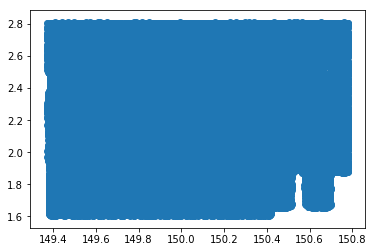

166641


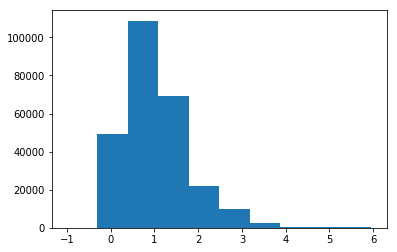

In [3]:
# read in UV data

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UVISTA_master_v4.1/UVISTA_final_v4.1.153-155.rf', 'r')
lines_UV = data_UV.readlines()[11:]

z = []
for line in lines_UV:
    p = line.split()
    z.append(float(p[1]))

z = np.array(z)

from astropy.io import ascii
data_cat = data_cat = ascii.read("/Users/mtownsend/eazy-photoz/inputs/UVISTA_master_v4.1.cat")  

ra = data_cat['ra']
dec = data_cat['dec']
# z_spec = data_cat['z_spec']
use = data_cat['USE']
star = data_cat['star']
contamination = data_cat['contamination']
nan_contam = data_cat['nan_contam']
# z = data_cat['z_spec']

cut = np.where((use == 1.) & (star == 0.) & (contamination == 0.) & (nan_contam < 3.)) # & (Uflux > 0.) & (Vflux > 0.) & (zflux > 0.)) # & (zp > 0.))

ra_UV = ra[cut]
dec_UV = dec[cut]
z_peak = z[cut]

plt.scatter(ra_UV,dec_UV)
plt.show()

print(len(z_peak))

plt.hist(z)
plt.show()


In [4]:
gmag_LS1 = 22.5 - 2.5 * np.log10(gflux_LS1/mw_transmission_g_LS1)
gmag_LS2 = 22.5 - 2.5 * np.log10(gflux_LS2/mw_transmission_g_LS2)
rmag_LS1 = 22.5 - 2.5 * np.log10(rflux_LS1/mw_transmission_r_LS1)
rmag_LS2 = 22.5 - 2.5 * np.log10(rflux_LS2/mw_transmission_r_LS2)
zmag_LS1 = 22.5 - 2.5 * np.log10(zflux_LS1/mw_transmission_z_LS1)
zmag_LS2 = 22.5 - 2.5 * np.log10(zflux_LS2/mw_transmission_z_LS2)

ra_LS = np.concatenate([ra_LS1, ra_LS2])
dec_LS = np.concatenate([dec_LS1, dec_LS2])
gmag_LS = np.concatenate([gmag_LS1, gmag_LS2])
rmag_LS = np.concatenate([rmag_LS1, rmag_LS2])
zmag_LS = np.concatenate([zmag_LS1, zmag_LS2]) 


# match sources in UVista and LS catalogs

from astropy.coordinates import SkyCoord, match_coordinates_sky                                   
from astropy import units as u       

UVISTA_cat  = SkyCoord(ra=ra_UV*u.degree, dec=dec_UV*u.degree)

my_cat = SkyCoord(ra=ra_LS*u.degree, dec=dec_LS*u.degree) 

idx_UVISTA, sep2d_UVISTA, dist3d_UVISTA = match_coordinates_sky(UVISTA_cat, my_cat, nthneighbor=1)

sep2d_UVISTA_deg = sep2d_UVISTA.deg

sep_idx_UVISTA = idx_UVISTA[np.where(sep2d_UVISTA_deg <= 0.0003)]

print(len(sep_idx_UVISTA))

69987


69987
69987


/Users/mtownsend/anaconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


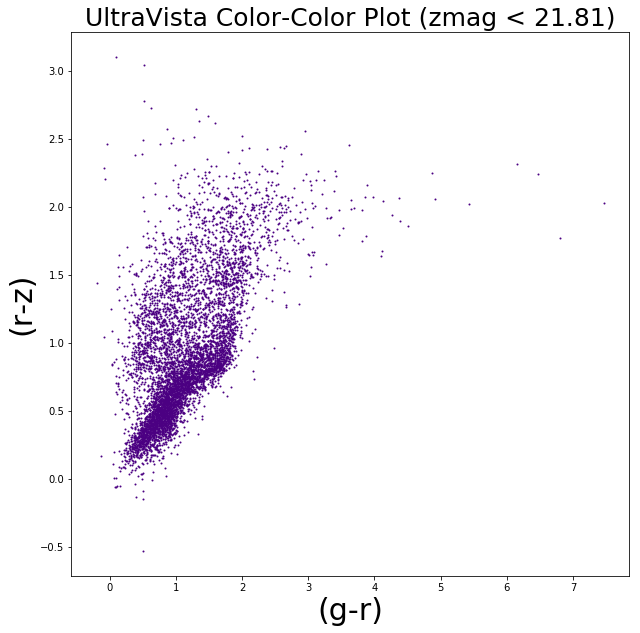

In [5]:
# calculate rest frame g-band luminosity

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UV_LS_OUTPUT/UV_LS_main_output.294.rf', 'r')
lines_UV = data_UV.readlines()[10:]

distmod = []
gflux = []
redshift = []
for line in lines_UV:
    p = line.split()
    redshift.append(float(p[1]))
    distmod.append(float(p[2]))
    gflux.append(float(p[5]))

DM = np.array(distmod)
Gflux = np.array(gflux)
zspec = np.array(redshift)

# K correction
K_correct = -2.5*np.log10((1. + zspec)**-1.)

# Absolute magnitude
gMag = -2.5*np.log10(Gflux) + 25. - DM - K_correct

# Calculate rest frame zmag

Msun_z = 4.50
Msun_g = 5.05
gLum = 10.**((gMag-Msun_g)/(-2.5))

log_gLum = np.log10(gLum)

print(len(log_gLum))
print(len(zspec))

# calculate (g-r) and (r-z) colors
    
grcolor_UVLS_nocut = gmag_LS[sep_idx_UVISTA] - rmag_LS[sep_idx_UVISTA]
rzcolor_UVLS_nocut = rmag_LS[sep_idx_UVISTA] - zmag_LS[sep_idx_UVISTA]
zmag_UVLS_nocut = zmag_LS[sep_idx_UVISTA]

grcolor_UVLS = grcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]
rzcolor_UVLS = rzcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]
zmag_UVLS = zmag_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]

zspec_UVLS = zspec[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]

log_gLum_cut = log_gLum[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False) & (zspec >= 0.2) & (zspec <= 0.65))]


plt.rcParams["figure.figsize"] = [10, 10]
# plt.scatter(zmag_UVLS, rzcolor_UVLS, s=1, c='red', marker='*')
plt.scatter(grcolor_UVLS[np.where(zmag_UVLS < 21.81)], rzcolor_UVLS[np.where(zmag_UVLS < 21.81)], s=1, c='indigo')
# plt.scatter(zmag_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], rzcolor_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], s=1, c='green', marker='o')
plt.title('UltraVista Color-Color Plot (zmag < 21.81)', fontsize=25)
plt.xlabel('(g-r)', fontsize=30)
plt.ylabel('(r-z)', fontsize=30)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/UVcmd-zmagONLY.pdf')
# plt.tick_params(axis='both', which='major', labelsize=25)
plt.show()


[0.2  0.29 0.38 0.47 0.56 0.65]


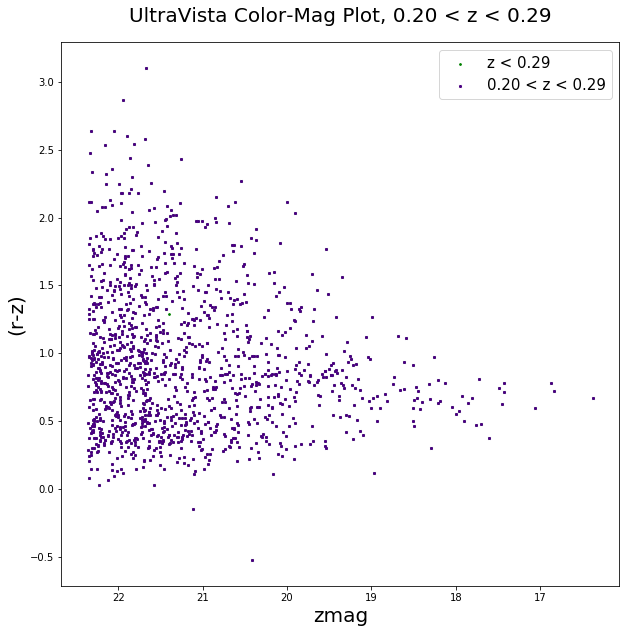

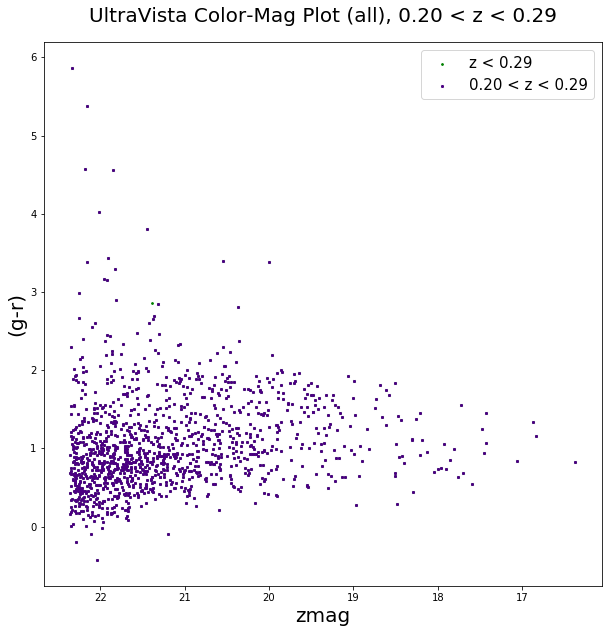

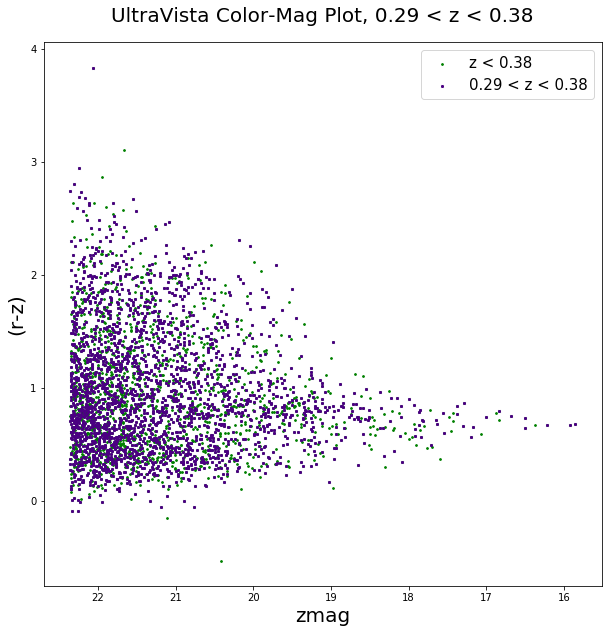

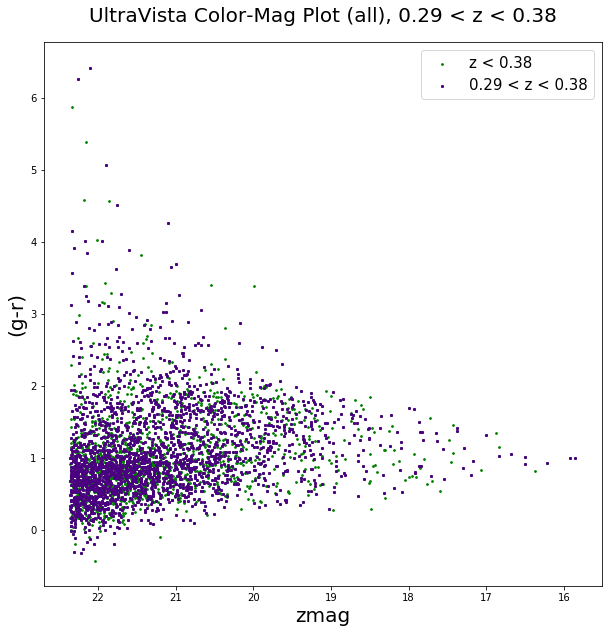

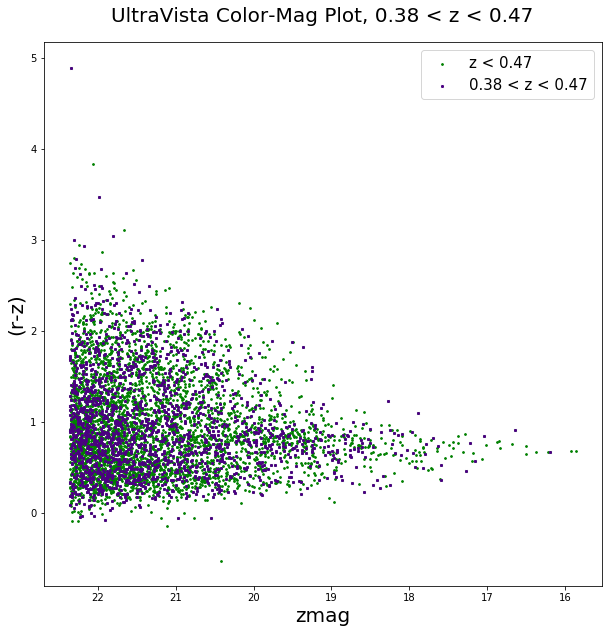

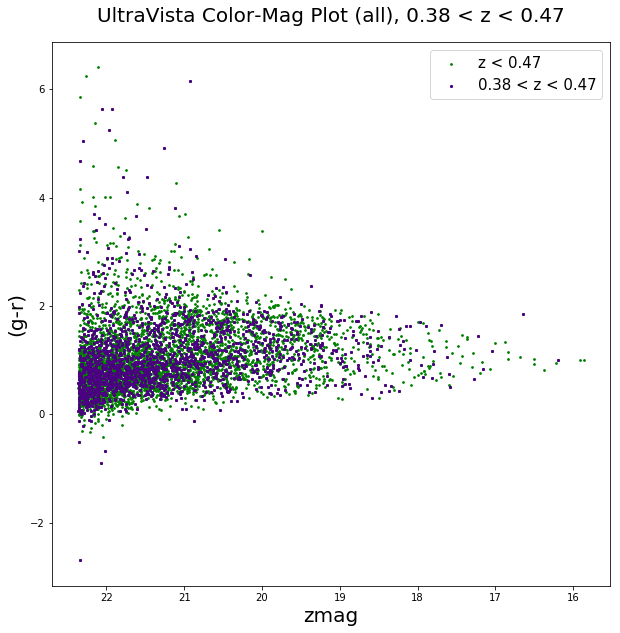

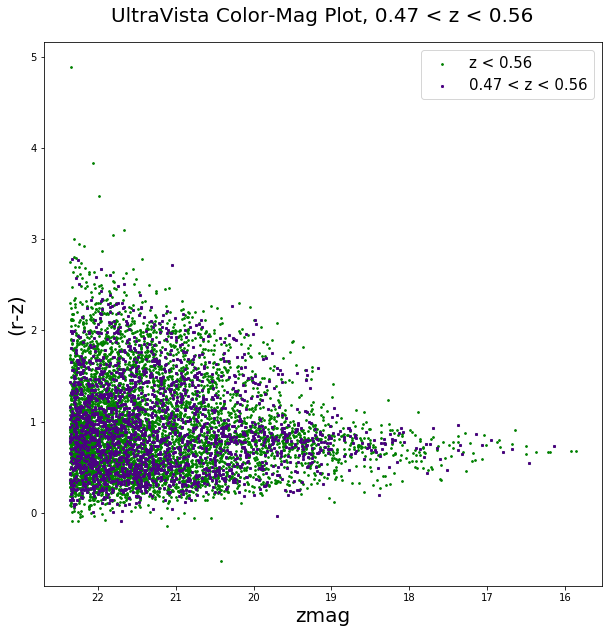

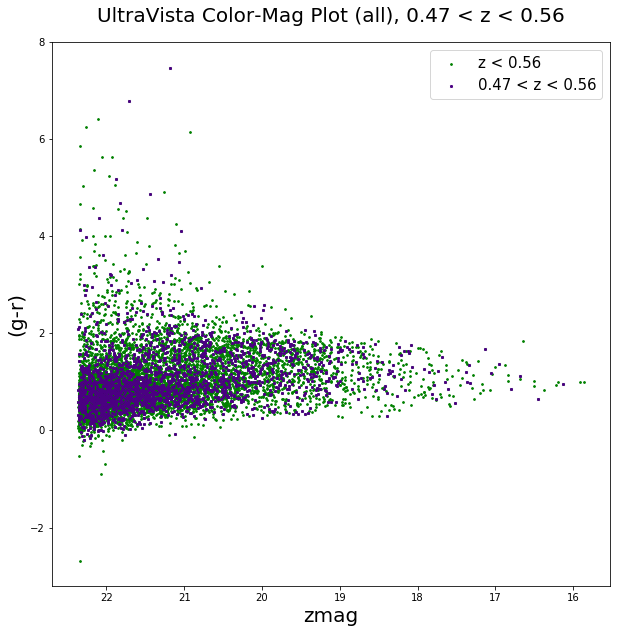

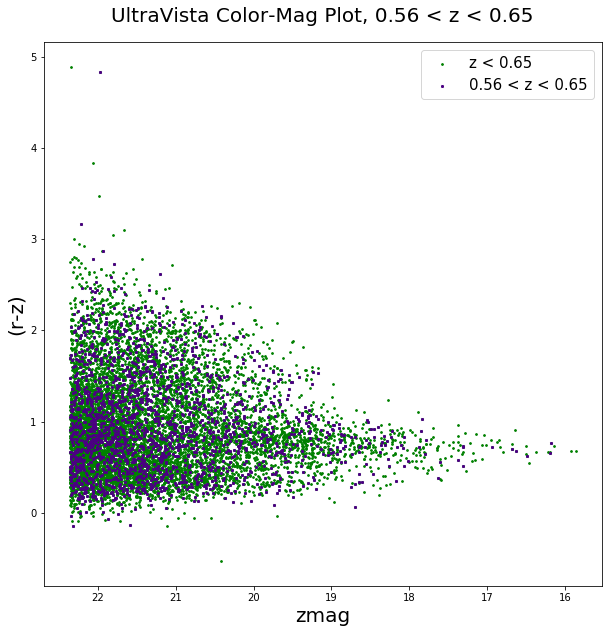

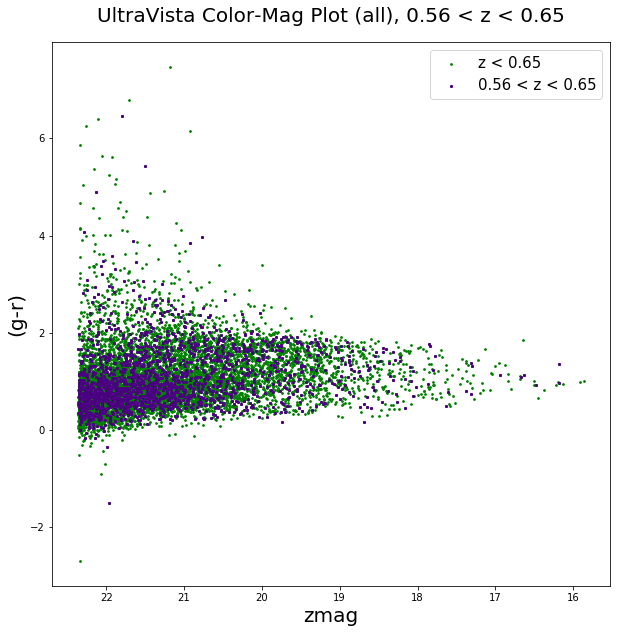

In [33]:
grcolor_all = grcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]
rzcolor_all = rzcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]
zmag_all = zmag_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]

zspec_all = zspec[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]


zinit = 0.2
zfin = 0.65
interval = 0.075
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

for i in range(len(zrange)-1):
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.scatter(zmag_UVLS[np.where(zspec_UVLS < zrange[i+1])], rzcolor_UVLS[np.where(zspec_UVLS < zrange[i+1])], s=3, c='green', marker='o', label="z < {0:.2f}".format(zrange[i+1]))
    plt.scatter(zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS < zrange[i+1]))], rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS < zrange[i+1]))], s=5, c='indigo', marker='x', label='{0:.2f} < z < {1:.2f}'.format(zrange[i], zrange[i+1]))
    plt.gca().invert_xaxis()
    plt.title('UltraVista Color-Mag Plot, {0:.2f} < z < {1:.2f}'.format(zrange[i], zrange[i+1]), fontsize=20, pad=20)
    plt.xlabel('zmag', fontsize=20)
    plt.ylabel('(r-z)', fontsize=20)
    plt.legend(loc='upper right', fontsize=15)
    plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/UV_r-z_cmd_{0:.2f}-{1:.2f}.pdf'.format(zrange[i], zrange[i+1]))
    # plt.tick_params(axis='both', which='major', labelsize=25)
    plt.show()

    plt.rcParams["figure.figsize"] = [10, 10]
    plt.scatter(zmag_UVLS[np.where(zspec_UVLS < zrange[i+1])], grcolor_UVLS[np.where(zspec_UVLS < zrange[i+1])], s=3, c='green', marker='o', label="z < {0:.2f}".format(zrange[i+1]))
    plt.scatter(zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS < zrange[i+1]))], grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS < zrange[i+1]))], s=5, c='indigo', marker='x', label='{0:.2f} < z < {1:.2f}'.format(zrange[i], zrange[i+1]))
    plt.gca().invert_xaxis()
    plt.title('UltraVista Color-Mag Plot (all), {0:.2f} < z < {1:.2f}'.format(zrange[i], zrange[i+1]), fontsize=20, pad=20)
    plt.xlabel('zmag', fontsize=20)
    plt.ylabel('(g-r)', fontsize=20)
    plt.legend(loc='upper right', fontsize=15)
    plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/UV_g-r_cmd_{0:.2f}-{1:.2f}.pdf'.format(zrange[i], zrange[i+1]))
    # plt.tick_params(axis='both', which='major', labelsize=25)
    plt.show()
    
    

In [ ]:


# def making_masks(H1, lum_limit, x, y, z, lum, xedges, yedges, zedges):
def making_masks(H2D, H3D, lum_limit, x, y, z, lum, xedges, yedges, zedges):
    
    # lum_limit == luminosity threshold
    # x,y,z == arrays involved in the 3D histogram
    # lum = log luminosity array; same size as x (or y or z)
    # xedges,yedges,zedges = boundaries to search for x,y,z
    
    import numpy as np
    
    temp = []
#     medzmag = np.zeros_like(H2D, dtype=float)
    medzmag = np.full_like(H2D, -999., dtype=float)
#     indexlist = np.zeros((2,2,2),dtype=list)

    # This loop finds the observed zmag that cooresponds to the luminosity limit for each cell in color-color space
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            for m in range(len(x)):
                if ((x[m] >= xedges[i]) & (x[m] <= xedges[i+1]) & (y[m] >= yedges[j]) & (y[m] <= yedges[j+1])):
#                     print('index: ', m)
#                     print('luminosity: ', lum[m])
#                     print('zmag: ', z[m])
#                     print("---")
                    if (abs(lum[m]-lum_limit) < 0.2):
                        temp.append(z[m])
#                         print(temp)
#                         print(lum[m])
#                         print(z[m])
#                         print('----')
                    if (len(temp) > 0.):
#                         print('temp: ', temp)
                        medzmag[i][j] = np.median(list(temp))
#                         print(medzmag[i][j])
#                         print('median zmag: ', medzmag[i][j])
#                         print('----')
#                     else:
#                         medzmag[i][j] = -999.
#                 else:
#                     medzmag[i][j] = -999.
#         print('temp before: ', temp)
        temp = []
#         print('temp after: ', temp)       
#     median_zmag_array = medzmag
#     print(test_array)
#     print('----')
    
    mask_array = np.empty_like(H3D)
    
    # This loop finds the cells in color-color space that are brighter in the observed zmag than the median zmag
    # and makes a mask of 1s and 0s
    for i in range(len(mask_array)):
#         print(len(mask_array))
#     print(mask_array[i])
#     print(edges2[i+1])
#     print('----')
        for j in range(len(mask_array[i])):
            for k in range(len(mask_array[i][j])):
                if (medzmag[i][j] >= zedges[k+1]):
#                 if ((medzmag[i][j] >= 22.02509002685544) & (22.02509002685544 >= zedges[k+1])):
                    mask_array[i][j][k] = 1
#                     print('i = ',i)
#                     print('j = ', j)
#                     print('k = ', k)
#                     print(mask_array[i][j][k])
#                     print('----')
                else:
                    mask_array[i][j][k] = 0
#                     print('i = ', i)
#                     print('j = ', j)
#                     print('k = ', k)
#                     print(mask_array[i][j][k])
#                     print('----')

    return medzmag, mask_array



In [38]:
def median_zmag(H2D, lum_limit, lum, x, y, z, xedges, yedges):
    
    # For use with selection_matrix(H3D, medzmag, zedges)
    # lum_limit == log(luminosity threshold)
    # x,y,z == arrays involved in the 3D histogram
    # lum = log luminosity array; same size as x (or y or z)
    # xedges,yedges = boundaries to search for x,y
    
    import numpy as np
    
    temp = []
    medzmag = np.full_like(H2D, -999., dtype=float)

    # This loop finds the observed zmag that cooresponds to the luminosity limit for each cell in color-color space
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            for m in range(len(x)):
                if ((x[m] >= xedges[i]) & (x[m] <= xedges[i+1]) & (y[m] >= yedges[j]) & (y[m] <= yedges[j+1])):
#                     if (abs(lum[m]-lum_limit) < 0.2):
                    if (z[m] == z[m]):
                        temp.append(z[m])
                    if (len(temp) > 0.):
                        medzmag[i][j] = np.median(list(temp))

        temp = []
    
    return medzmag
    

In [7]:
def selection_matrix(H3D, medzmag, zedges):
    
    # lum_limit == luminosity threshold
    # x,y,z == arrays involved in the 3D histogram
    # lum = log luminosity array; same size as x (or y or z)
    # xedges,yedges,zedges = boundaries to search for x,y,z

    selection_array = np.empty_like(H3D)
    
    # This loop finds the cells in color-color space that are brighter in the observed zmag than the median zmag
    # and makes a mask of 1s and 0s
    for i in range(len(selection_array)):
        for j in range(len(selection_array[i])):
            for k in range(len(selection_array[i][j])):
                if (medzmag[i][j] >= zedges[k+1]):
#                 if ((medzmag[i][j] >= 22.02509002685544) & (22.02509002685544 >= zedges[k+1])):
                    selection_array[i][j][k] = 1
                else:
                    selection_array[i][j][k] = 0

    return selection_array

In [43]:
# rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.025, 22.025090026855437, 23.025090026855434])
# gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

print(len(rz_edges))
print(len(gr_edges))

rzinit = -1.8027077
rzfin = 10.44729232788086
rz_interval = 0.5
rz_num = (rzfin-rzinit)/rz_interval
rz_edges, step = np.linspace(rzinit, rzfin, num=int(rz_num), retstep=True)
print(len(rz_edges))

grinit = -6.5846786
grfin = 10.56532135009765
gr_interval = 0.5
gr_num = (grfin-grinit)/gr_interval
gr_edges, step = np.linspace(grinit, grfin, num=int(gr_num), retstep=True)
print(len(gr_edges))

zmaginit = 13.
zmagfin = 23.
zmag_interval = 0.2
zmag_num = (zmagfin-zmaginit)/zmag_interval
zmag_edges, step = np.linspace(zmaginit, zmagfin, num=int(zmag_num), retstep=True)
print(len(zmag_edges))

Hstar2D, rz_nouse, gr_nouse = np.histogram2d(rzcolor_UVLS, grcolor_UVLS, bins=(rz_edges, gr_edges), density=False)
Hstar3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)

print(type(Hstar2D))

zinit = 0.2
zfin = 0.65
interval = 0.075
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

50
50
24
34
50
<class 'numpy.ndarray'>
[0.2  0.29 0.38 0.47 0.56 0.65]


In [44]:


# medianzmag_slice = []
# medianzmag_upto = []
# for i in range(len(zrange)-1):
#     x1 = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     x2 = rzcolor_UVLS[np.where(zspec_UVLS <= zrange[i+1])]
# #     print(len(x))
#     y1 = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     y2 = grcolor_UVLS[np.where(zspec_UVLS <= zrange[i+1])]
# #     print(len(y))
#     z1 = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     z2 = zmag_UVLS[np.where(zspec_UVLS <= zrange[i+1])]
# #     print(len(z))
#     lum1 = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     lum2 = log_gLum_cut[np.where(zspec_UVLS <= zrange[i+1])]
# #     print(len(lum))
# #     medzmag = median_zmag(Hstar2D, 10.46, lum, x, y, z, rz_edges, gr_edges)
#     medzmag_slice = median_zmag(Hstar2D, 9.55, lum1, x1, y1, z1, rz_edges, gr_edges)
#     medzmag_upto = median_zmag(Hstar2D, 9.55, lum2, x2, y2, z2, rz_edges, gr_edges)
#     medianzmag_slice.append(medzmag_slice)
#     medianzmag_upto.append(medzmag_upto)
#     print(i)
    
medzmag_high= median_zmag(Hstar2D, 10.46, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges, gr_edges)
medzmag_low = median_zmag(Hstar2D, 9.55, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges, gr_edges)
medzmag_mid1 = median_zmag(Hstar2D, 9.84, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges, gr_edges)
medzmag_mid2 = median_zmag(Hstar2D, 10.24, log_gLum_cut, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, rz_edges, gr_edges)


In [61]:
# data_zmag = np.load('/Users/mtownsend/Desktop/middle-z-2-median_zmag-v1.npz')
# data_smatrix = np.load('/Users/mtownsend/Desktop/middle-z-2-selection_matrix-v1.npz')

# # data0 = data_zmag['medzmag0']
# print(data_zmag['medzmag0'].shape)
# print(data_zmag['medzmag1'].shape)
# print(data_zmag['medzmag2'].shape)
# print(data_zmag['medzmag3'].shape)
# print(data_zmag['medzmag4'].shape)
# print(len(data_zmag))

# print('----')

# print(data_smatrix['smatrix0'].shape)
# print(data_smatrix['smatrix1'].shape)
# print(data_smatrix['smatrix2'].shape)
# print(data_smatrix['smatrix3'].shape)
# print(data_smatrix['smatrix4'].shape)

# print('----')

print(medianzmag1[0].shape)
print(medianzmag1[1].shape)
print(medianzmag1[2].shape)
print(medianzmag1[3].shape)
print(medianzmag1[4].shape)

print('----')

print(medianzmag2[0].shape)
print(medianzmag2[1].shape)
print(medianzmag2[2].shape)
print(medianzmag2[3].shape)
print(medianzmag2[4].shape)

(49, 49)
(49, 49)
(49, 49)
(49, 49)
(49, 49)
----
(49, 49)
(49, 49)
(49, 49)
(49, 49)
(49, 49)


In [10]:
# medzmag_slice0 = medianzmag1[0]
# medzmag_slice1 = medianzmag1[1]
# medzmag_slice2 = medianzmag1[2]
# medzmag_slice3 = medianzmag1[3]
# medzmag_slice4 = medianzmag1[4]

# medzmag0 = medianzmag2[0]
# medzmag1 = medianzmag2[1]
# medzmag2 = medianzmag2[2]
# medzmag3 = medianzmag2[3]
# medzmag4 = medianzmag2[4]

# medzmag_slice0[medzmag_slice0 == -999] = 0. 
# medzmag_slice1[medzmag_slice1 == -999] = 0.
# medzmag_slice2[medzmag_slice2 == -999] = 0.
# medzmag_slice3[medzmag_slice3 == -999] = 0.
# medzmag_slice4[medzmag_slice4 == -999] = 0.

# medzmag0[medzmag0 == -999] = 0. 
# medzmag1[medzmag1 == -999] = 0.
# medzmag2[medzmag2 == -999] = 0.
# medzmag3[medzmag3 == -999] = 0.
# medzmag4[medzmag4 == -999] = 0.


# np.savez('/Users/mtownsend/Desktop/low-z-median_zmag-v3.npz', medzmag0=medzmag0, medzmag1=medzmag1, medzmag2=medzmag2, medzmag3=medzmag3, medzmag4=medzmag4)
# np.savez('/Users/mtownsend/Desktop/highz_test2.npz', medzmag0=medzmag0, medzmag1=medzmag1, medzmag2=medzmag2, medzmag3=medzmag3, medzmag4=medzmag4)
# np.savez('/Users/mtownsend/Desktop/highz_medzmag.npz', medzmag_high=medzmag_high)
# np.savez('/Users/mtownsend/Desktop/lowz_medzmag.npz', medzmag_low=medzmag_low)
# np.savez('/Users/mtownsend/Desktop/mid1z_medzmag.npz', medzmag_mid1=medzmag_mid1)
# np.savez('/Users/mtownsend/Desktop/mid2z_medzmag.npz', medzmag_mid1=medzmag_mid1)

# data_zmag = np.load('/Users/mtownsend/Desktop/highz_medzmag_slice.npz')

# data_zmag_upto = np.load('/Users/mtownsend/Desktop/lowz_medzmag_upto.npz')
# data_zmag_slice = np.load('/Users/mtownsend/Desktop/lowz_medzmag_slice.npz')

# print(data_zmag['medianzmag1'].shape)
# zmag_upto = data_zmag_upto['medianzmag_upto']
# zmag_slice = data_zmag_slice['medianzmag_slice']
# print(data.shape)
# print(data[0].shape)


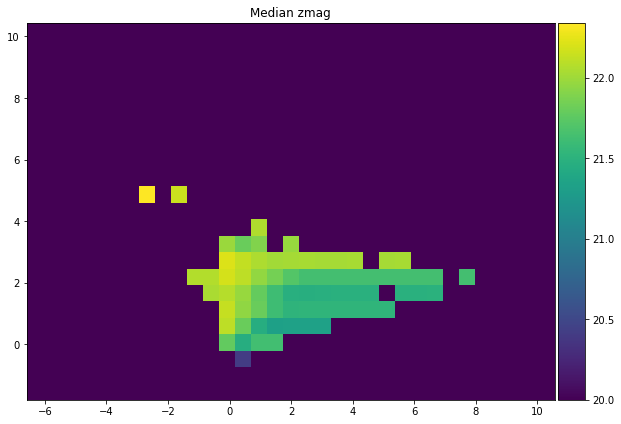

In [45]:
medzmag_high[medzmag_high == -999] = 0.

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(medzmag_high, origin='lower', vmin=20., extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Median zmag")
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/9July2020/a-medzmag-21.64-overplot.pdf')
plt.show()

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(medzmag4, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("Median zmag")
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/9July2020/a-medzmag-21.64-overplot.pdf')
# plt.show()

In [14]:
# data_zmag_upto = np.load('/Users/mtownsend/Desktop/lowz_medzmag_upto.npz')
# data_zmag_slice = np.load('/Users/mtownsend/Desktop/lowz_medzmag_slice.npz')

# data_zmag_upto = np.load('/Users/mtownsend/Desktop/mid1z_medzmag_upto.npz')
# data_zmag_slice = np.load('/Users/mtownsend/Desktop/mid1z_medzmag_slice.npz')

# data_zmag_upto = np.load('/Users/mtownsend/Desktop/mid2z_medzmag_upto.npz')
# data_zmag_slice = np.load('/Users/mtownsend/Desktop/mid2z_medzmag_slice.npz')

# print(data_zmag['medianzmag1'].shape)
# zmag_upto = data_zmag_upto['medianzmag_upto']
# zmag_slice = data_zmag_slice['medianzmag_slice']
# print(data.shape)

# smatrix_upto = []
# smatrix_slice = []
# for i in range(len(medianzmag1)):
#     masks_upto = selection_matrix(Hstar3D, zmag_upto[i], zmag_edges)
#     masks_slice = selection_matrix(Hstar3D, zmag_slice[i], zmag_edges)
#     smatrix_upto.append(masks_upto)
#     smatrix_slice.append(masks_slice)
#     print(i)


smatrix_high = selection_matrix(Hstar3D, medzmag_high, zmag_edges)
smatrix_low = selection_matrix(Hstar3D, medzmag_low, zmag_edges)
smatrix_mid1 = selection_matrix(Hstar3D, medzmag_mid1, zmag_edges)
smatrix_mid2 = selection_matrix(Hstar3D, medzmag_mid2, zmag_edges)

np.savez('/Users/mtownsend/Desktop/highz_smatrix.npz', smatrix_high=smatrix_high)
np.savez('/Users/mtownsend/Desktop/lowz_smatrix.npz', smatrix_low=smatrix_low)
np.savez('/Users/mtownsend/Desktop/mid1z_smatrix.npz', smatrix_mid1=smatrix_mid1)
np.savez('/Users/mtownsend/Desktop/mid2z_smatrix.npz', smatrix_mid2=smatrix_mid2)

data_smatrix_high = np.load('/Users/mtownsend/Desktop/highz_smatrix.npz')
data_smatrix_low = np.load('/Users/mtownsend/Desktop/lowz_smatrix.npz')
data_smatrix_mid1 = np.load('/Users/mtownsend/Desktop/mid1z_smatrix.npz')
data_smatrix_mid2 = np.load('/Users/mtownsend/Desktop/mid2z_smatrix.npz')

# print(data_zmag['medianzmag1'].shape)
# data_smatrix_upto = data_smatrix_upto['smatrix_upto']
# data_smatrix_slice = data_smatrix_slice['smatrix_slice']

print(data_smatrix_high['smatrix_high'].shape)
print(data_smatrix_low['smatrix_low'].shape)
print(data_smatrix_mid1['smatrix_mid1'].shape)
print(data_smatrix_mid2['smatrix_mid2'].shape)
# print(data_smatrix_upto[0].shape)
# print(data_smatrix_upto[1].shape)
# print(data_smatrix_upto[2].shape)
# print(data_smatrix_upto[3].shape)
# print(data_smatrix_upto[4].shape)


(49, 49, 49)
(49, 49, 49)
(49, 49, 49)
(49, 49, 49)


In [88]:
print(smatrix1[0].shape)
print(smatrix1[1].shape)
print(smatrix1[2].shape)
print(smatrix1[3].shape)
print(smatrix1[4].shape)

print('----')

print(smatrix2[0].shape)
print(smatrix2[1].shape)
print(smatrix2[2].shape)
print(smatrix2[3].shape)
print(smatrix2[4].shape)

print(np.asarray(smatrix1).shape)

(49, 49, 49)
(49, 49, 49)
(49, 49, 49)
(49, 49, 49)
(49, 49, 49)
----
(49, 49, 49)
(49, 49, 49)
(49, 49, 49)
(49, 49, 49)
(49, 49, 49)
(5, 49, 49, 49)


In [97]:
# smatrix0 = smatrix1[0]
# smatrix1 = smatrix1[1]
# smatrix2 = smatrix1[2]
# smatrix3 = smatrix1[3]
# smatrix4 = smatrix1[4]

# print(smatrix0.shape)
# print(smatrix1.shape)
# print(smatrix2.shape)
# print(smatrix3.shape)
# print(smatrix4.shape)

print('----')

# np.savez('/Users/mtownsend/Desktop/highz_mask_test1.npz', smatrix0=smatrix0, smatrix1=smatrix1, smatrix2=smatrix2, smatrix3=smatrix3, smatrix4=smatrix4)
# np.savez('/Users/mtownsend/Desktop/highz_mask_test1.npz', smatrix=smatrix1)

data_smatrix = np.load('/Users/mtownsend/Desktop/highz_mask_test1.npz')

# print(smatrix.shape)
# print(len(zmag_edges))

print(data_smatrix['smatrix'].shape)
# print(data_smatrix['smatrix1'].shape)
# print(data_smatrix['smatrix2'].shape)
# print(data_smatrix['smatrix3'].shape)
# print(data_smatrix['smatrix4'].shape)

data = data_smatrix['smatrix']
print(data[4].shape)


----
(5, 49, 49, 49)
(49, 49, 49)


In [25]:
print(smatrix_high.shape)

(49, 49, 49)


In [ ]:
# rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
# zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
# gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]


rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.02509002685544, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

H3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)

mask_array = np.empty_like(H3D)
print(mask_array.shape)
print(len(mask_array[0][0]))
    
# This loop finds the cells in color-color space that are brighter in the observed zmag than the median zmag
# and makes a mask of 1s and 0s
for i in range(len(mask_array)):
    for j in range(len(mask_array[i])):
        for k in range(len(mask_array[i][j])):
            if ((rz_edges[i] > 2.) & (rz_edges[i] < 6.) & (zmag_edges[k] >= zmag_edges[3]) & (zmag_edges[k] <= zmag_edges[5])):
                mask_array[i][j][k] = 1
            elif ((rz_edges[i] > 6.) & (zmag_edges[k] >= zmag_edges[3]) & (zmag_edges[k] <= zmag_edges[5])):
                mask_array[i][j][k]= 2
            else:
                mask_array[i][j][k] = 0

print(len(mask_array[np.where(mask_array != 0)]))
print(len(mask_array))
print(len(grcolor_UVLS[np.where((rzcolor_UVLS > 0.8) & (zmag_UVLS >= zmag_edges[3]) & (zmag_UVLS <= zmag_edges[5]))]))

# print(zmag_edges[40])
print(np.median(rzcolor_UVLS))


# mask_array = np.empty_like(H3D)

# for i in range(len(rz_edges)-1):
#     for j in range(len(gr_edges)-1):
#         for k in range(len(zmag_edges)-1):
#             if ((rz_edges[i] > 2.) & (rz_edges[i] < 6.) & (zmag_edges[k] >= zmag_edges[10]) & (zmag_edges[k] <= zmag_edges[16])):
#                 mask_array[i][j][k] = 1
#             elif ((rz_edges[i] > 6.) & (zmag_edges[k] >= zmag_edges[10]) & (zmag_edges[k] <= zmag_edges[16])):
#                 mask_array[i][j][k]= 2
#             else:
#                 mask_array[i][j][k] = 0
#             if ((rz_edges[i] > 2.) & (zmag_edges[k] >= zmag_edges[10]) & (zmag_edges[k] <= zmag_edges[16])):
#                 mask_array[i][j][k] = 1
#             else:
#                 mask_array[i][j][k] = 0
            
            
#             for m in range(len(rzcolor_UVLS)):
#                 if ((rzcolor_UVLS[m] >= rz_edges[i]) & (rzcolor_UVLS[m] <= rz_edges[i+1]) & (grcolor_UVLS[m] >= gr_edges[j]) & (grcolor_UVLS[m] <= gr_edges[j+1]) & (zmag[m] >= zmag_edges[k]) & (zmag[m] <= zmag_edges[k+1])):
#                     temp.append(lum[m])
#                     if (len(temp) > 0.):
#                         lumlist[i][j][k] = np.median(list(temp))
# #                       indexlist[i][j][k] = list(temp)
#                     else:
#                         lumlist[i][j][k] = 0.


In [ ]:
# rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
# zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
# gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.025, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

# rz_edges = np.array([-1.8027077, -0.8027076721191406, 0.19729232788085938, 1.1972923278808594, 2.1972923278808594, 3.1972923278808594, 4.197292327880859, 5.197292327880859, 6.197292327880859, 7.197292327880859, 8.19729232788086, 9.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 22.025090026855437, 23.025090026855434])
# gr_edges = np.array([-6.5846786, -5.184678649902345, -4.134678649902346, -3.784678649902346, -2.734678649902346, -1.6846786499023456, -0.2846786499023456, 1.1153213500976542, 2.1653213500976545, 3.2153213500976547, 4.265321350097655, 5.315321350097654, 6.015321350097653, 7.065321350097652, 8.115321350097652, 9.165321350097651, 10.56532135009765])


# rzcolor = rzcolor_UVLS[0:19]
# print(rzcolor)
# print('----')
# grcolor = grcolor_UVLS[0:19]
# print(grcolor)
# print('----')
# zmag = zmag_UVLS[0:19]
# print(zmag)
# print('----')
# lum = log_gLum_cut[0:19]
# print(lum)
# print('----')
# print()
# print()

Hstar3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)
Hstar2D, rz_nouse, gr_nouse = np.histogram2d(rzcolor_UVLS, grcolor_UVLS, bins=(rz_edges, gr_edges), density=False)

# print(Hstar3D.shape)
# print(len(Hstar3D))
# make_array = np.empty_like(Hstar3D)
# print(make_array.shape)
# print(len(make_array))

medzmag, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, log_gLum_cut, rz_edges, gr_edges, zmag_edges) #, edges[2])


# zinit = 0.2
# zfin = 0.65
# zinterval = 0.05
# znum = (zfin-zinit)/zinterval
# zrange, zstep = np.linspace(0.2, 0.65, num=int(znum), retstep=True)
# print(zrange)
# print(zstep)

# masks = []
# median_zmag = []
# for i in range(len(zrange)-1):
#     x = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     y = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     z = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     lum = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     median_zmag_array, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, x, y, z, lum, rz_edges, gr_edges, zmag_edges)
#     median_zmag.append(median_zmag_array)
#     masks.append(mask_array)
#     print(i)
    

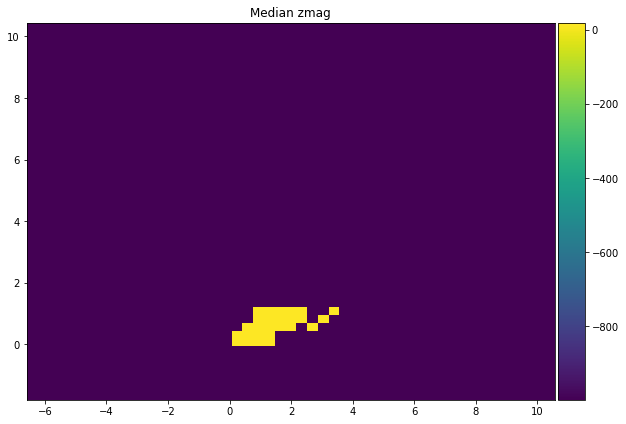

In [17]:
# masked_H = mask_array * Hstar3D
# projectionHstar = Hstar3D[:, :, :].sum(axis=2) 
# projectionMask = mask_array[:, :, :].sum(axis=2)
# projectionMasked_H = masked_H[:, :, :].sum(axis=2)

# medzmag[medzmag == -999] = 0. 

# datazmag = data_zmag['medzmag']
# datazmag[datazmag == -999] = 0.
# medzmag[medzmag > 22.025] = 0

# print(medzmag.max())
# print(medzmag[np.where(medzmag != 0.)].min())
# print(np.median(medzmag[np.where(medzmag != 0.)]))

# medzmag_cut = medzmag[np.where((medzmag != 0.) & (medzmag <= 21.64))]
# print(len(medzmag_cut))

# print(len(medzmag[np.where(medzmag != 0.)]))
# print(len(data[np.where(data != 0.)]))

# print(medzmag[np.where((medzmag != 0.) & (medzmag <= 21.64))])

# print(medzmag.shape)
# print(len(Hstar2D[np.where(Hstar2D != 0.)]))

# print(len(grcolor_UVLS[np.where(zmag_UVLS <= 21.8)]))
# print(len(grcolor_UVLS[np.where(zmag_UVLS > 21.8)]))

# print(len(medzmag))
# print(np.median(medzmag[np.where(medzmag != 0)]))

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(mask_array[0], origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# # plt.scatter(grcolor_UVLS[np.where(zmag_UVLS > 21.02509002685544)], rzcolor_UVLS[np.where(zmag_UVLS > 21.02509002685544)], s=1, c='cyan')
# # plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 22.02509002685544)], rzcolor_UVLS[np.where(zmag_UVLS <= 22.02509002685544)], alpha=0.2, s=5, c='red')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zmag_UVLS[0], zmag_UVLS[1]), fontsize=20, pad=20)
# #     ax.set_ylim([-0.6,5.5])
# ax.set_xlabel('(g-r)',fontsize=20)
# ax.set_ylabel('(r-z)',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/9July2020/c-color-color-selection-matrix-22.025-overplot.pdf')   
# plt.show()


# plt.rcParams["figure.figsize"] = [10, 10]
# plt.scatter(zmag_UVLS, rzcolor_UVLS, s=1, c='red', marker='*')
# plt.scatter(grcolor_UVLS[np.where(zmag_UVLS < 21.81)], rzcolor_UVLS[np.where(zmag_UVLS < 21.81)], s=1, c='indigo')
# # plt.scatter(zmag_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], rzcolor_UVLS[np.where((zmag_UVLS < 21.81) & (zspec_UVLS > 0.55) & (zspec_UVLS < 0.65))], s=1, c='green', marker='o')
# plt.title('UltraVista Color-Color Plot (zmag < 21.81)', fontsize=25)
# plt.xlabel('(g-r)', fontsize=30)
# plt.ylabel('(r-z)', fontsize=30)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/UVcmd-zmagONLY.pdf')
# # plt.tick_params(axis='both', which='major', labelsize=25)
# plt.show()

# data_smatrix = np.load('/Users/mtownsend/Desktop/selection_matrix-v3.npz')

# data_zmag = np.load('/Users/mtownsend/Desktop/median_zmag-v5.npz')

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(data_smatrix['smatrix0'], origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# # plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], rzcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], alpha=1, s=5, c='red')
# # plt.scatter(grcolor_UVLS, rzcolor_UVLS, s=5, c='grey', label="All UVista")
# # cm = plt.cm.get_cmap('RdYlBu')
# # plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], rzcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], s=5, alpha=0.2, color='red', label="zmag <= 21.64")
# # plt.legend(loc="upper right", fontsize=10)
# # plt.colorbar(sc, orientation='horizontal')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("Selection Matrix")
# # ax.set_ylim([-1.,5.])
# # ax.set_xlim([-1.,8.])
# # ax.set_xlabel('zmag',fontsize=20)
# # ax.set_ylabel('r-z',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/9July2020/a-medzmag-21.64-overplot.pdf')
# plt.show()

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(data_zmag['medzmag'], origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], rzcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], alpha=1, s=5, c='red')
# plt.scatter(grcolor_UVLS, rzcolor_UVLS, s=5, c='grey', label="All UVista")
# cm = plt.cm.get_cmap('RdYlBu')
# plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], rzcolor_UVLS[np.where(zmag_UVLS <= 21.64342498779297)], s=5, alpha=0.2, color='red', label="zmag <= 21.64")
# plt.legend(loc="upper right", fontsize=10)
# plt.colorbar(sc, orientation='horizontal')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Median zmag")
# ax.set_ylim([-1.,5.])
# ax.set_xlim([-1.,8.])
# ax.set_xlabel('zmag',fontsize=20)
# ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/9July2020/a-medzmag-21.64-overplot.pdf')
plt.show()


# cm = plt.cm.get_cmap('RdYlBu')
# sc = plt.scatter(grcolor_UVLS, rzcolor_UVLS, c=zmag_UVLS, vmin=21.039594650268555, vmax=22.356285095214844, s=5, cmap=cm)
# plt.colorbar(sc)
# plt.show()



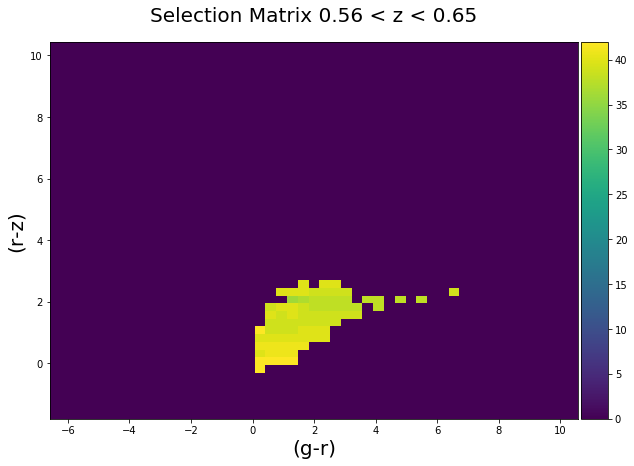

In [22]:
data_smatrix = np.load('/Users/mtownsend/Desktop/low-z-selection_matrix-v3.npz')

mask0 = data_smatrix['smatrix0']
mask1 = data_smatrix['smatrix1']
mask2 = data_smatrix['smatrix2']
mask3 = data_smatrix['smatrix3']
mask4 = data_smatrix['smatrix4']

mega_mask = mask0 + mask1 + mask2 + mask3 + mask4

projectionMask0 = mask0[:, :, :].sum(axis=2)
projectionMask1 = mask1[:, :, :].sum(axis=2)
projectionMask2 = mask2[:, :, :].sum(axis=2)
projectionMask3 = mask3[:, :, :].sum(axis=2)
projectionMask4 = mask4[:, :, :].sum(axis=2)

projectionMegaMask = mega_mask[:, :, :].sum(axis=2)

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionMask4, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[4], zrange[5]), fontsize=20, pad=20)
# ax.set_title("Selection Matrix", fontsize=20, pad=20)
ax.set_xlabel('(g-r)',fontsize=20)
ax.set_ylabel('(r-z)',fontsize=20)
plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
plt.show()



50


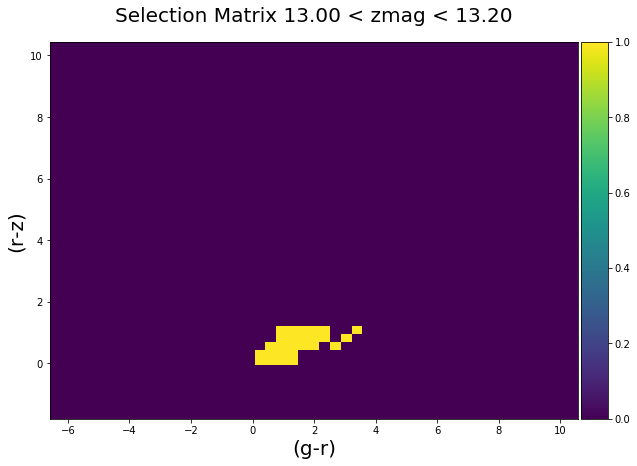

0


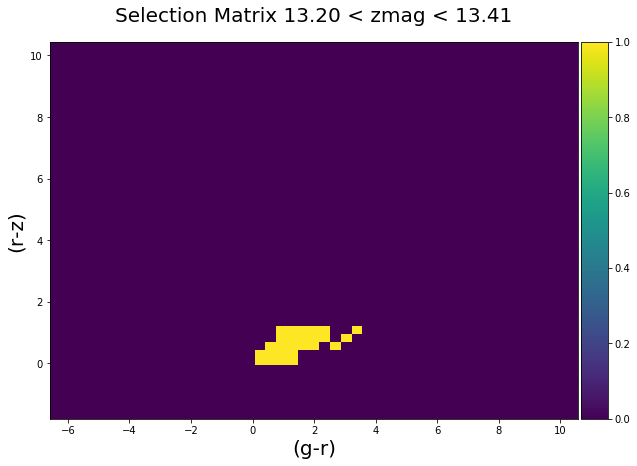

1


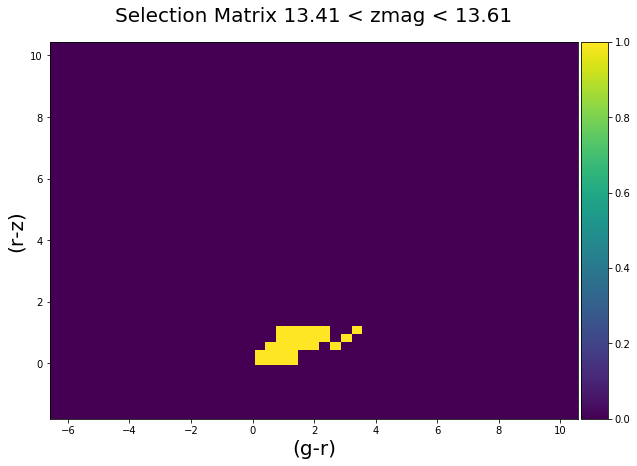

2


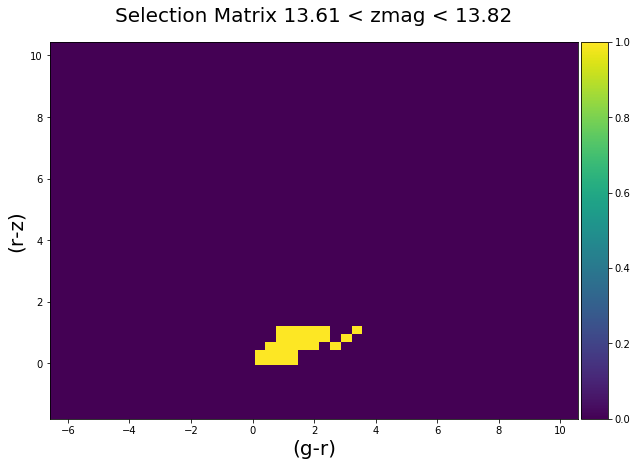

3


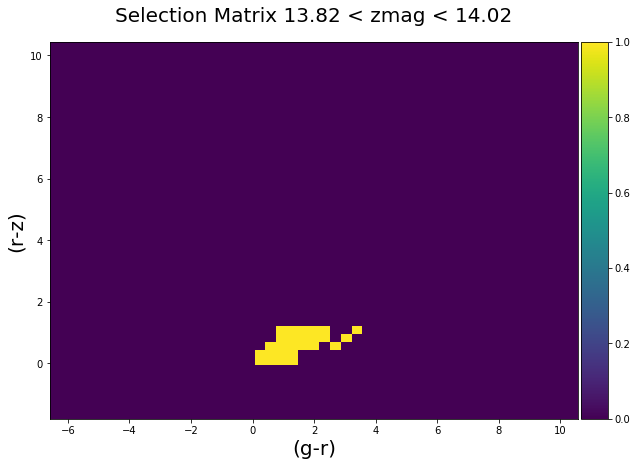

4


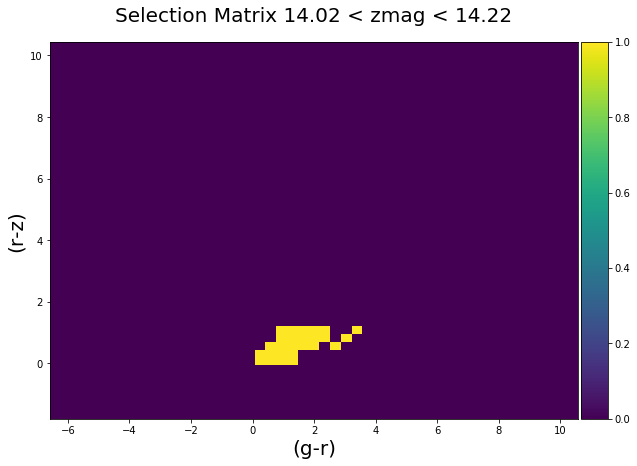

5


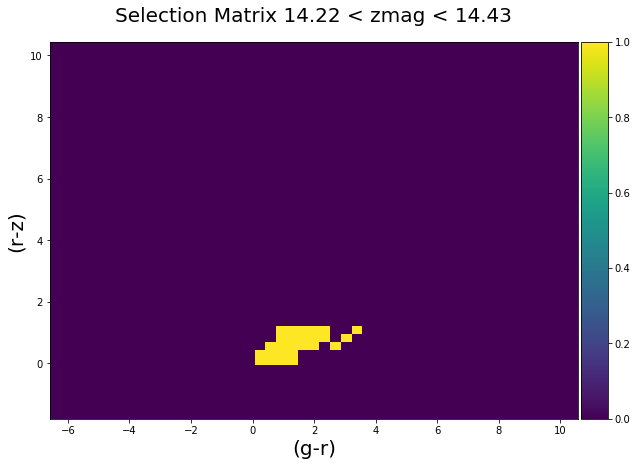

6


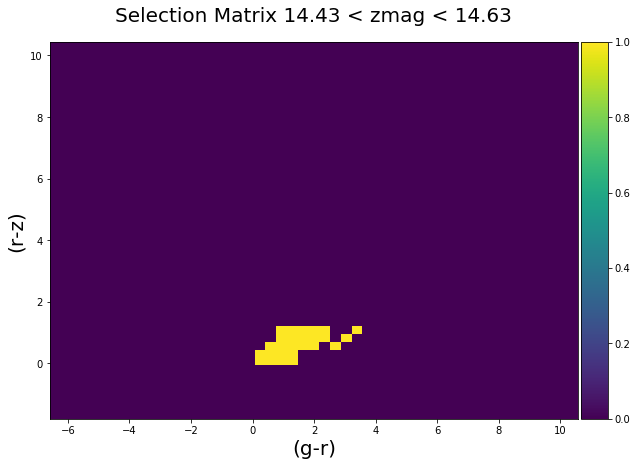

7


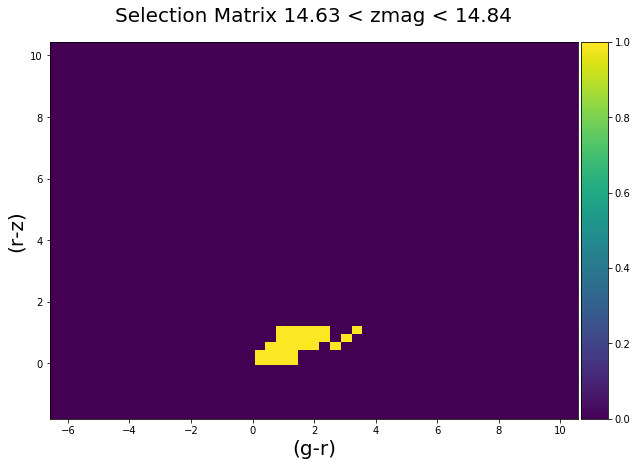

8


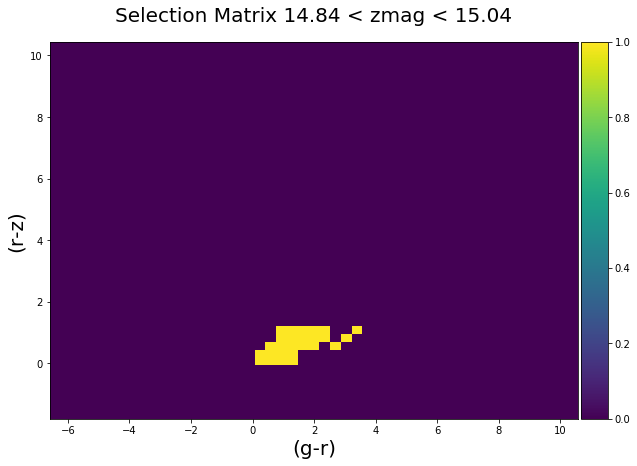

9


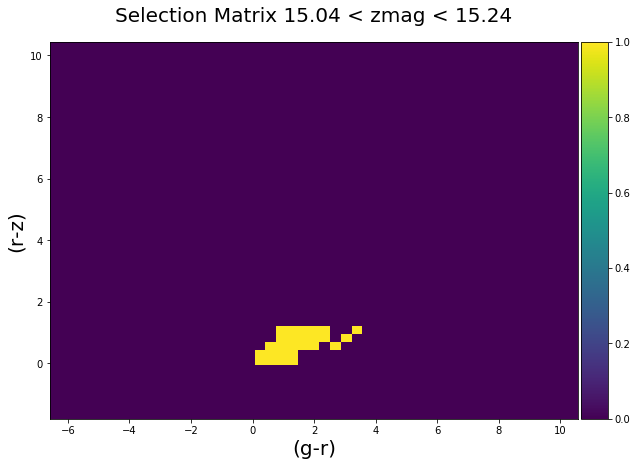

10


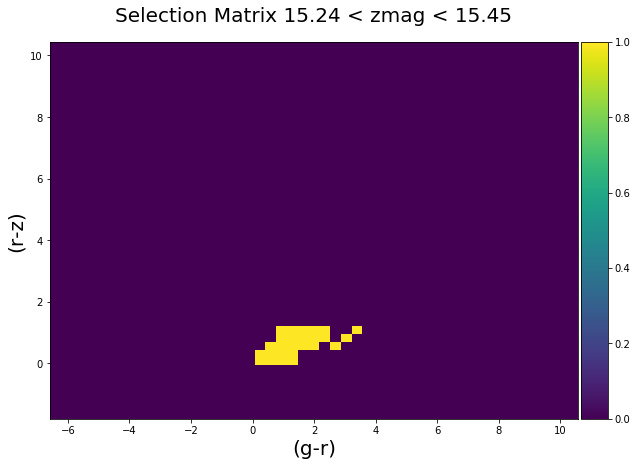

11


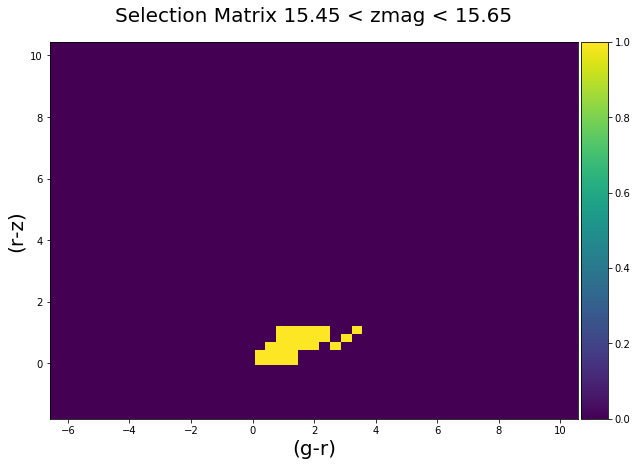

12


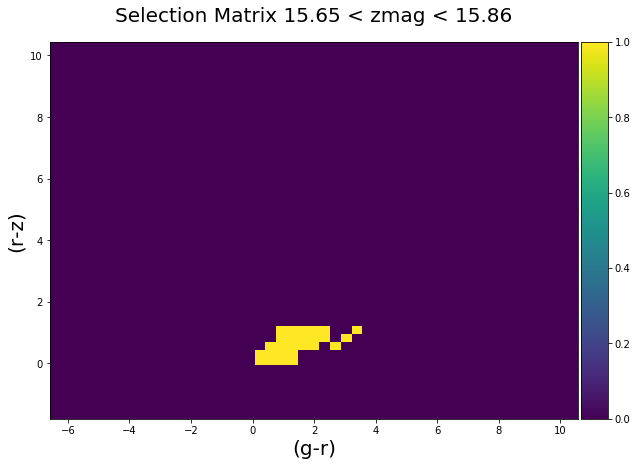

13


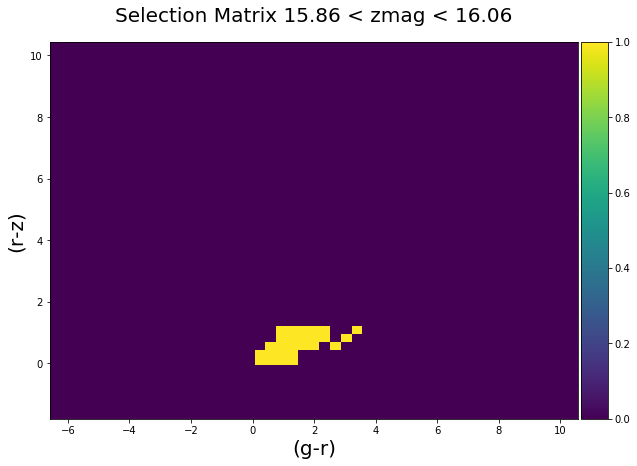

14


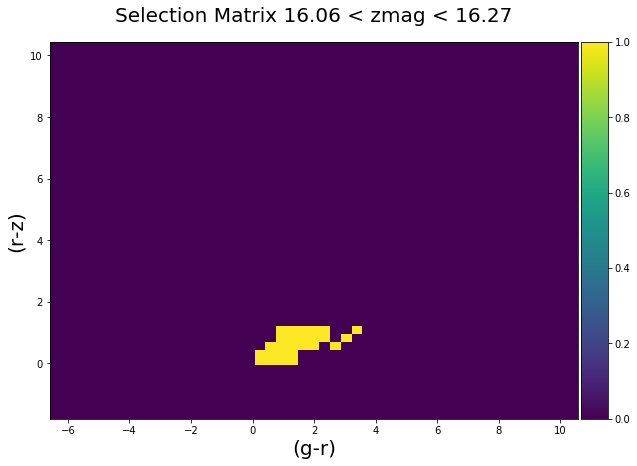

15


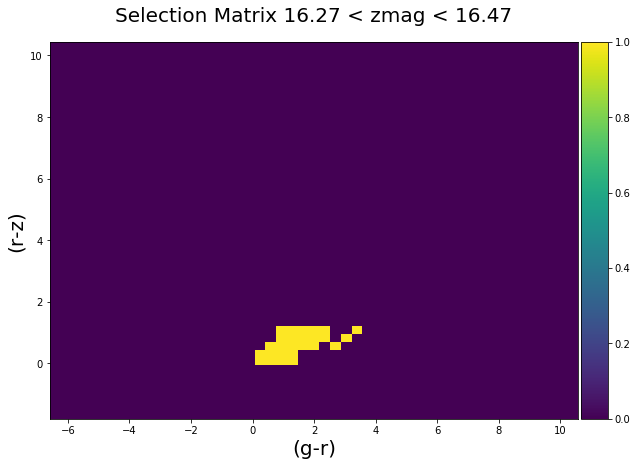

16


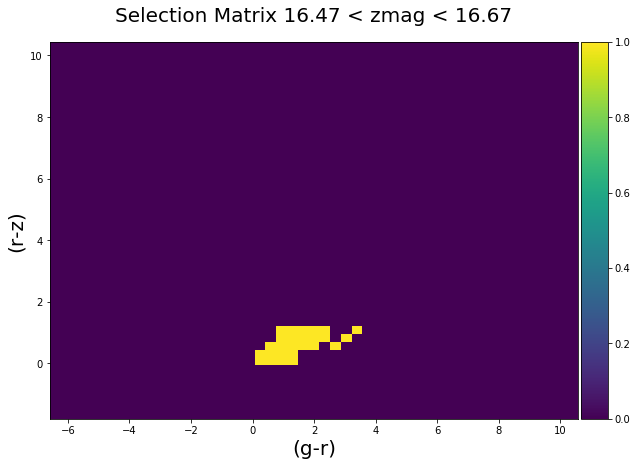

17


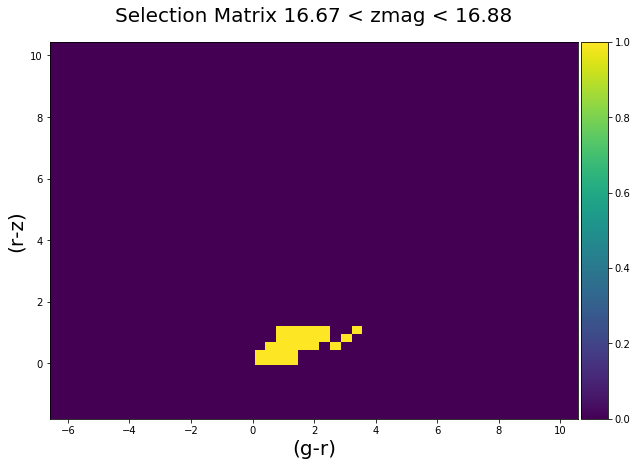

18


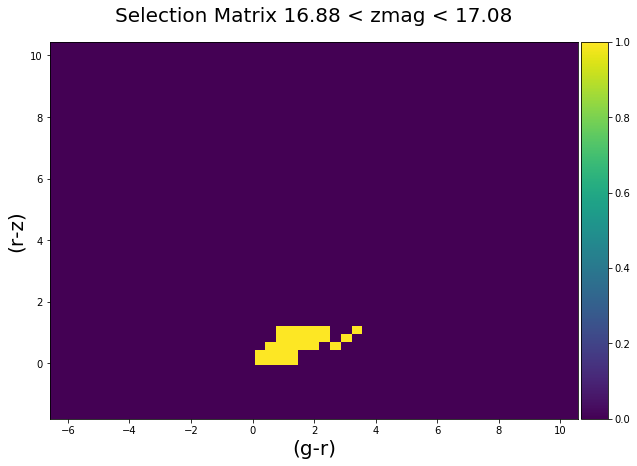

19


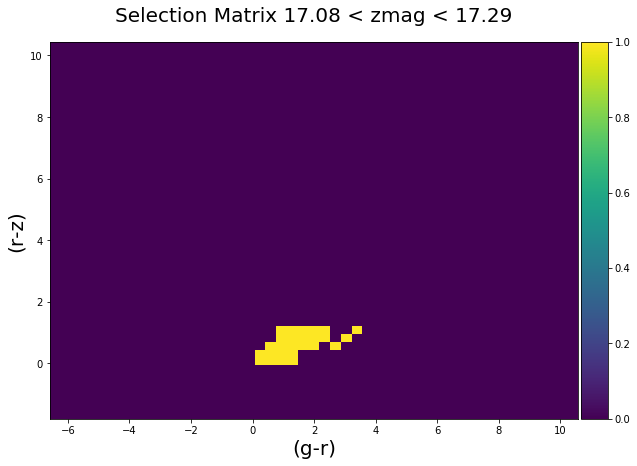

20


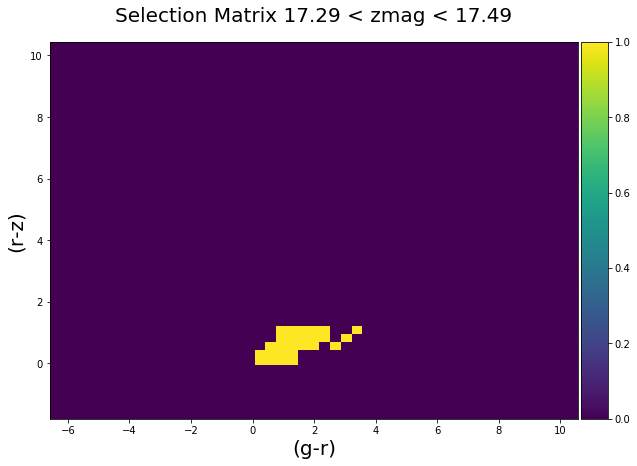

21


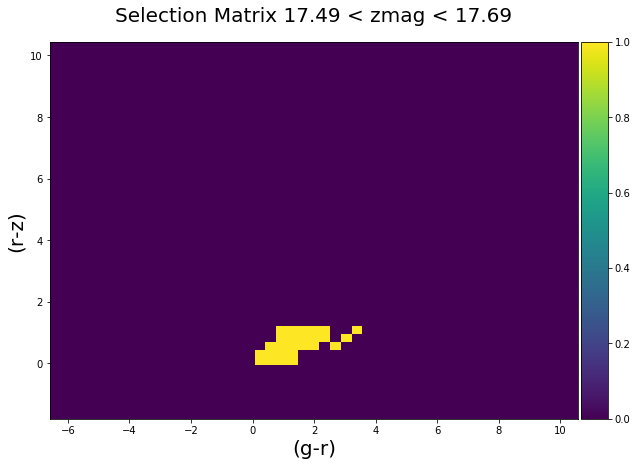

22


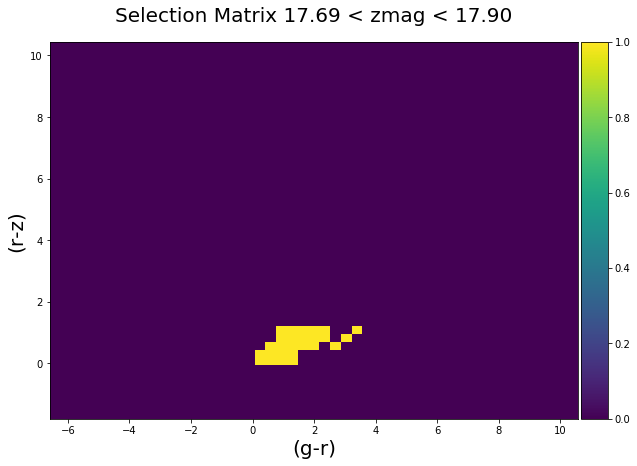

23


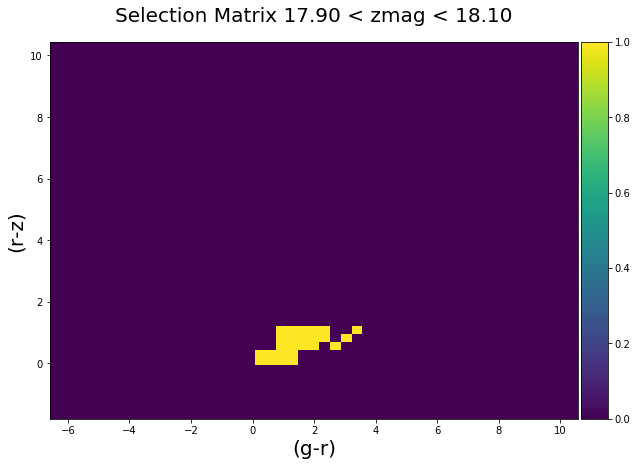

24


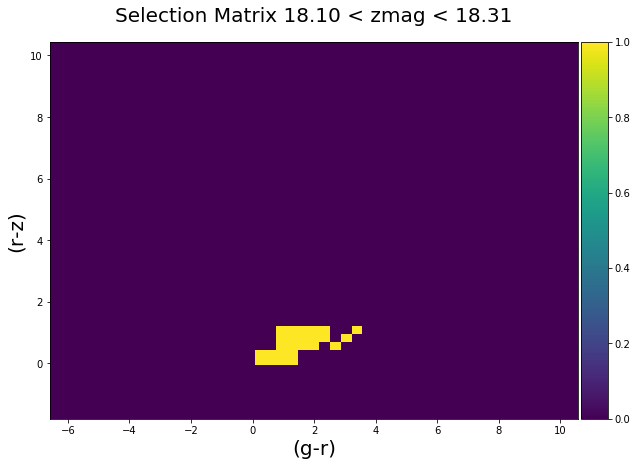

25


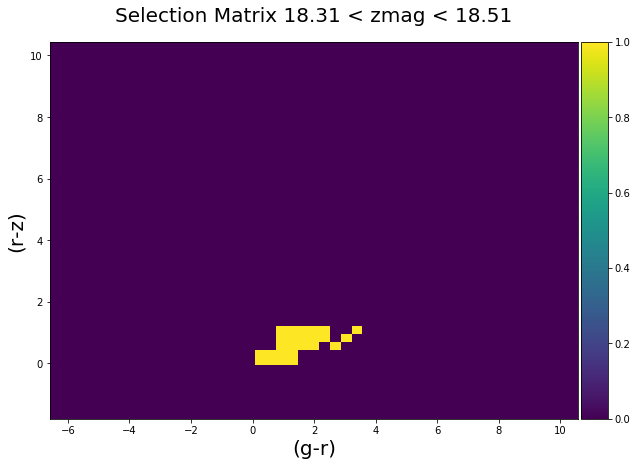

26


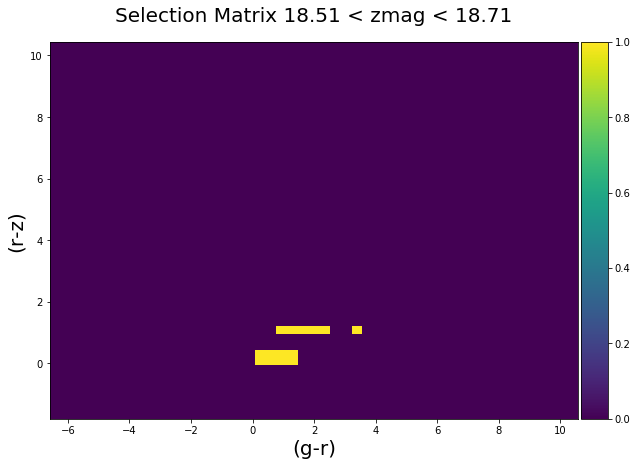

27


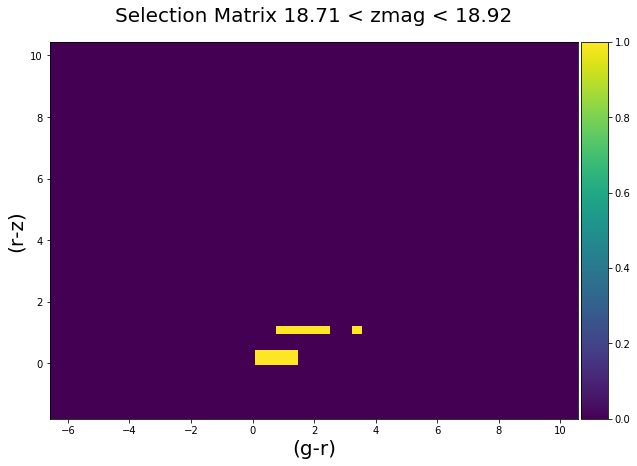

28


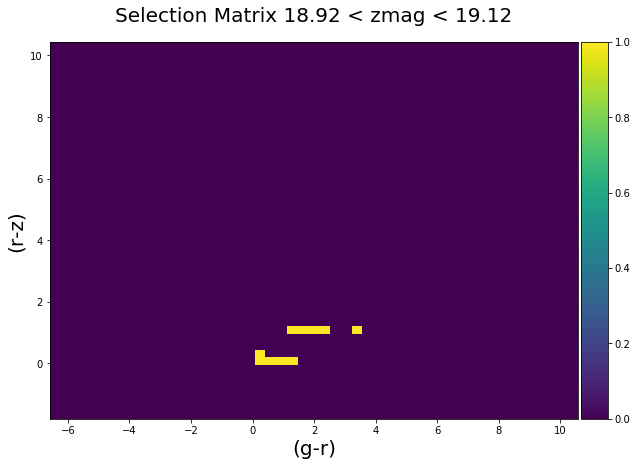

29


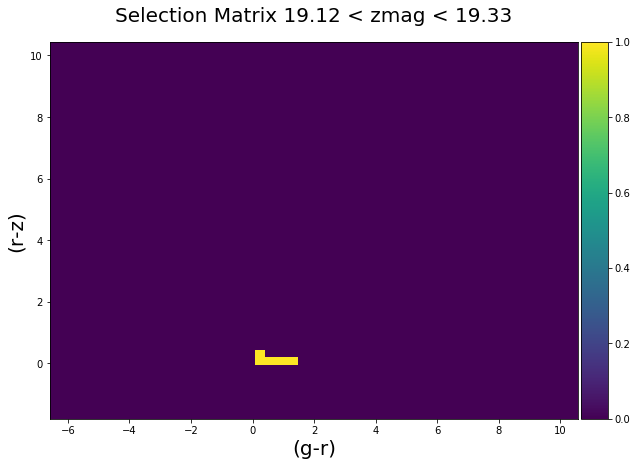

30


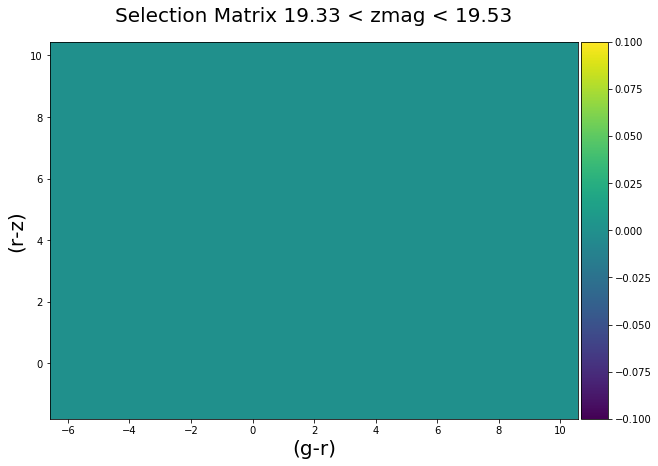

31


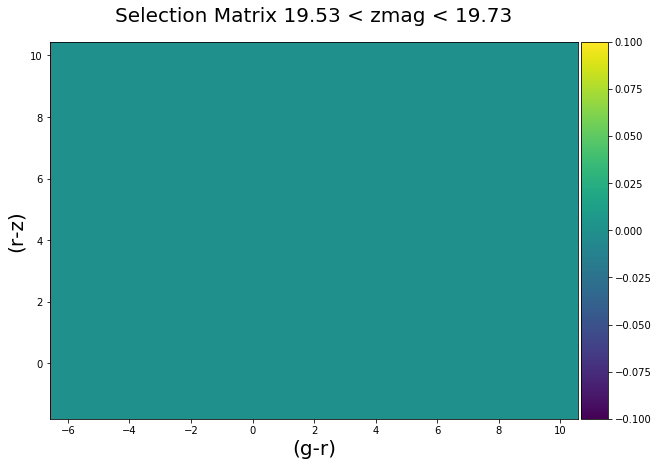

32


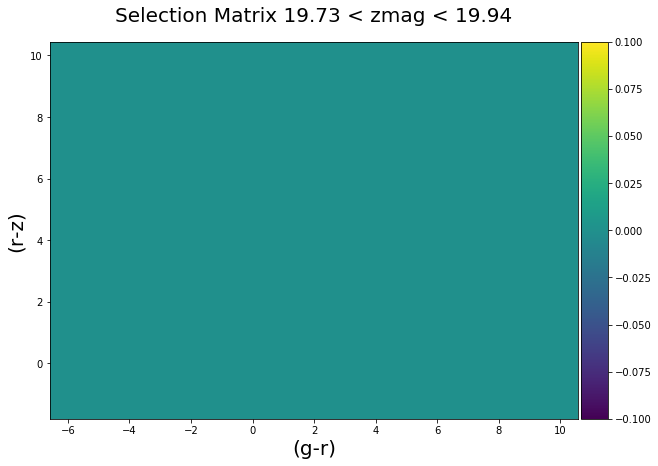

33


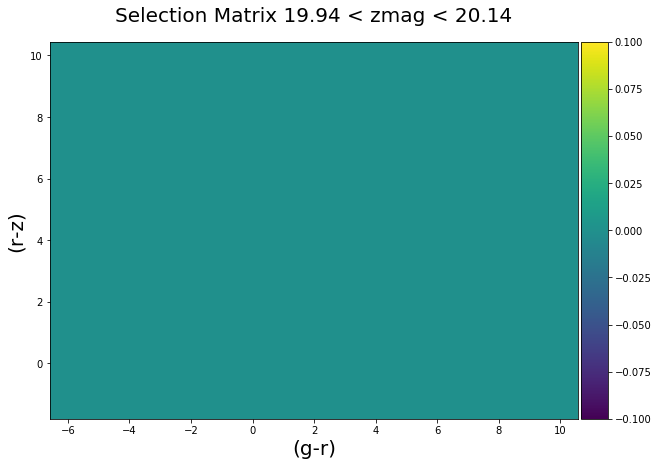

34


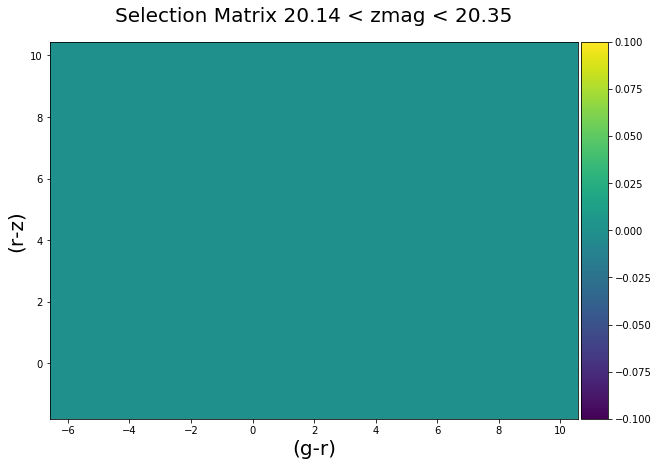

35


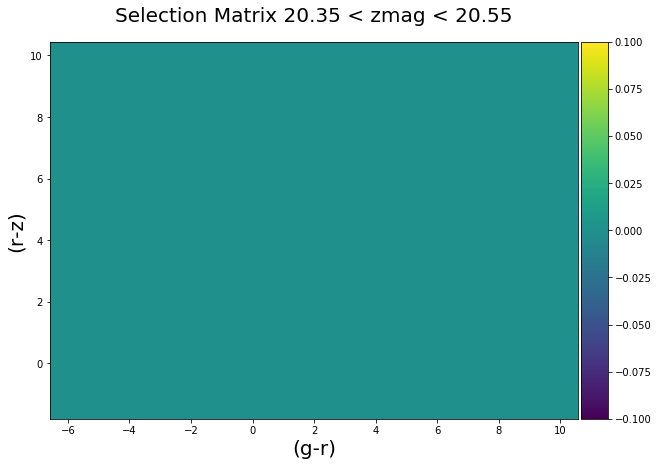

36


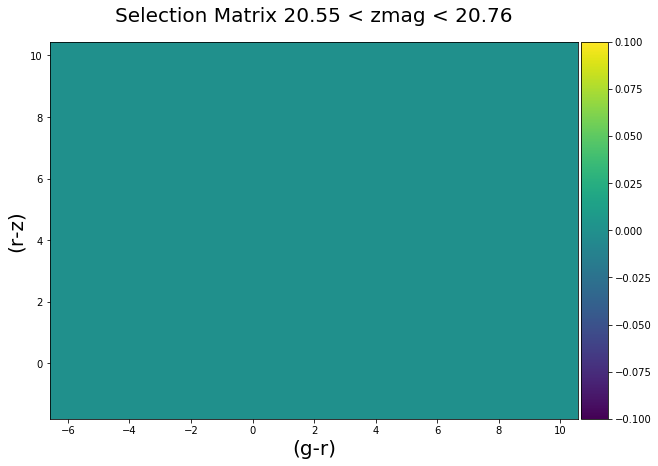

37


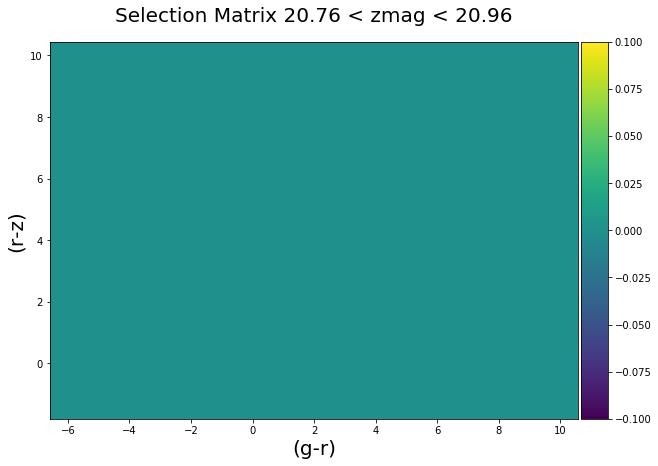

38


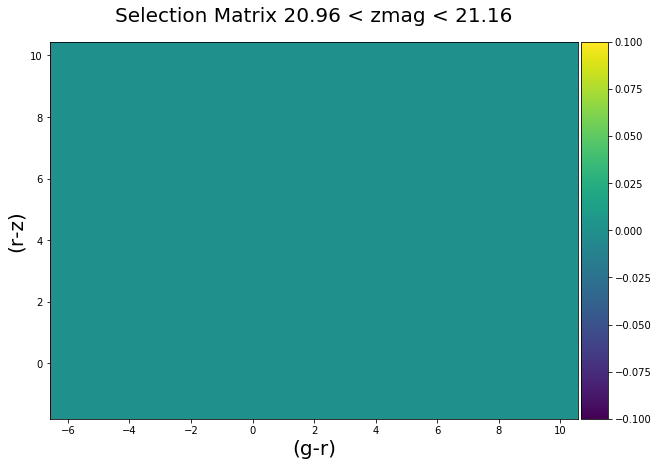

39


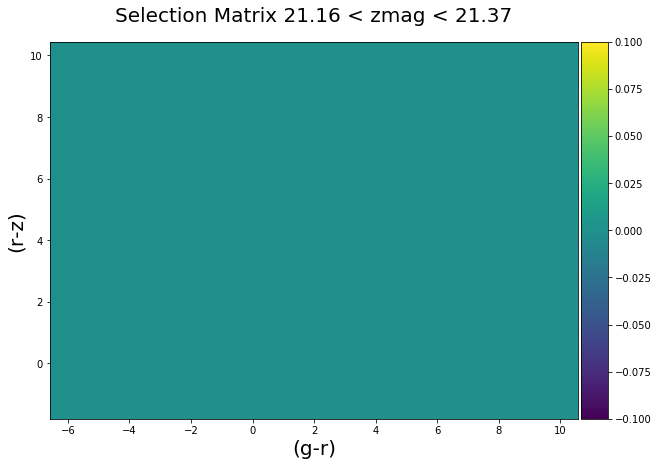

40


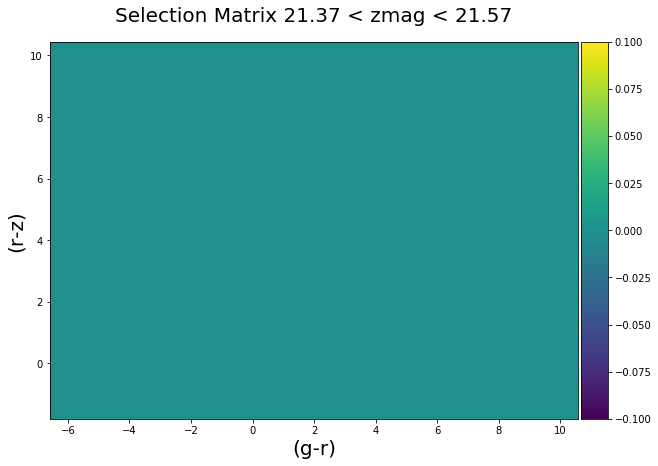

41


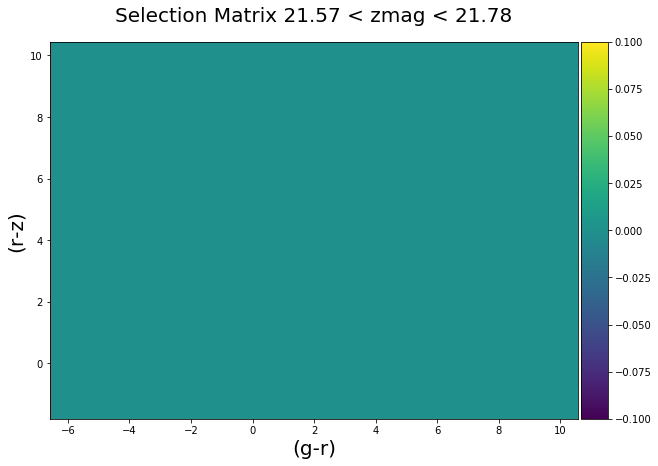

42


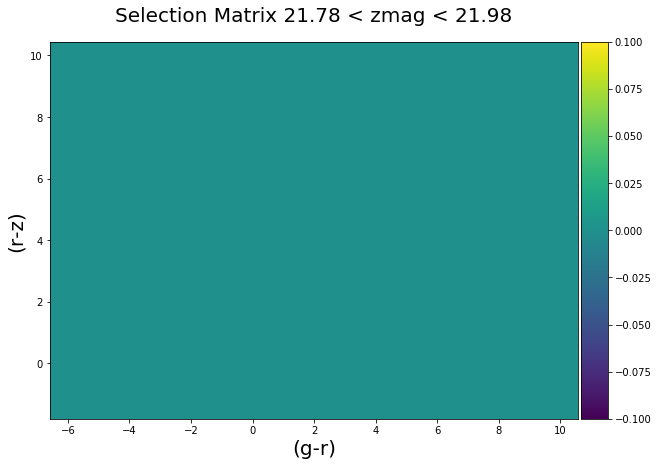

43


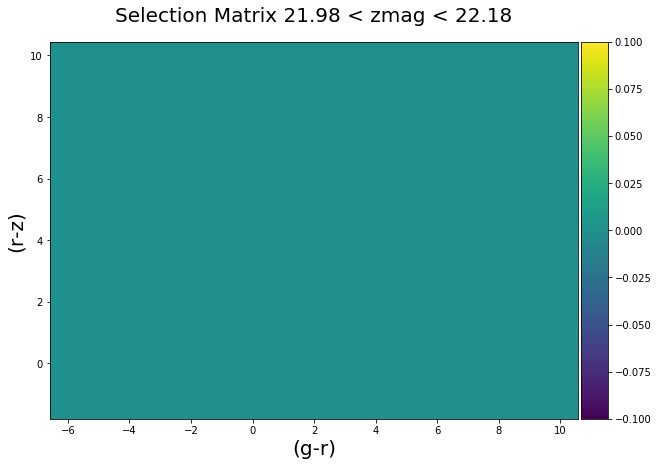

44


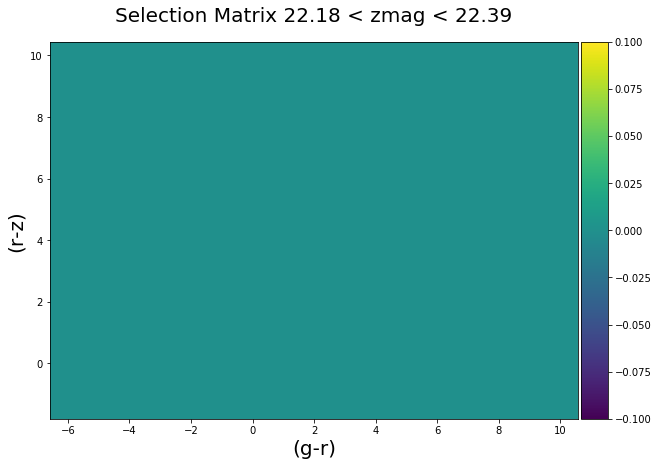

45


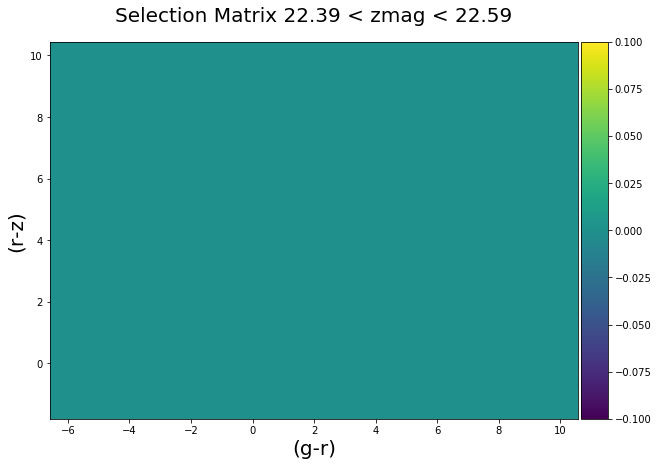

46


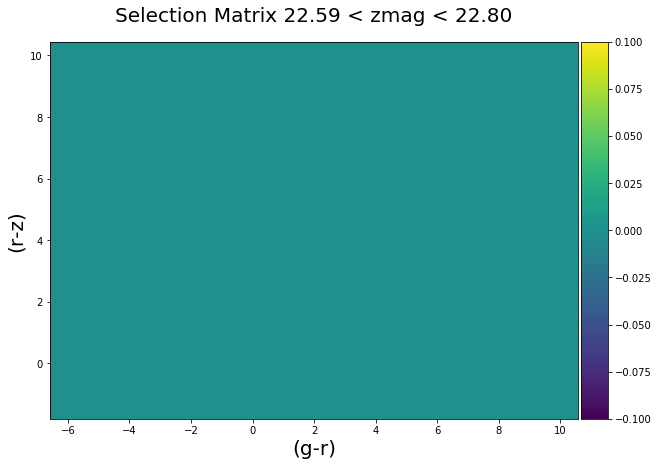

47


In [35]:
# print(mask_array[:, :, :])
# mask_array = data_smatrix[]
print(len(zmag_edges))

# data_smatrix = np.load('/Users/mtownsend/Desktop/selection_matrix-v5.npz')
# smatrix = data_smatrix['smatrix']
# smatrix0 = data_smatrix['smatrix0']
# smatrix1 = data_smatrix['smatrix1']
# smatrix2 = data_smatrix['smatrix2']
# smatrix3 = data_smatrix['smatrix3']
# smatrix4 = data_smatrix['smatrix4']

for i in range(len(smatrix)-1):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    im = ax.imshow(mask0[:,:,i], origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_title("Selection Matrix {0:.2f} < zmag < {1:.2f}".format(zmag_edges[i], zmag_edges[i+1]), fontsize=20, pad=20)
    ax.set_xlabel('(g-r)',fontsize=20)
    ax.set_ylabel('(r-z)',fontsize=20)
#     plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/16July2020/new-selection_matrix-zmagbin_{0:.2f}-{1:.02f}.pdf'.format(zmag_edges[i], zmag_edges[i+1]))   
    plt.show()
    print(i)
    

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(medzmag, vmax=22.025090026855437, vmin=21., origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 22.025090026855437)], rzcolor_UVLS[np.where(zmag_UVLS <= 22.025090026855437)], alpha=1, s=5, c='red')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Median zmag (zmag <= 22.35)")
# ax.set_ylim([-1.,5.])
# ax.set_xlim([-1.,8.])
# ax.set_xlabel('zmag',fontsize=20)
# ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/2July2020/b-medzmag-21.8.pdf')
plt.show()

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(medzmag, vmin=21.6, vmax=22.356285095214844, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# # plt.scatter(grcolor_UVLS[np.where(zmag_UVLS >= 22.)], rzcolor_UVLS[np.where(zmag_UVLS >= 22.)], alpha=1, s=5, c='red')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("Median zmag")
# # ax.set_ylim([-1.,5.])
# # ax.set_xlim([-1.,8.])
# # ax.set_xlabel('zmag',fontsize=20)
# # ax.set_ylabel('r-z',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/2July2020/b-medzmag-21.8.pdf')
# plt.show()


plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(Hstar2D, vmin=500., origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# plt.scatter(grcolor_UVLS[np.where(zmag_UVLS >= 22.)], rzcolor_UVLS[np.where(zmag_UVLS >= 22.)], alpha=1, s=5, c='red')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Median zmag")
# ax.set_ylim([-1.,5.])
# ax.set_xlim([-1.,8.])
# ax.set_xlabel('zmag',fontsize=20)
# ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/2July2020/b-medzmag-21.8.pdf')
plt.show()


In [ ]:
# rzcolor = rzcolor_UVLS[0:9]
# print(rzcolor)
# print('----')
# grcolor = grcolor_UVLS[0:9]
# print(grcolor)
# print('----')
# zmag = zmag_UVLS[0:9]
# print(zmag)
# print('----')
# lum = log_gLum_cut[0:9]
# print(lum)
# print('----')
# print()
# print()

# data = list(zip(rzcolor, grcolor, zmag))
# # print(data.shape)

# Htest3D, edges = np.histogramdd((rzcolor, grcolor, zmag), bins=(2,3,3), density=False)
# # Htest3D, edges = np.histogramdd(data.T, bins=(3,3,3), density=False)
# # Htest2D, rz_edges, gr_edges = np.histogram2d(rzcolor, grcolor, bins=(3,3), density=False)

# print(edges[0])
# print(edges[1])
# print(edges[2])

# print(Htest3D)
# print()
# print()
# print(Htest3D.shape)

# print(edges[0])
# print('zmag edges: ', edges[1])
# print(edges[2])
# print('---')
# print(rz_edges)
# print(gr_edges)


# medzmag, mask_array = making_masks(Htest2D, Htest3D, 10., rzcolor, grcolor, zmag, lum, rz_edges, gr_edges, edges[1]) #, edges[2])

# print(mask_array)
# print('----')
# print(medzmag)

# print(mask_array.shape)
# print(mask_array)
# print(mask_array[0][0])

# rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.02509002685544, 22.025090026855437, 23.025090026855434])
# gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

Hstar3D, nouse_edges = np.histogramdd((rzcolor_UVLS, grcolor_UVLS, zmag_UVLS), bins=(rz_edges, gr_edges, zmag_edges), density=False)
Hstar2D, rz_nouse, gr_nouse = np.histogram2d(rzcolor_UVLS, grcolor_UVLS, bins=(rz_edges, gr_edges), density=False)

# print(Hstar3D.shape)
# print(len(Hstar3D))
# make_array = np.empty_like(Hstar3D)
# print(make_array.shape)
# print(len(make_array))

# medzmag, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, rzcolor_UVLS, grcolor_UVLS, zmag_UVLS, log_gLum_cut, rz_edges, gr_edges, zmag_edges) #, edges[2])

# print(np.median(medzmag[np.where(medzmag > 0.)]))
# print(len(medzmag[np.where(medzmag > 0.)]))

# print(mask_array)
# print('----')
# print(medzmag)

zinit = 0.2
zfin = 0.65
interval = 0.075
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

masks = []
median_zmag = []
for i in range(len(zrange)-1):
    x = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    y = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    z = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    lum = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    median_zmag_array, mask_array = making_masks(Hstar2D, Hstar3D, 10.46, x, y, z, lum, rz_edges, gr_edges, zmag_edges)
    median_zmag.append(median_zmag_array)
    masks.append(mask_array)
    print(i)



In [ ]:
mask0 = masks[0]
mask1 = masks[1]
mask2 = masks[2]
mask3 = masks[3]
mask4 = masks[4]

projectionMask0 = mask0[:, :, :].sum(axis=2)
projectionMask1 = mask1[:, :, :].sum(axis=2)
projectionMask2 = mask2[:, :, :].sum(axis=2)
projectionMask3 = mask3[:, :, :].sum(axis=2)
projectionMask4 = mask4[:, :, :].sum(axis=2)


# plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = [10, 10]
ax = plt.gca()
im = ax.imshow(projectionMask4, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
# plt.scatter(grcolor_UVLS[np.where(zmag_UVLS > 21.02509002685544)], rzcolor_UVLS[np.where(zmag_UVLS > 21.02509002685544)], s=1, c='cyan')
# plt.scatter(grcolor_UVLS[np.where(zmag_UVLS <= 22.02509002685544)], rzcolor_UVLS[np.where(zmag_UVLS <= 22.02509002685544)], alpha=0.2, s=5, c='red')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[4], zrange[5]), fontsize=20, pad=20)
#     ax.set_ylim([-0.6,5.5])
ax.set_xlabel('(g-r)',fontsize=20)
ax.set_ylabel('(r-z)',fontsize=20)
plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/9July2020/b-selectrion-matrix4.pdf')   
plt.show()

In [ ]:
print(np.median(medzmag[np.where(medzmag != 999)]))
print(np.mean(medzmag[np.where(medzmag != 999)]))
print(medzmag[np.where(medzmag != 999)].max())
print(medzmag[np.where(medzmag != 999)].min())
print(medzmag[np.where(medzmag != 999)])
print(len(medzmag[np.where(medzmag != 999)]))
print(zmag_edges)



In [ ]:
x = np.array([[1,2],[3,4]])
y = np.array([[5,6],[7,8]])
z = np.array([[9,10],[11,12]])

array = np.array([x,y,z])
print(array)
print()
print(array.shape)

In [ ]:
import numpy as np

# print(masks[0])
# print(masks[0].shape)
mask0 = masks[0]
mask1 = masks[1]
mask2 = masks[2]
mask3 = masks[3]
mask4 = masks[4]
mask5 = masks[5]
mask6 = masks[6]
mask7 = masks[7]

# # f = open('Users/mtownsend/Desktop/masks.npz', 'w')
np.savez('/Users/mtownsend/Desktop/new_masks-v3.npz', mask0=mask0, mask1=mask1, mask2=mask2, mask3=mask3, mask4=mask4, mask5=mask5, mask6=mask6, mask7=mask7)
# # f.close()

data_masks = np.load('/Users/mtownsend/Desktop/new_masks-v3.npz')
# print(data['mask0'])


medzmag0 = median_zmag[0]
medzmag1 = median_zmag[1]
medzmag2 = median_zmag[2]
medzmag3 = median_zmag[3]
medzmag4 = median_zmag[4]
medzmag5 = median_zmag[5]
medzmag6 = median_zmag[6]
medzmag7 = median_zmag[7]


np.savez('/Users/mtownsend/Desktop/median-zmag-v3.npz', medzmag0=medzmag0, medzmag1=medzmag1, medzmag2=medzmag2, medzmag3=medzmag3, medzmag4=medzmag4, medzmag5=medzmag5, medzmag6=medzmag6, medzmag7=medzmag7)
data_zmag = np.load('/Users/mtownsend/Desktop/median-zmag-v3.npz')



In [ ]:
print(np.median(medzmag0[np.where(medzmag0 > 0.)]))
print(np.median(medzmag1[np.where(medzmag1 > 0.)]))
print(np.median(medzmag2[np.where(medzmag2 > 0.)]))
print(np.median(medzmag3[np.where(medzmag3 > 0.)]))
print(np.median(medzmag4[np.where(medzmag4 > 0.)]))
print(np.median(medzmag5[np.where(medzmag5 > 0.)]))
print(np.median(medzmag6[np.where(medzmag6 > 0.)]))
print(np.median(medzmag7[np.where(medzmag7 > 0.)]))

print()
print()

print(medzmag0.max())
print(medzmag1.max())
print(medzmag2.max())
print(medzmag3.max())
print(medzmag4.max())
print(medzmag5.max())
print(medzmag6.max())
print(medzmag7.max())

print()
print()

print(len(medzmag0[np.where(medzmag0 > 0.)]))
print(len(medzmag1[np.where(medzmag1 > 0.)]))
print(len(medzmag2[np.where(medzmag2 > 0.)]))
print(len(medzmag3[np.where(medzmag3 > 0.)]))
print(len(medzmag4[np.where(medzmag4 > 0.)]))
print(len(medzmag5[np.where(medzmag5 > 0.)]))
print(len(medzmag6[np.where(medzmag6 > 0.)]))
print(len(medzmag7[np.where(medzmag7 > 0.)]))



In [ ]:
d0 = data_masks['mask0']
d1 = data_masks['mask1']
d2 = data_masks['mask2']
d3 = data_masks['mask3']
d4 = data_masks['mask4']
d5 = data_masks['mask5']
d6 = data_masks['mask6']
d7 = data_masks['mask7']

# print(d0.shape)
# print(len(data))

# zmag0 = data_zmag['medzmag0']
# zmag1 = data_zmag['medzmag1']
# zmag2 = data_zmag['medzmag2']
# zmag3 = data_zmag['medzmag3']
# zmag4 = data_zmag['medzmag4']
# zmag5 = data_zmag['medzmag5']
# zmag6 = data_zmag['medzmag6']
# zmag7 = data_zmag['medzmag7']

print(Hstar3D.shape)
# print(mask_array.shape)

projectionHstar = Hstar3D[:, :, :].sum(axis=1) 
projectionMask = masks[0][:, :, :].sum(axis=2)

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionMask, origin='lower', extent=(min(gr_edges), max(gr_edges), min(rz_edges), max(rz_edges)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("MASK AXIS 2 (0.36875 < z < 0.425)")
ax.set_xlim([-1.,8.])
ax.set_ylim([-1.,5.])
ax.set_xlabel('g-r',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/mask-axis2-redshift3.pdf')   
plt.show()


# 0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   


In [ ]:
# test1 = np.array([1,2])
# test2 = np.array([3,4])
# test3 = np.array([5,6])
# test3D, edges = np.histogramdd((test1, test2, test3), bins=(2,2,2), density=False)
# # print(test3D)
# # print('----')
# test = np.array([[1,5],[9,3]])
# print(test)
# print('----')
# # print(edges[0])
# # print(edges[1])
# # print(edges[2])

# edges0 = edges[0]
# edges1 = edges[1]
# edges2 = edges[2]
# print(len(test3D))


# for i in range(len(test3D)):
#     for j in range(len(test3D[i])):
# #         print(test[i][j])
#         for k in range(len(test3D[i][j])):
# #             print(test[i][j])
# #             print(k)
# #             print('----')
# #             if test3D[i][j][k] < test[i][j]:
#             if edges2[k+1] <= test[i][j]:
#                 print('less than/equal to test')
#                 print(edges2[k+1])
#                 print(test[i][j])
# #                 print(test3D[i][j][k])
#                 test3D[i][j][k] = 1.
#             else:
#                 print('more than test')
#                 print(edges2[k+1])
#                 print(test[i][j])
# #                 print(test3D[i][j][k])
#                 test3D[i][j][k] = 0.
                
# print(test3D)
# print('----')
# print(test3D[0][0][1])
# print(test3D[1][0][0])

test_1 = np.array([1,2,3,4])
test_2 = np.array([5,6,7,8])
test_3 = np.array([9,10,11,12])
# test_array = np.array([test_1, test_2])
# print(test_array)
test_array3D, edges = np.histogramdd((test_1, test_2, test_3), bins=(2,2,3), density=False)
# print(test_array3D)
# print('----')
# print(edges[0])
# print(edges[1])
# print(edges[2])

edges2 = edges[2]

test_array3D[0][0][0] = 1
test_array3D[0][0][1] = 2
test_array3D[0][1][0] = 3
test_array3D[0][1][1] = 4

test_array3D[1][0][0] = 5
test_array3D[1][0][1] = 6
test_array3D[1][1][0] = 7
test_array3D[1][1][1] = 8

# print(test_array3D)

# print()
# print()
# print()

# print(test_array3D[0][0][0])
# print(test_array3D[1][0])

test = np.array([[1,15],[9,11]])

# for i in range(len(test_array3D)):
#     print(test_array3D[i])
#     print(edges2[i+1])
#     print('----')
#     for j in range(len(test_array3D[i])):
#         for k in range(len(test_array3D[i][j])):
#             if (test[j][k] <= edges2[i+1]):
#                 print(test[j][k])
#                 test_array3D[i][j][k] = 1
#             else:
#                 print(test[j][k])
#                 test_array3D[i][j][k] = 0


print(test)
print()
print()
# print(test_array3D)
# print()
# print()
print(edges2)


result = np.empty_like(test_array3D)
for i in range(len(test_array3D)):
    for j in range(len(test_array3D[i])):
        for k in range(len(test_array3D[i][j])):
            if (test[j][k] >= edges2[k+1]):
                result[i][j][k] = 1
                print("keep")
#                 print(test_array3D[i][j][k])
                print(edges2[k+1])
                print(test[i][j])
            else:
                result[i][j][k] = 0
                print("reject")
#                 print(test_array3D[i][j][k])
                print(edges2[k+1])
                print(test[i][j])
                

                
print()
print()
print(test_array3D)


In [ ]:
rzcolor = rzcolor_UVLS[0:9]
print(rzcolor)
print('----')
grcolor = grcolor_UVLS[0:9]
print(grcolor)
print('----')
zmag = zmag_UVLS[0:9]
print(zmag)
print('----')
lum = log_gLum_cut[0:9]
print(lum)
print('----')


Htest3D, edges = np.histogramdd((rzcolor, zmag, grcolor), bins=(3,3,3), density=False)
Htest2D, rz_edges, gr_edges = np.histogram2d(rzcolor, grcolor, bins=(3,3), density=False)

# print(Htest3D)

# print(edges[0])
print(edges[1])
# print(edges[2])
# print('---')
# print(rz_edges)
# print(gr_edges)


mask_array = making_masks(Htest2D, Htest3D, 12., rzcolor, grcolor, zmag, lum, rz_edges, gr_edges, edges[1]) #, edges[2])

# print(mask_array.shape)
print(mask_array)
# print(mask_array[0][0])

# medzmag = np.zeros_like(Htest2D, dtype=float)
# for i in range(len(xedges)-1):
#         for j in range(len(yedges)-1): 
#             index = np.where((rzcolor >= xedges[i]) & (rzcolor <= xedges[i+1]) & (grcolor >= yedges[j]) & (grcolor <= yedges[j+1]))
# #             print(np.where((rzcolor >= xedges[i]) & (rzcolor <= xedges[i+1]) & (grcolor >= yedges[j]) & (grcolor <= yedges[j+1])))
#             print(zmag[index])
#             print("----")
#             for k in range(len(index)):
#                 if (abs(lum[index[k]]-10) < 1.):
#                     temp.append(lum[m])
#                     print(temp)
# #                         print(lum[m])
#                     if (len(temp) > 0.):
#                         medzmag[i][j] = np.median(list(temp))
#                     else:
#                         medzmag[i][j] = 0.
            
# print(medzmag)


# This is where I run the analysis and test the masks

In [2]:
# Reads in data files for use in readData.py

hdu_north = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-north-specObj-dr14.fits') # this matches SDSS LRGs to MzLS/BASS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_south = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-south-specObj-dr14.fits')# this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_sdss = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010-dr8.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p010-250p015-dr8.fits') # this is one sweep file of the DECaLS data

SpecObj_data_north = hdu_north[1].data
SpecObj_data_south = hdu_south[1].data
SDSS_data = hdu_sdss[1].data
DECaLS_data1 = hdu_sweep1[1].data
DECaLS_data2 = hdu_sweep2[1].data

id_LRG1, plate_LRG1, fiberid_LRG1, specobjid_LRG1, ra_LRG1, dec_LRG1, ra_BKG1, dec_BKG1, z_LRG1, gflux_LRG1, rflux_LRG1, zflux_LRG1, w1flux_LRG1, w2flux_LRG1, w3flux_LRG1, w4flux_LRG1, gflux_BKG1, rflux_BKG1, zflux_BKG1, w1flux_BKG1, w2flux_BKG1, w3flux_BKG1, w4flux_BKG1, gflux_ivar_LRG1, rflux_ivar_LRG1, zflux_ivar_LRG1, w1flux_ivar_LRG1, w2flux_ivar_LRG1, w3flux_ivar_LRG1, w4flux_ivar_LRG1, gflux_ivar_BKG1, rflux_ivar_BKG1, zflux_ivar_BKG1, w1flux_ivar_BKG1, w2flux_ivar_BKG1, w3flux_ivar_BKG1, w4flux_ivar_BKG1, mw_transmission_g_LRG1, mw_transmission_r_LRG1, mw_transmission_z_LRG1, mw_transmission_g_BKG1, mw_transmission_r_BKG1, mw_transmission_z_BKG1, mw_transmission_w1_LRG1, mw_transmission_w2_LRG1, mw_transmission_w3_LRG1, mw_transmission_w4_LRG1, mw_transmission_w1_BKG1, mw_transmission_w2_BKG1, mw_transmission_w3_BKG1, mw_transmission_w4_BKG1 = readData(SpecObj_data_south, SDSS_data, DECaLS_data1)
id_LRG2, plate_LRG2, fiberid_LRG2, specobjid_LRG2, ra_LRG2, dec_LRG2, ra_BKG2, dec_BKG2, z_LRG2, gflux_LRG2, rflux_LRG2, zflux_LRG2, w1flux_LRG2, w2flux_LRG2, w3flux_LRG2, w4flux_LRG2, gflux_BKG2, rflux_BKG2, zflux_BKG2, w1flux_BKG2, w2flux_BKG2, w3flux_BKG2, w4flux_BKG2, gflux_ivar_LRG2, rflux_ivar_LRG2, zflux_ivar_LRG2, w1flux_ivar_LRG2, w2flux_ivar_LRG2, w3flux_ivar_LRG2, w4flux_ivar_LRG2, gflux_ivar_BKG2, rflux_ivar_BKG2, zflux_ivar_BKG2, w1flux_ivar_BKG2, w2flux_ivar_BKG2, w3flux_ivar_BKG2, w4flux_ivar_BKG2, mw_transmission_g_LRG2, mw_transmission_r_LRG2, mw_transmission_z_LRG2, mw_transmission_g_BKG2, mw_transmission_r_BKG2, mw_transmission_z_BKG2, mw_transmission_w1_LRG2, mw_transmission_w2_LRG2, mw_transmission_w3_LRG2, mw_transmission_w4_LRG2, mw_transmission_w1_BKG2, mw_transmission_w2_BKG2, mw_transmission_w3_BKG2, mw_transmission_w4_BKG2 = readData(SpecObj_data_south, SDSS_data, DECaLS_data2)


print("end readdata")

# IMPORTANT NOTE: LRG data is the same for each.


done reading in SDSS
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4488579
done creating unique IDs for brick file
done identifying LRGs in survey brick
631147
done making survey cuts
done reading in SDSS
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4076998
done creating unique IDs for brick file
done identifying LRGs in survey brick
249137
done making survey cuts
end readdata


In [3]:
# calculate LRG magnitudes

gmag_LRG_nocuts = 22.5 - 2.5 * np.log10(gflux_LRG1/mw_transmission_g_LRG1)
rmag_LRG_nocuts = 22.5 - 2.5 * np.log10(rflux_LRG1/mw_transmission_r_LRG1)
zmag_LRG_nocuts = 22.5 - 2.5 * np.log10(zflux_LRG1/mw_transmission_z_LRG1)

print(len(zmag_LRG_nocuts))

# calculate BKG magnitudes

gmag_BKG1 = 22.5 - 2.5 * np.log10(gflux_BKG1)
gmag_BKG2 = 22.5 - 2.5 * np.log10(gflux_BKG2)
rmag_BKG1 = 22.5 - 2.5 * np.log10(rflux_BKG1)
rmag_BKG2 = 22.5 - 2.5 * np.log10(rflux_BKG2)
zmag_BKG1 = 22.5 - 2.5 * np.log10(zflux_BKG1)
zmag_BKG2 = 22.5 - 2.5 * np.log10(zflux_BKG2)

gmag_BKG_nocuts = np.concatenate([gmag_BKG1, gmag_BKG2])
rmag_BKG_nocuts = np.concatenate([rmag_BKG1, rmag_BKG2])
zmag_BKG_nocuts = np.concatenate([zmag_BKG1, zmag_BKG2])
  
    
# zmag_cut_test = np.concatenate([zmag_LRG_nocuts, zmag_BKG])
    
# calculate LRG (g-r) and (r-z) colors
    
grcolor_LRG_nocuts = gmag_LRG_nocuts - rmag_LRG_nocuts
rzcolor_LRG_nocuts = rmag_LRG_nocuts - zmag_LRG_nocuts
    
# calculate BKG (g-r) and (r-z) colors
    
grcolor_BKG_nocuts = gmag_BKG_nocuts - rmag_BKG_nocuts
rzcolor_BKG_nocuts = rmag_BKG_nocuts - zmag_BKG_nocuts

# create full list of LRG attributes

ra_LRG_nocuts = ra_LRG1
ra_BKG_nocuts = np.concatenate([ra_BKG1, ra_BKG2])
dec_LRG_nocuts = dec_LRG1
dec_BKG_nocuts = np.concatenate([dec_BKG1, dec_BKG2])
z_LRG_nocuts = z_LRG1
id_LRG_nocuts = id_LRG1

ra_nocuts = np.concatenate([ra_LRG_nocuts, ra_BKG_nocuts])
dec_nocuts = np.concatenate([dec_LRG_nocuts, dec_BKG_nocuts])

# cut for zmag brighter than 22.36

ra_LRG_temp = ra_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
dec_LRG_temp = dec_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
id_LRG_temp = id_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
z_LRG_temp = z_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
gmag_LRG_temp = gmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rmag_LRG_temp = rmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
zmag_LRG_temp = zmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
grcolor_LRG_temp = grcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rzcolor_LRG_temp = rzcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

# calculate rest-frame magnitudes

# K_correct = -2.5*np.log10((1. + z_LRG_temp)**-1.)
# Mz = zmag_LRG_temp - DM_arr - K_correct
# Lz = 10.**((Mz-Msun_z)/(-2.5))
# log_Lz = np.log10(Lz)

ra_LRG = ra_LRG_temp #[np.where(log_Lz > 10.5)]
dec_LRG = dec_LRG_temp # [np.where(log_Lz > 10.5)]
id_LRG = id_LRG_temp # [np.where(log_Lz > 10.5)]
z_LRG = z_LRG_temp # [np.where(log_Lz > 10.5)]

# plate_LRG = plate_LRG1[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
# fiberid_LRG = fiberid_LRG1[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

gmag_LRG = gmag_LRG_temp # [np.where(log_Lz > 10.5)]
rmag_LRG = rmag_LRG_temp # [np.where(log_Lz > 10.5)]
zmag_LRG = zmag_LRG_temp # [np.where(log_Lz > 10.5)]
grcolor_LRG = grcolor_LRG_temp # [np.where(log_Lz > 10.5)]
rzcolor_LRG = rzcolor_LRG_temp# [np.where(log_Lz > 10.5)]

ra_BKG = ra_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
dec_BKG = dec_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

gmag_BKG = gmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rmag_BKG = rmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
zmag_BKG = zmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
grcolor_BKG = grcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rzcolor_BKG = rzcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

# combine LRG and BKG lists

ra = np.concatenate([ra_LRG, ra_BKG])
dec = np.concatenate([dec_LRG, dec_BKG])

gmag = np.concatenate([gmag_LRG, gmag_BKG])
rmag = np.concatenate([rmag_LRG, rmag_BKG])
zmag = np.concatenate([zmag_LRG, zmag_BKG])

grcolor = np.concatenate([grcolor_LRG, grcolor_BKG]) 
rzcolor = np.concatenate([rzcolor_LRG, rzcolor_BKG]) 

print(len(ra_LRG))
print(len(ra_BKG))

# plt.rcParams["figure.figsize"] = [10, 10]
# plt.scatter(grcolor, rzcolor, s=1, c='blue', alpha=0.2, label="Legacy Survey")
# plt.scatter(grcolor_UVLS, rzcolor_UVLS, s=5, alpha=0.2, c='green', marker="v", label="UltraVista")
# # plt.gca().invert_xaxis()
# plt.xlim(-1.,8.)
# plt.ylim(-1.,5.)
# plt.title("Color-Color Plot for Legacy Survey and UVista")
# plt.xlabel(r'$(g-r)$', fontsize=20)
# plt.ylabel(r'$(r-z)$', fontsize=20)
# plt.legend(loc='upper right', markerscale=3)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/legacy-UV-color-color.pdf')

# plt.show()


2037
1823
517525


In [4]:
# print(z_LRG[:10])

random.shuffle(ra_LRG)
random.shuffle(dec_LRG)
random.shuffle(z_LRG)

# print((z_LRG[:10]))
random.shuffle(gmag_LRG)
random.shuffle(rmag_LRG)
random.shuffle(zmag_LRG)
random.shuffle(grcolor_LRG)
random.shuffle(rzcolor_LRG)

random.shuffle(ra_BKG)
random.shuffle(dec_BKG)
random.shuffle(gmag_BKG)
random.shuffle(rmag_BKG)
random.shuffle(zmag_BKG)
random.shuffle(grcolor_BKG)
random.shuffle(rzcolor_BKG)

ra = np.concatenate([ra_LRG, ra_BKG])
dec = np.concatenate([dec_LRG, dec_BKG])
gmag = np.concatenate([gmag_LRG, gmag_BKG])
rmag = np.concatenate([rmag_LRG, rmag_BKG])
zmag = np.concatenate([zmag_LRG, zmag_BKG])
grcolor = np.concatenate([grcolor_LRG, grcolor_BKG]) 
rzcolor = np.concatenate([rzcolor_LRG, rzcolor_BKG]) 

In [5]:
DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

print("end cosmoCalc")

end cosmoCalc


In [6]:
rz_edges = np.array([-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086])
# zmag_edges = np.array([13.22509, 14.025090026855466, 15.025090026855462, 16.02509002685546, 17.025090026855455, 18.02509002685545, 19.025090026855448, 20.025090026855445, 21.025, 22.025090026855437, 23.025090026855434])
gr_edges = np.array([-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765])

# rzinit = -1.8027077
# rzfin = 10.44729232788086
# rz_interval = 0.5
# rz_num = (rzfin-rzinit)/rz_interval
# rz_edges, step = np.linspace(rzinit, rzfin, num=int(rz_num), retstep=True)
# print(len(rz_edges))

# grinit = -6.5846786
# grfin = 10.56532135009765
# gr_interval = 0.5
# gr_num = (grfin-grinit)/gr_interval
# gr_edges, step = np.linspace(grinit, grfin, num=int(gr_num), retstep=True)
# print(len(gr_edges))

zmaginit = 13.
zmagfin = 23.
interval = 0.2
zmag_num = (zmagfin-zmaginit)/interval
zmag_edges, step = np.linspace(zmaginit, zmagfin, num=int(zmag_num), retstep=True)
print(type(zmag_edges))


H1, nouse_edges = np.histogramdd((rzcolor, grcolor, zmag), bins=(rz_edges, gr_edges, zmag_edges), density=False)



<class 'numpy.ndarray'>


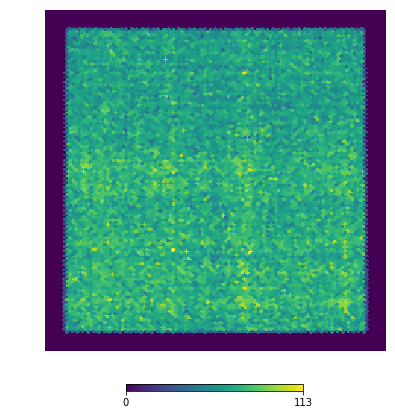

length phi:  519348


In [7]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra)):
    theta.append(np.radians(90. - dec[i]))
    phi.append(np.radians(ra[i]))
    
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_, xsize=225, rot=(-116.5, 9), flip='geo', cmap='viridis', notext=True, title="")
# plt.rcParams.update({'font.size':20})
# plt.savefig('/Users/mtownsend/Desktop/survey-density.jpg')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/HEALPix-survey-density-v2.pdf')
plt.show()

print('length phi: ', len(phi))

# Convert angles theta and phi to pixel numbers

pixnums = hp.ang2pix(nside, theta, phi, nest=True)


In [8]:
distance = 0.5 # must be in Mpc

distance_kpc, near, gal_tree, dist, index, nn1 = nearNeighbor(distance, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, zmag_LRG, zmag_BKG, rzcolor_LRG, rzcolor_BKG, grcolor_LRG, grcolor_BKG, nouse_edges)

print('end nearNeighbor')


end nearNeighbor


mean number of near neighbors is 40.39001645639056
median number of near neighbors is 35.0
standard deviation of near neighbor is 18.40651012779864
standard error is 0.43121838409045327


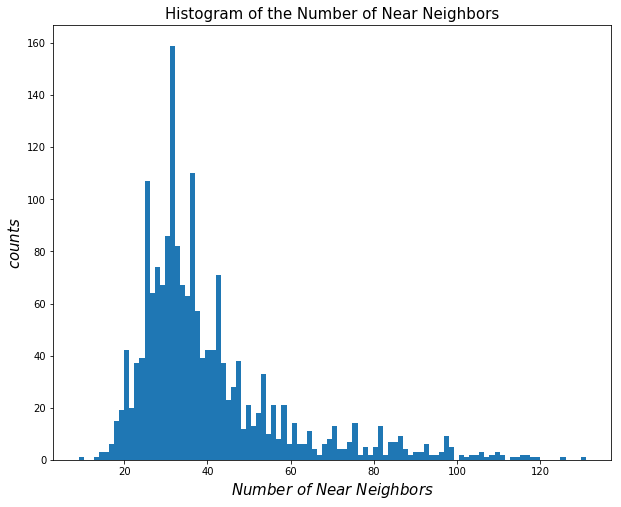

In [9]:
totalNear(near)

plt.show()

In [10]:
inner_dist = 0.4 # in deg
outer_dist = 0.5 # in deg

Nbkg, indices, omega, localBKG = localBKG_and_interlopersHEALPix(nside, inner_dist, outer_dist, ra_LRG, dec_LRG, pixnums, zmag, rzcolor, grcolor, nouse_edges, distance_kpc, kpc_DA)

omega = np.array(omega)

print("end bkg")

end bkg


mean number of interlopers is 36.48255219857938
median number of interlopers is 31.97099693085639
standard deviation of interloper is 17.121693151858256
standard error is 0.4011183435955279


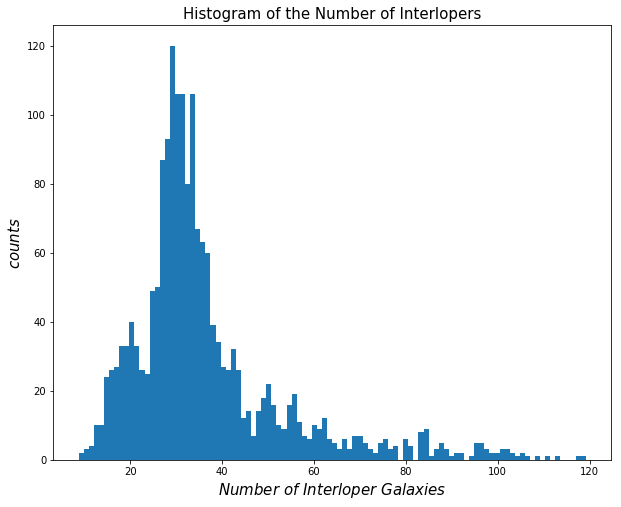

In [11]:
totalNbkg(Nbkg)

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/20Aug2020/Nbkg_random_hist.pdf')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/20Aug2020/Nbkg_hist.pdf')

plt.show()

Nbkg = np.array(Nbkg)

In [12]:
Nsat = np.array(near) - np.array(Nbkg)

print(Nsat[0].shape)
print("end Nsat")

(49, 49, 49)
end Nsat


mean number of satellites is 10.89370429239975
median number of satellites is 8.594618015771367
standard deviation of satellites is 16.107462370334577
standard error is 0.37735745923087477


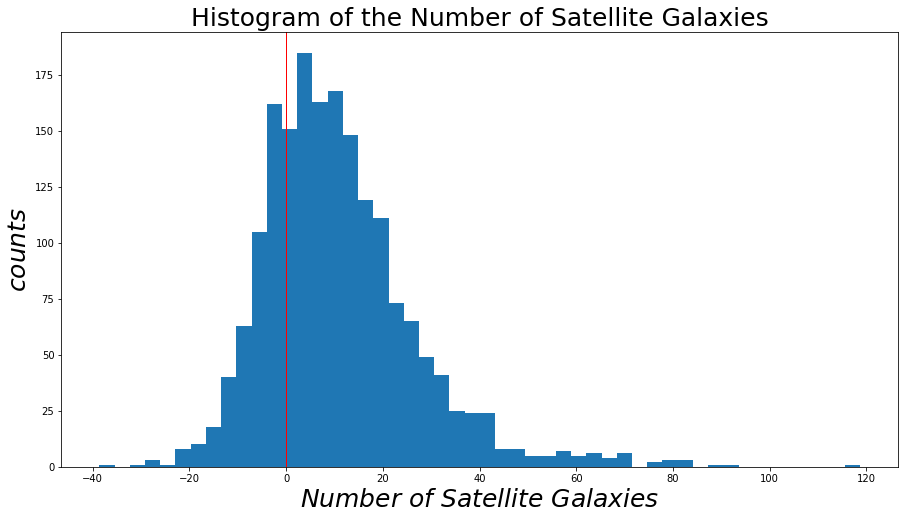

In [35]:
from lrg_plot_functions import *

totalNsat(Nsat)

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/20Aug2020/Nsat_random_hist.pdf')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/20Aug2020/Nsat_hist.pdf')

plt.show()

In [13]:
print(Nsat.shape)

Nsat25 = Nsat[np.where((z_LRG >= 0.2) & (z_LRG < 0.25))]
Nsat03 = Nsat[np.where((z_LRG >= 0.25) & (z_LRG < 0.3))]
Nsat35 = Nsat[np.where((z_LRG >= 0.3) & (z_LRG < 0.35))]
Nsat04 = Nsat[np.where((z_LRG >= 0.35) & (z_LRG < 0.4))]
Nsat45 = Nsat[np.where((z_LRG >= 0.4) & (z_LRG < 0.45))]
Nsat05 = Nsat[np.where((z_LRG >= 0.45) & (z_LRG < 0.5))]
Nsat55 = Nsat[np.where((z_LRG >= 0.5) & (z_LRG < 0.55))]
Nsat06 = Nsat[np.where((z_LRG >= 0.55) & (z_LRG < 0.6))]
Nsat65 = Nsat[np.where((z_LRG >= 0.6) & (z_LRG <= 0.65))]


print(Nsat25.shape)
print(Nsat03.shape)
print(Nsat35.shape)
print(Nsat04.shape)
print(Nsat45.shape)
print(Nsat05.shape)
print(Nsat55.shape)
print(Nsat06.shape)
print(Nsat65.shape)

zinit = 0.2
zfin = 0.65
interval = 0.05
# num = (zfin-zinit)/interval
num = 10. 
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)

(1823, 49, 49, 49)
(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)
(386, 49, 49, 49)
(325, 49, 49, 49)
(186, 49, 49, 49)


In [14]:
def totalNsat(Nsat, lum, z1, z2):

    import matplotlib.pylab as plt 	
    import numpy as np
    from scipy import stats
    
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height


    sumsat = []

    # Sum up number of satellite galaxies for every LRG
    for i in range(len(Nsat)):
        sumsat.append(np.sum(Nsat[i]))

    meansat = np.mean(sumsat)
    print("mean number of satellites is", meansat)
    
    mediansat = np.median(sumsat)
    print("median number of satellites is", mediansat)

    sdsat = np.std(sumsat)
    print("standard deviation of satellites is", sdsat)

    sterr = stats.sem(sumsat)
    print("standard error is", sterr)

    plt.rcParams["figure.figsize"] = [15, 8]
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     plt.title("Histogram of the Number of Satellite Galaxies; log(lum)=10.36; 0.55 < z < 0.6", fontsize=25)
    plt.title("Histogram of the Number of Satellite Galaxies; log(lum)={}; {} < z < {}".format(lum, z1, z2), fontsize=20)
    plt.hist(sumsat, bins=50)
    plt.axvline(linewidth=1, color='r')
    plt.xlabel(r'$Number$ $of$ $Satellite$ $Galaxies$', fontsize=25)
    plt.ylabel(r'$counts$', fontsize=25)
    plt.text(top, right,'mean = {}'.format(meansat), fontsize=14, ha='center', va='center', transform=ax.transAxes)
    plt.text(top, right-0.05,'median = {}'.format(mediansat), fontsize=14, ha='center', va='center', transform=ax.transAxes)
    plt.text(top, right-0.1,'stdev = {}'.format(sdsat), fontsize=14, ha='center', va='center', transform=ax.transAxes)
    # plt.show()
    return(mediansat)

In [15]:
# read in selection matrices for each luminosity selected sample 

data_smatrix03 = np.load('/Users/mtownsend/Desktop/lowz_smatrix-2matrices.npz')
smatrix03 = data_smatrix03['smatrix_low']
print(smatrix03.shape)

data_smatrix04 = np.load('/Users/mtownsend/Desktop/midz1_smatrix-4matrices.npz')
smatrix04 = data_smatrix04['smatrix_low']
print(smatrix04.shape)

data_smatrix05 = np.load('/Users/mtownsend/Desktop/midz2_smatrix-6matrices.npz')
smatrix05 = data_smatrix05['smatrix_low']
print(smatrix05.shape)

data_smatrix06 = np.load('/Users/mtownsend/Desktop/midz3_smatrix-8matrices.npz')
smatrix06 = data_smatrix06['smatrix_low']
print(smatrix06.shape)

data_smatrix65 = np.load('/Users/mtownsend/Desktop/highz_smatrix-9matrices.npz')
smatrix65 = data_smatrix65['smatrix_low']
print(smatrix65.shape)


(2, 49, 49, 49)
(4, 49, 49, 49)
(6, 49, 49, 49)
(8, 49, 49, 49)
(9, 49, 49, 49)


In [16]:
# make new Nsat for log(lum)=9.55; 0.2 < z < 0.3

# 0.2 < z < 0.25
lowz_newNsat25 = []
for i in range(len(Nsat25)):
    lowz_newNsat25.append(Nsat25[i] * smatrix03[0])
    
# 0.25 < z < 0.3
lowz_newNsat03 = []
for i in range(len(Nsat03)):
    lowz_newNsat03.append(Nsat03[i] * smatrix03[1])

print(np.asarray(lowz_newNsat25).shape)
print(np.asarray(lowz_newNsat03).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)


mean number of satellites is 0.003218686891358597
median number of satellites is -0.3553242593436041
standard deviation of satellites is 0.6897806544250803
standard error is 0.07311660313599846


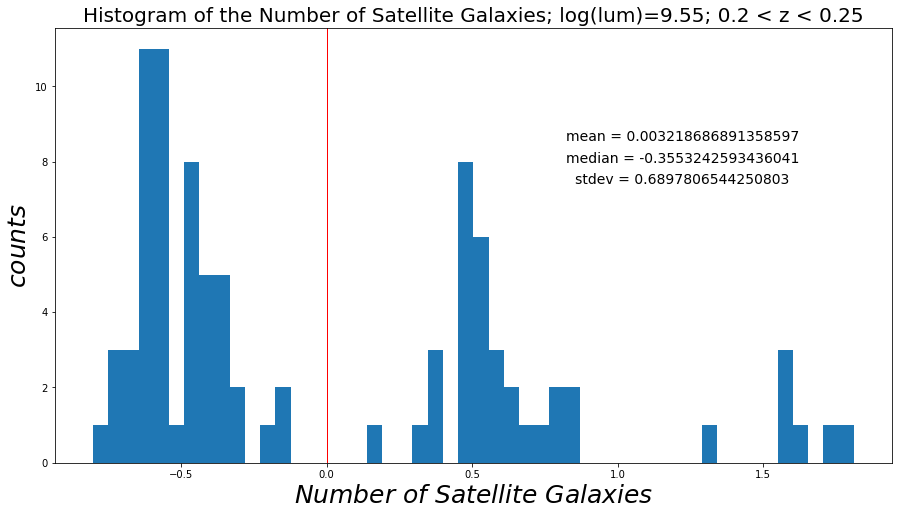

mean number of satellites is 0.14072557828808707
median number of satellites is 0.02106613712327987
standard deviation of satellites is 1.005544897790545
standard error is 0.11104385759978548


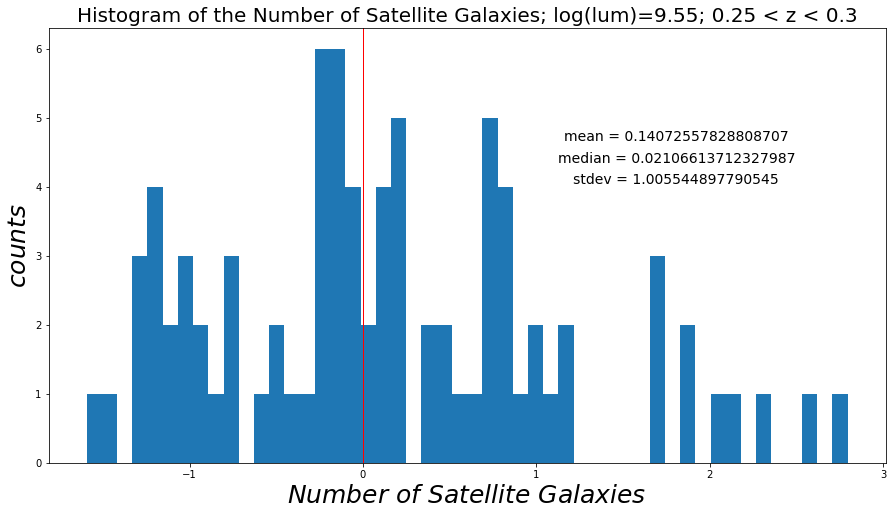

In [17]:
totalNsat(lowz_newNsat25, 9.55, round(zrange[0], 2), round(zrange[1], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/lowz_random_maskedNsat25.pdf')
plt.show()

totalNsat(lowz_newNsat03, 9.55, round(zrange[1], 2), round(zrange[2], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/lowz_random_maskedNsat03.pdf')
plt.show()

In [18]:
# make new Nsat for log(lum)=9.84; 0.2 < z < 0.4

# 0.2 < z < 0.25
midz1_newNsat25 = []
for i in range(len(Nsat25)):
    midz1_newNsat25.append(Nsat25[i] * smatrix04[0])
    
# 0.25 < z < 0.3
midz1_newNsat03 = []
for i in range(len(Nsat03)):
    midz1_newNsat03.append(Nsat03[i] * smatrix04[1])
    
# 0.3 < z < 0.35
midz1_newNsat35 = []
for i in range(len(Nsat35)):
    midz1_newNsat35.append(Nsat35[i] * smatrix04[2])
    
# 0.35 < z < 0.4
midz1_newNsat04 = []
for i in range(len(Nsat04)):
    midz1_newNsat04.append(Nsat04[i] * smatrix04[3])


print(np.asarray(midz1_newNsat25).shape)
print(np.asarray(midz1_newNsat03).shape)
print(np.asarray(midz1_newNsat35).shape)
print(np.asarray(midz1_newNsat04).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)


mean number of satellites is -0.019088555931758993
median number of satellites is -0.25553296510061396
standard deviation of satellites is 0.5245623746810882
standard error is 0.055603500509305535


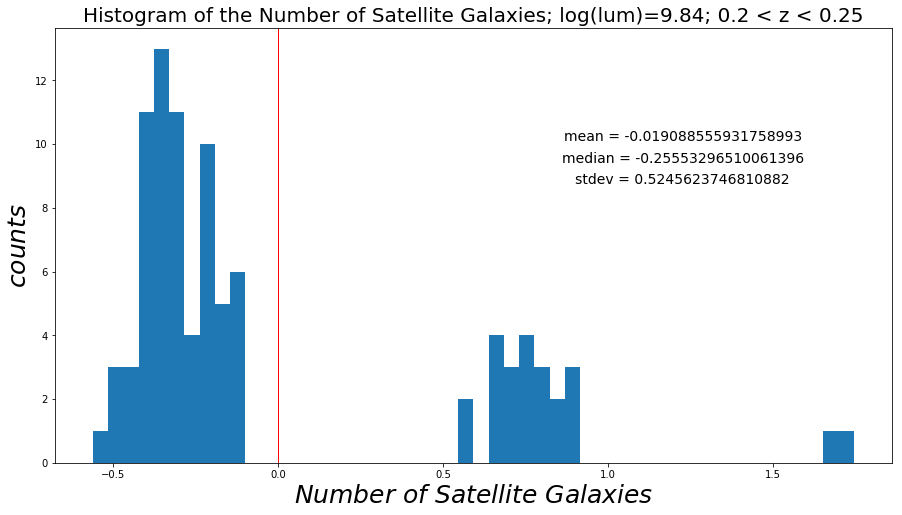

mean number of satellites is -0.0022420355275754467
median number of satellites is -0.26325675523500486
standard deviation of satellites is 0.5092194407655065
standard error is 0.0562338799507148


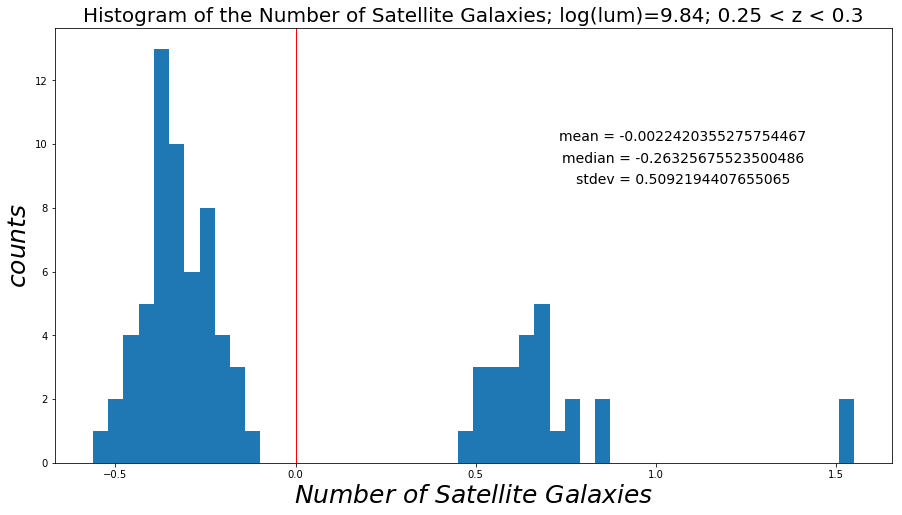

mean number of satellites is 0.06443603996970804
median number of satellites is -0.029101518040311386
standard deviation of satellites is 1.0133957430395741
standard error is 0.08721921857577249


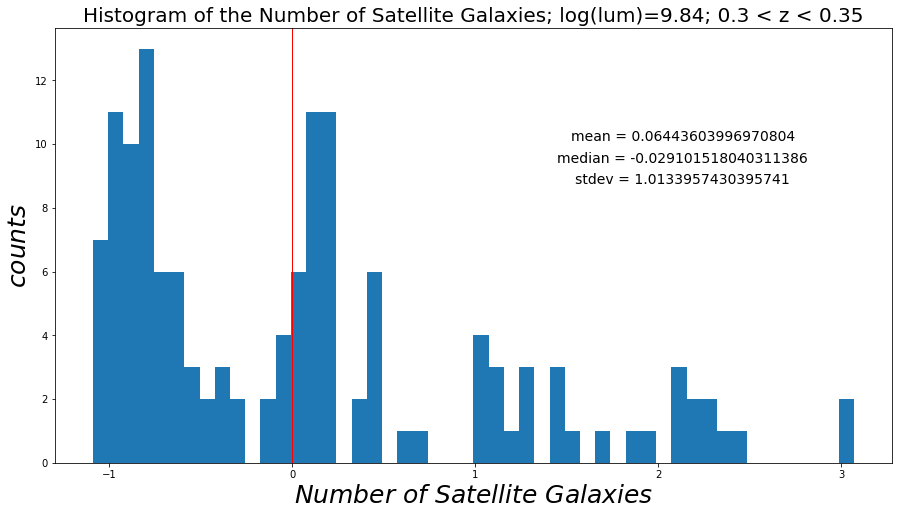

mean number of satellites is 0.11186581875685245
median number of satellites is -0.049983755150140696
standard deviation of satellites is 1.1559399895926055
standard error is 0.10257308742593932


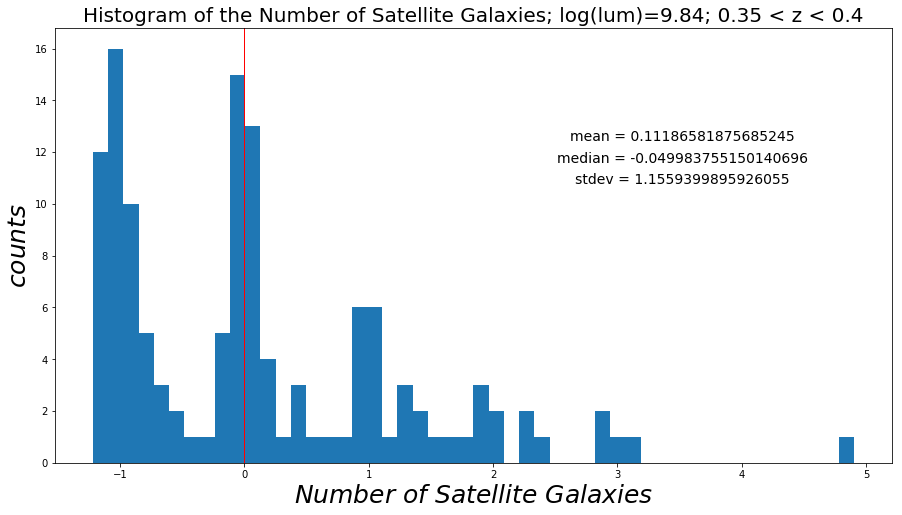

In [19]:
totalNsat(midz1_newNsat25, 9.84, round(zrange[0], 2), round(zrange[1], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz1_random_maskedNsat25.pdf')
plt.show()

totalNsat(midz1_newNsat03, 9.84, round(zrange[1], 2), round(zrange[2], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz1_random_maskedNsat03.pdf')
plt.show()

totalNsat(midz1_newNsat35, 9.84, round(zrange[2], 2), round(zrange[3], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz1_random_maskedNsat35.pdf')
plt.show()

totalNsat(midz1_newNsat04, 9.84, round(zrange[3], 2), round(zrange[4], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz1_random_maskedNsat04.pdf')
plt.show()

In [20]:
# make new Nsat for log(lum)=10.13; 0.2 < z < 0.5

# 0.2 < z < 0.25
midz2_newNsat25 = []
for i in range(len(Nsat25)):
    midz2_newNsat25.append(Nsat25[i] * smatrix05[0])
    
# 0.25 < z < 0.3
midz2_newNsat03 = []
for i in range(len(Nsat03)):
    midz2_newNsat03.append(Nsat03[i] * smatrix05[1])
    
# 0.3 < z < 0.35
midz2_newNsat35 = []
for i in range(len(Nsat35)):
    midz2_newNsat35.append(Nsat35[i] * smatrix05[2])
    
# 0.35 < z < 0.4
midz2_newNsat04 = []
for i in range(len(Nsat04)):
    midz2_newNsat04.append(Nsat04[i] * smatrix05[3])
    
# 0.4 < z < 0.45
midz2_newNsat45 = []
for i in range(len(Nsat45)):
    midz2_newNsat45.append(Nsat45[i] * smatrix05[4])
    
# 0.45 < z < 0.5
midz2_newNsat05 = []
for i in range(len(Nsat05)):
    midz2_newNsat05.append(Nsat05[i] * smatrix05[5])


print(np.asarray(midz2_newNsat25).shape)
print(np.asarray(midz2_newNsat03).shape)
print(np.asarray(midz2_newNsat35).shape)
print(np.asarray(midz2_newNsat04).shape)
print(np.asarray(midz2_newNsat45).shape)
print(np.asarray(midz2_newNsat05).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)


mean number of satellites is -0.006475824287550087
median number of satellites is -0.0402754231262398
standard deviation of satellites is 0.18277954288130005
standard error is 0.019374592796270962


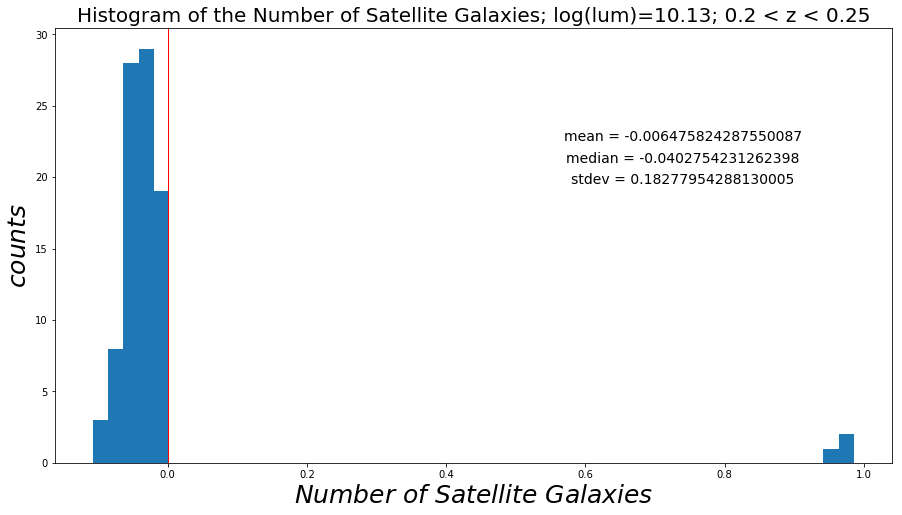

mean number of satellites is -0.018867567339730704
median number of satellites is -0.05896774509176829
standard deviation of satellites is 0.21255240435778766
standard error is 0.023472486384108354


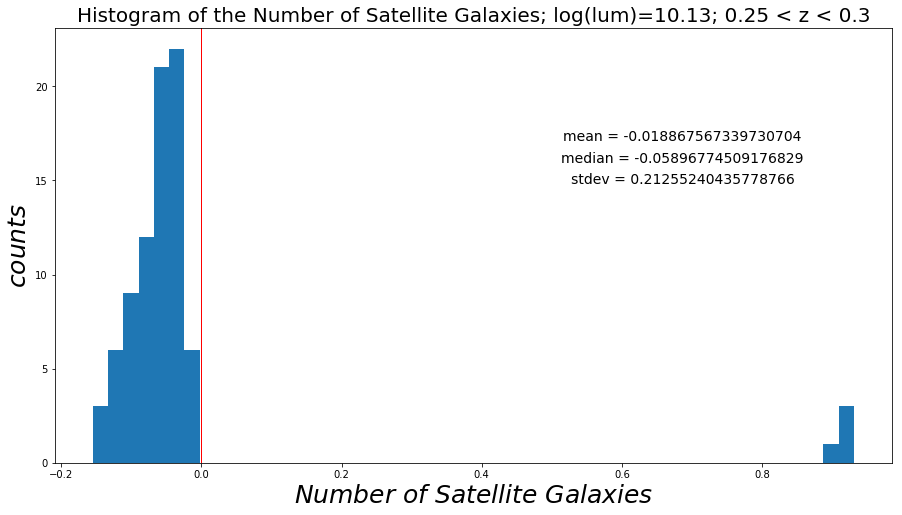

mean number of satellites is 0.0007755985234388909
median number of satellites is -0.1814285293928759
standard deviation of satellites is 0.45040244991994244
standard error is 0.038764470836243486


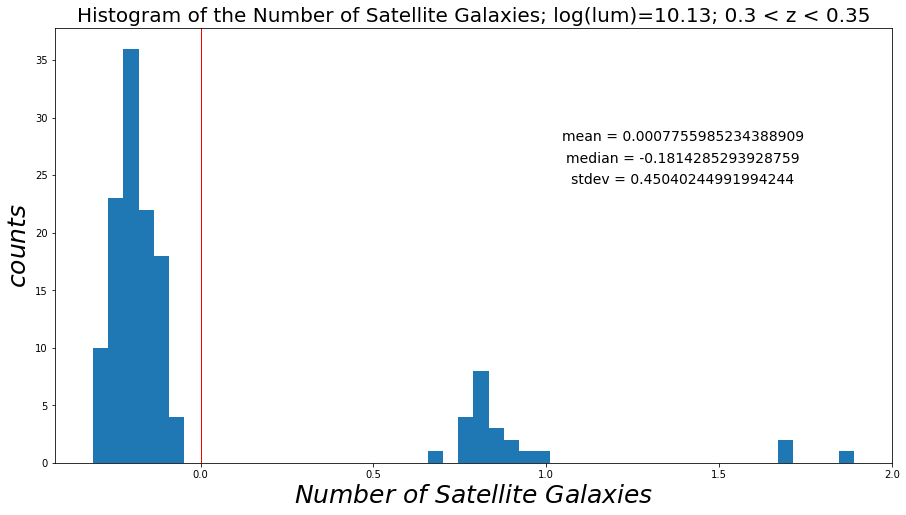

mean number of satellites is 0.04703229016930345
median number of satellites is -0.3028268120595643
standard deviation of satellites is 0.6838762552696829
standard error is 0.06068420467486689


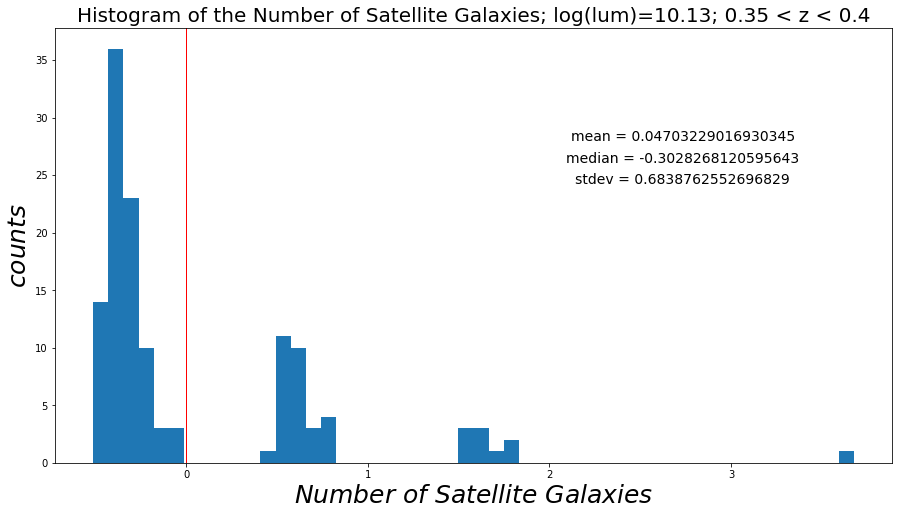

mean number of satellites is -0.01511955232781351
median number of satellites is -0.3835498575550645
standard deviation of satellites is 0.7052343943273921
standard error is 0.05271169349359496


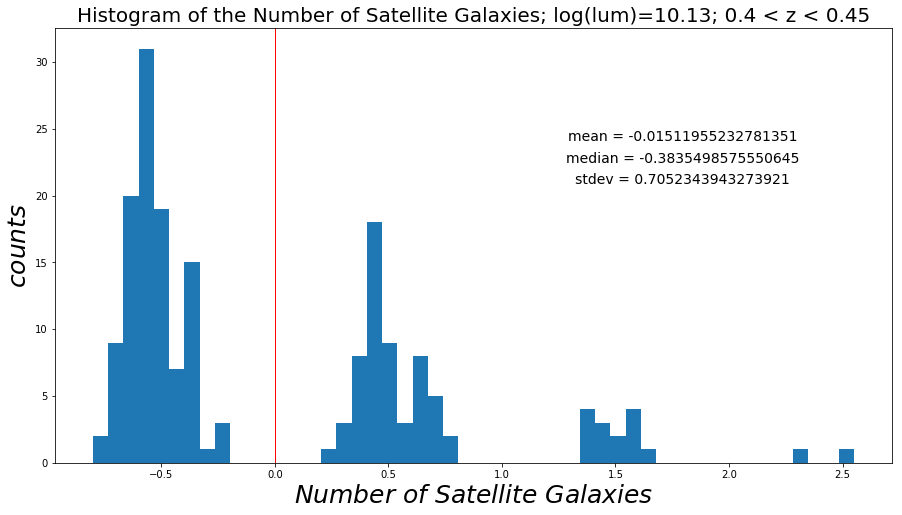

mean number of satellites is -0.055804472344172365
median number of satellites is -0.2681700100127252
standard deviation of satellites is 0.7547629252158845
standard error is 0.0430066090239824


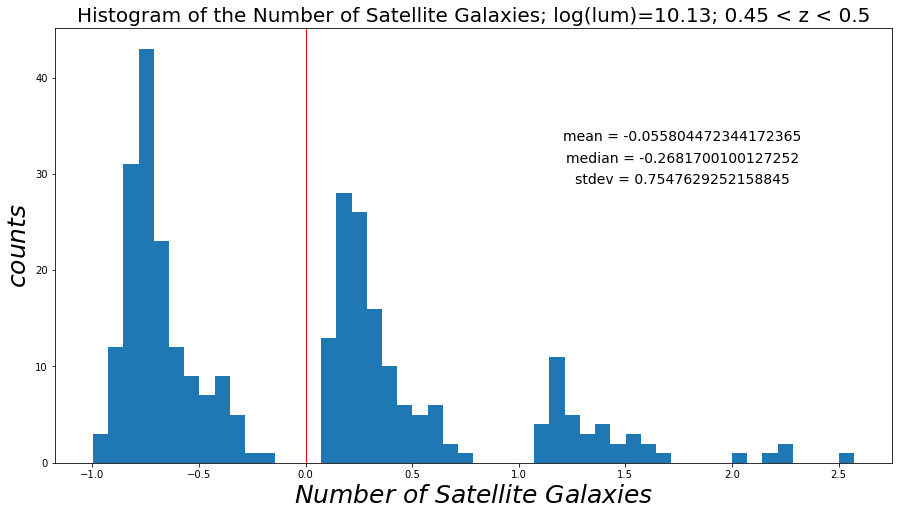

In [21]:
totalNsat(midz2_newNsat25, 10.13, round(zrange[0], 2), round(zrange[1], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz2_random_maskedNsat25.pdf')
plt.show()

totalNsat(midz2_newNsat03, 10.13, round(zrange[1], 2), round(zrange[2], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz2_random_maskedNsat03.pdf')
plt.show()

totalNsat(midz2_newNsat35, 10.13, round(zrange[2], 2), round(zrange[3], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz2_random_maskedNsat35.pdf')
plt.show()

totalNsat(midz2_newNsat04, 10.13, round(zrange[3], 2), round(zrange[4], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz2_random_maskedNsat04.pdf')
plt.show()

totalNsat(midz2_newNsat45, 10.13, round(zrange[4], 2), round(zrange[5], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz2_random_maskedNsat45.pdf')
plt.show()

totalNsat(midz2_newNsat05, 10.13, round(zrange[5], 2), round(zrange[6], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz2_random_maskedNsat05.pdf')
plt.show()

In [22]:
# make new Nsat for log(lum)=10.36; 0.2 < z < 0.6

# 0.2 < z < 0.25
midz3_newNsat25 = []
for i in range(len(Nsat25)):
    midz3_newNsat25.append(Nsat25[i] * smatrix06[0])
    
# 0.25 < z < 0.3
midz3_newNsat03 = []
for i in range(len(Nsat03)):
    midz3_newNsat03.append(Nsat03[i] * smatrix06[1])
    
# 0.3 < z < 0.35
midz3_newNsat35 = []
for i in range(len(Nsat35)):
    midz3_newNsat35.append(Nsat35[i] * smatrix06[2])
    
# 0.35 < z < 0.4
midz3_newNsat04 = []
for i in range(len(Nsat04)):
    midz3_newNsat04.append(Nsat04[i] * smatrix06[3])
    
# 0.4 < z < 0.45
midz3_newNsat45 = []
for i in range(len(Nsat45)):
    midz3_newNsat45.append(Nsat45[i] * smatrix06[4])
    
# 0.45 < z < 0.5
midz3_newNsat05 = []
for i in range(len(Nsat05)):
    midz3_newNsat05.append(Nsat05[i] * smatrix06[5])
    
# 0.5 < z < 0.55
midz3_newNsat55 = []
for i in range(len(Nsat55)):
    midz3_newNsat55.append(Nsat55[i] * smatrix06[6])
    
# 0.55 < z < 0.6
midz3_newNsat06 = []
for i in range(len(Nsat06)):
    midz3_newNsat06.append(Nsat06[i] * smatrix06[7])


print(np.asarray(midz3_newNsat25).shape)
print(np.asarray(midz3_newNsat03).shape)
print(np.asarray(midz3_newNsat35).shape)
print(np.asarray(midz3_newNsat04).shape)
print(np.asarray(midz3_newNsat45).shape)
print(np.asarray(midz3_newNsat05).shape)
print(np.asarray(midz3_newNsat55).shape)
print(np.asarray(midz3_newNsat06).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)
(386, 49, 49, 49)
(325, 49, 49, 49)


mean number of satellites is -0.006424444916046022
median number of satellites is 0.0
standard deviation of satellites is 0.010908621891735816
standard error is 0.0011563116079030932


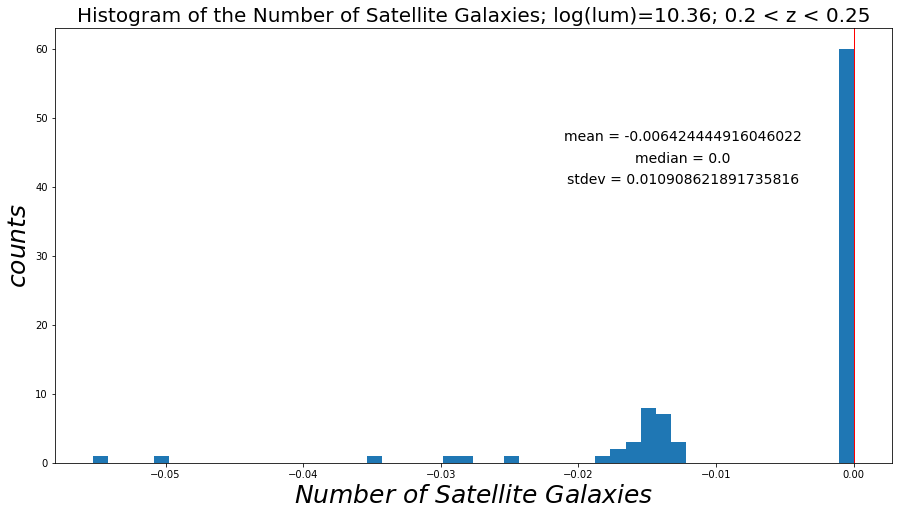

mean number of satellites is 0.0
median number of satellites is 0.0
standard deviation of satellites is 0.0
standard error is 0.0


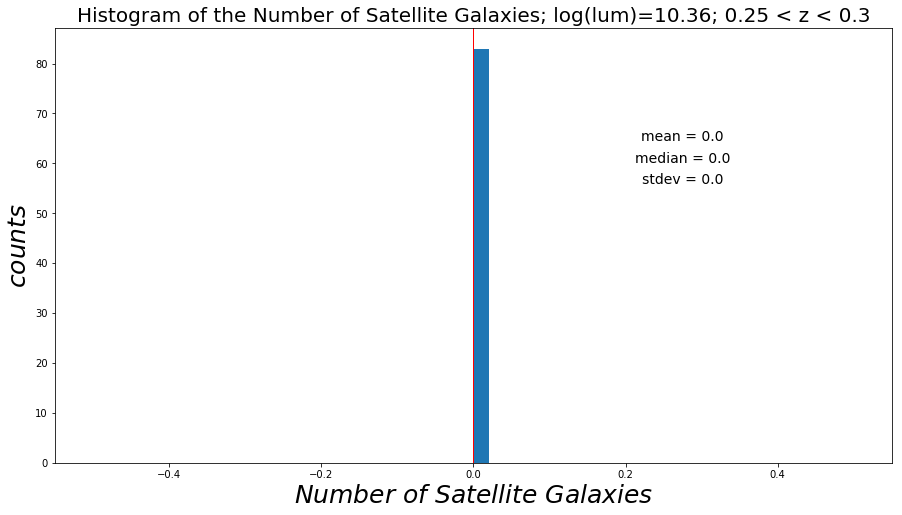

mean number of satellites is 0.013981461250344884
median number of satellites is -0.057792015655225515
standard deviation of satellites is 0.2652943496314935
standard error is 0.022832902177015606


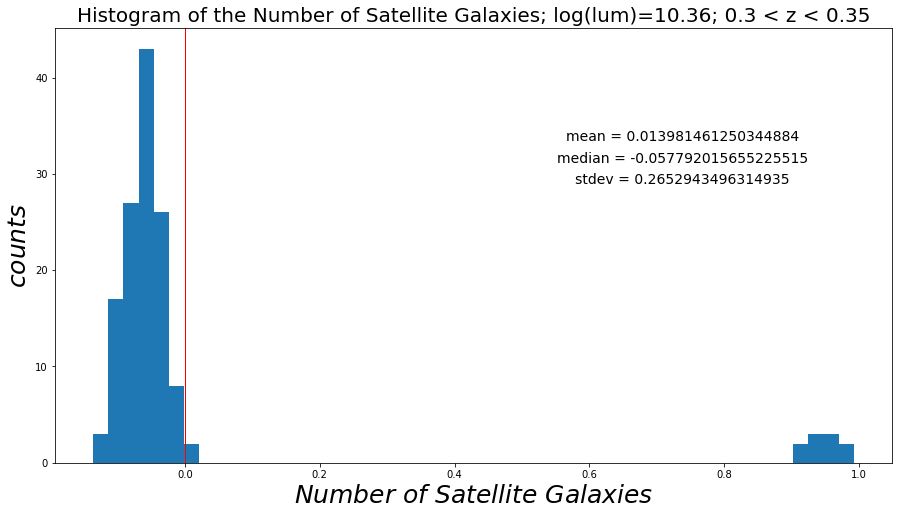

mean number of satellites is -0.0006033108753102333
median number of satellites is -0.1358938902233197
standard deviation of satellites is 0.3688756029869264
standard error is 0.03273241674752432


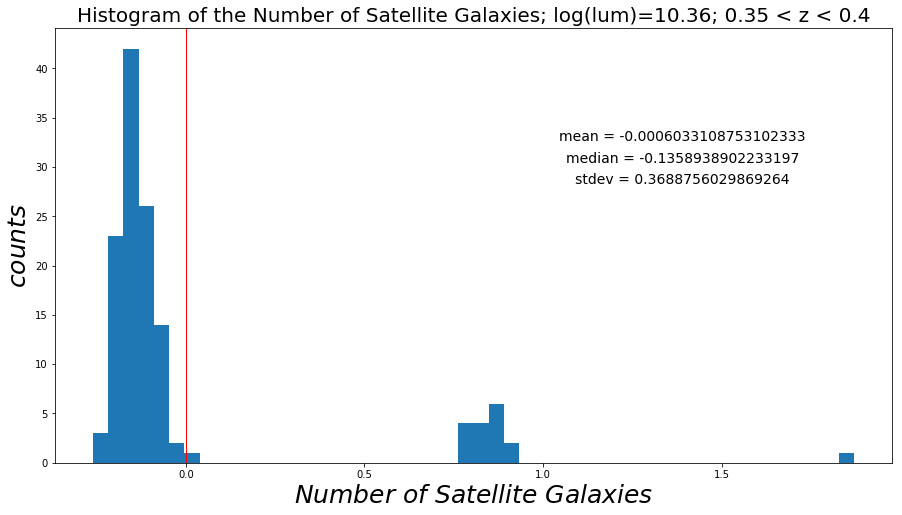

mean number of satellites is 0.0038793652245041697
median number of satellites is -0.19520508679323445
standard deviation of satellites is 0.42467970817264267
standard error is 0.03174205170678842


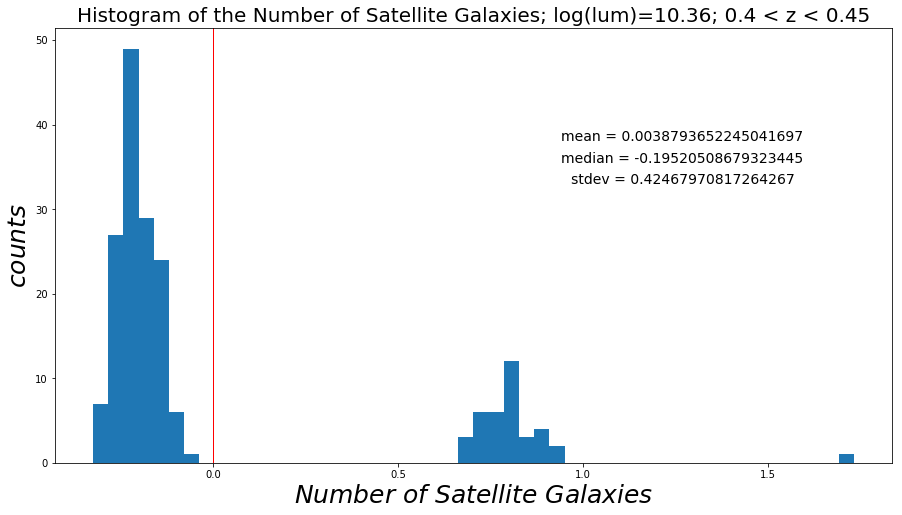

mean number of satellites is -0.04428807969720528
median number of satellites is -0.3099622358152262
standard deviation of satellites is 0.5525966926862282
standard error is 0.031487118824105986


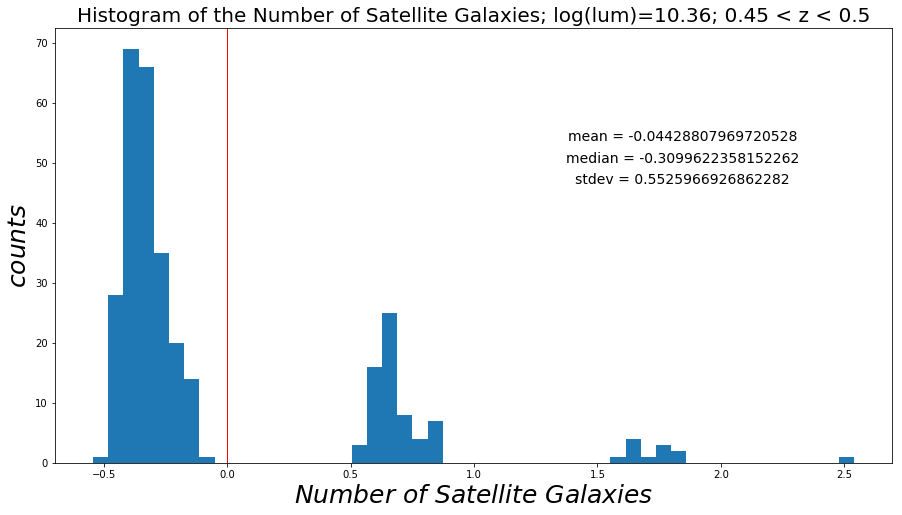

mean number of satellites is 0.0734147959812411
median number of satellites is -0.29273947028574776
standard deviation of satellites is 0.781110479936554
standard error is 0.03980907623021606


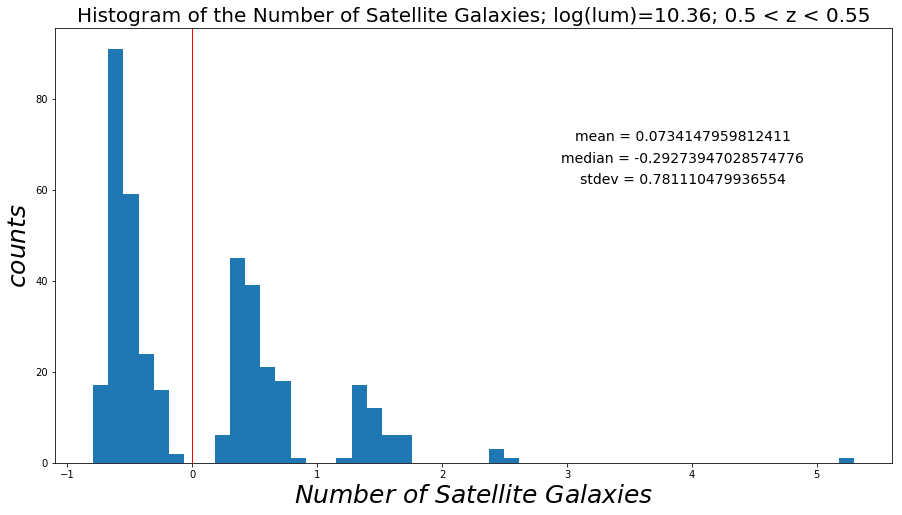

mean number of satellites is 0.05743968610293546
median number of satellites is -0.3745270235178164
standard deviation of satellites is 0.8791717116202602
standard error is 0.048842872867792236


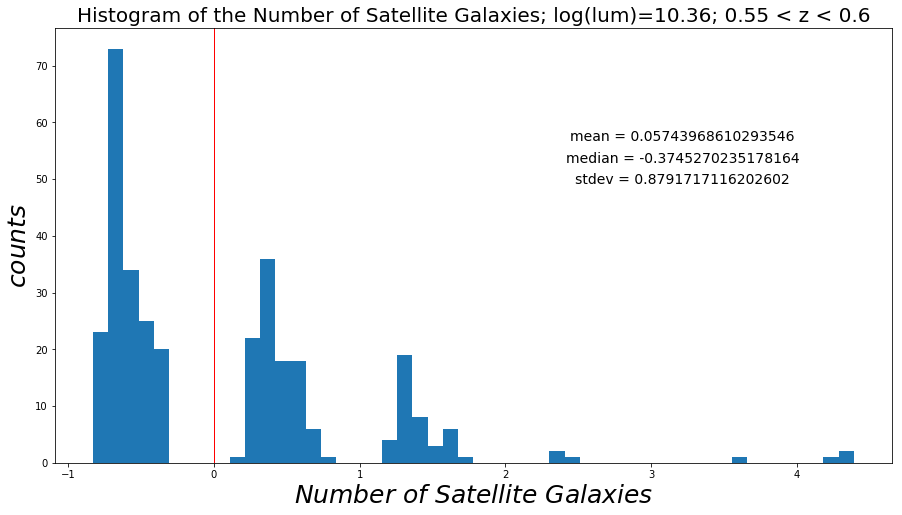

In [23]:
totalNsat(midz3_newNsat25, 10.36, round(zrange[0], 2), round(zrange[1], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat25.pdf')
plt.show()

totalNsat(midz3_newNsat03, 10.36, round(zrange[1], 2), round(zrange[2], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat03.pdf')
plt.show()

totalNsat(midz3_newNsat35, 10.36, round(zrange[2], 2), round(zrange[3], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat35.pdf')
plt.show()

totalNsat(midz3_newNsat04, 10.36, round(zrange[3], 2), round(zrange[4], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat04.pdf')
plt.show()

totalNsat(midz3_newNsat45, 10.36, round(zrange[4], 2), round(zrange[5], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat45.pdf')
plt.show()

totalNsat(midz3_newNsat05, 10.36, round(zrange[5], 2), round(zrange[6], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat05.pdf')
plt.show()

totalNsat(midz3_newNsat55, 10.36, round(zrange[6], 2), round(zrange[7], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat55.pdf')
plt.show()

totalNsat(midz3_newNsat06, 10.36, round(zrange[7], 2), round(zrange[8], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/midz3_random_maskedNsat06.pdf')
plt.show()

In [24]:
# make new Nsat for log(lum)=10.47; 0.2 < z < 0.65

# 0.2 < z < 0.25
highz_newNsat25 = []
for i in range(len(Nsat25)):
    highz_newNsat25.append(Nsat25[i] * smatrix65[0])
    
# 0.25 < z < 0.3
highz_newNsat03 = []
for i in range(len(Nsat03)):
    highz_newNsat03.append(Nsat03[i] * smatrix65[1])
    
# 0.3 < z < 0.35
highz_newNsat35 = []
for i in range(len(Nsat35)):
    highz_newNsat35.append(Nsat35[i] * smatrix65[2])
    
# 0.35 < z < 0.4
highz_newNsat04 = []
for i in range(len(Nsat04)):
    highz_newNsat04.append(Nsat04[i] * smatrix65[3])
    
# 0.4 < z < 0.45
highz_newNsat45 = []
for i in range(len(Nsat45)):
    highz_newNsat45.append(Nsat45[i] * smatrix65[4])
    
# 0.45 < z < 0.5
highz_newNsat05 = []
for i in range(len(Nsat05)):
    highz_newNsat05.append(Nsat05[i] * smatrix65[5])
    
# 0.5 < z < 0.55
highz_newNsat55 = []
for i in range(len(Nsat55)):
    highz_newNsat55.append(Nsat55[i] * smatrix65[6])
    
# 0.55 < z < 0.6
highz_newNsat06 = []
for i in range(len(Nsat06)):
    highz_newNsat06.append(Nsat06[i] * smatrix65[7])

# 0.6 < z < 0.65
highz_newNsat65 = []
for i in range(len(Nsat65)):
    highz_newNsat65.append(Nsat65[i] * smatrix65[8])


print(np.asarray(highz_newNsat25).shape)
print(np.asarray(highz_newNsat03).shape)
print(np.asarray(highz_newNsat35).shape)
print(np.asarray(highz_newNsat04).shape)
print(np.asarray(highz_newNsat45).shape)
print(np.asarray(highz_newNsat05).shape)
print(np.asarray(highz_newNsat55).shape)
print(np.asarray(highz_newNsat06).shape)
print(np.asarray(highz_newNsat65).shape)

(90, 49, 49, 49)
(83, 49, 49, 49)
(136, 49, 49, 49)
(128, 49, 49, 49)
(180, 49, 49, 49)
(309, 49, 49, 49)
(386, 49, 49, 49)
(325, 49, 49, 49)
(186, 49, 49, 49)


mean number of satellites is -0.006424444916046022
median number of satellites is 0.0
standard deviation of satellites is 0.010908621891735816
standard error is 0.0011563116079030932


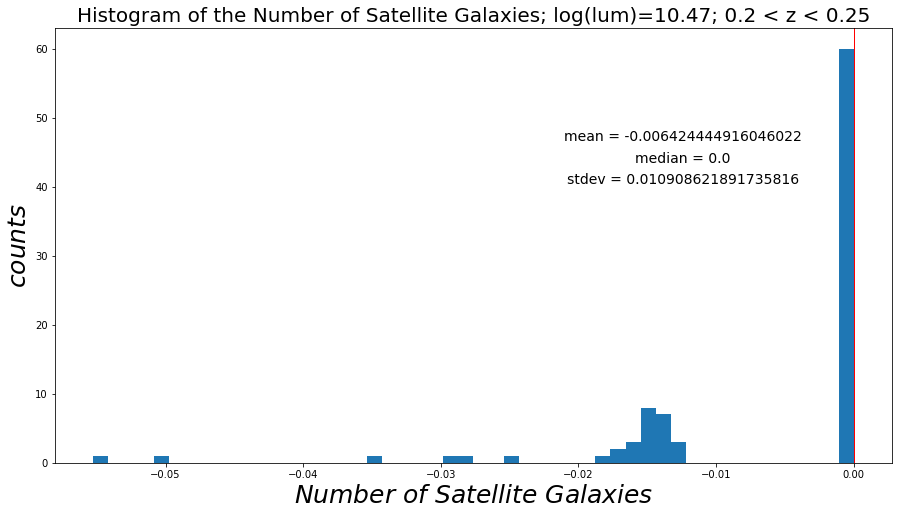

mean number of satellites is 0.0
median number of satellites is 0.0
standard deviation of satellites is 0.0
standard error is 0.0


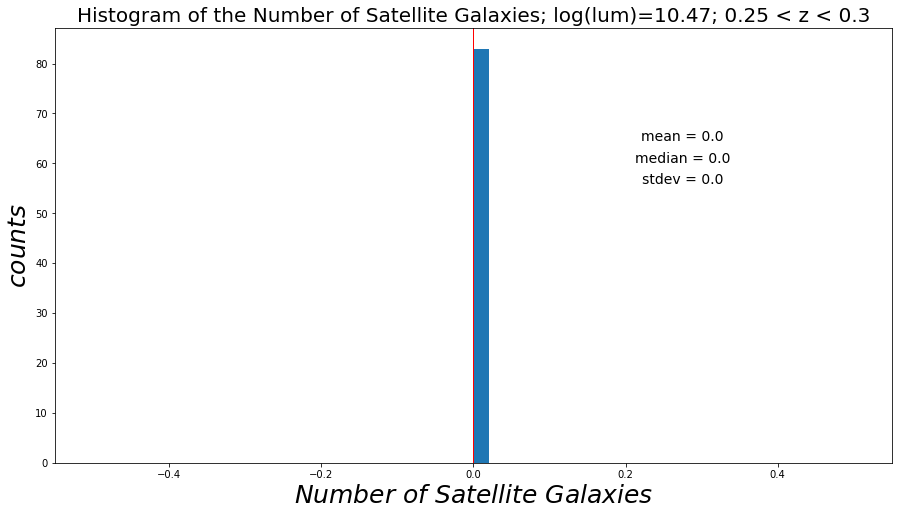

mean number of satellites is -0.010628320038729336
median number of satellites is -0.03702193069817742
standard deviation of satellites is 0.1713353017298192
standard error is 0.01474619489371139


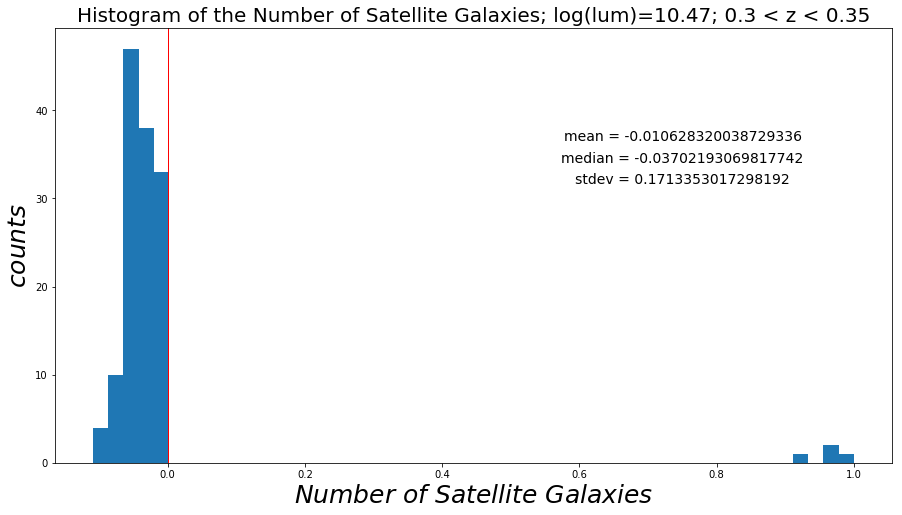

mean number of satellites is -0.022143410734644577
median number of satellites is -0.06263936628723607
standard deviation of satellites is 0.21277584473898817
standard error is 0.01888080308756535


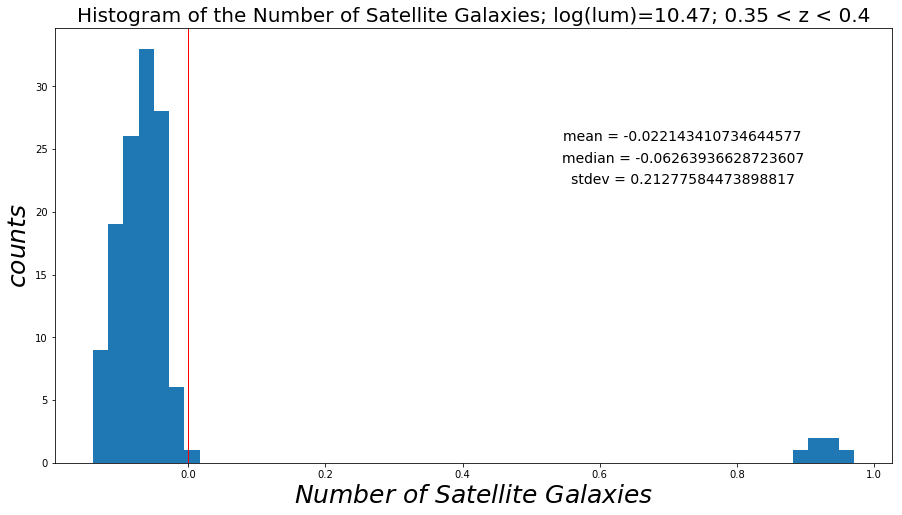

mean number of satellites is -0.02304270064032506
median number of satellites is -0.15922828340883166
standard deviation of satellites is 0.36592207132015503
standard error is 0.027350299731716057


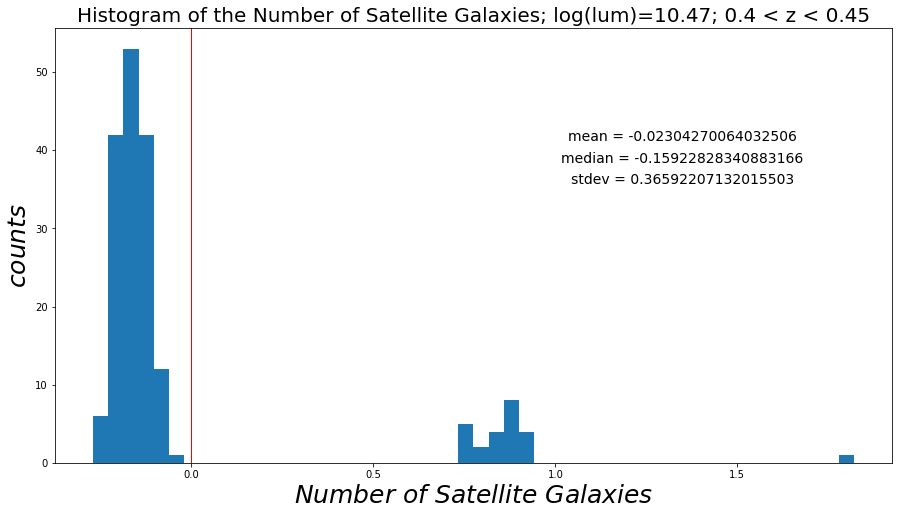

mean number of satellites is -0.036022498319909155
median number of satellites is -0.22306608283384932
standard deviation of satellites is 0.4499824658578113
standard error is 0.025640130602942762


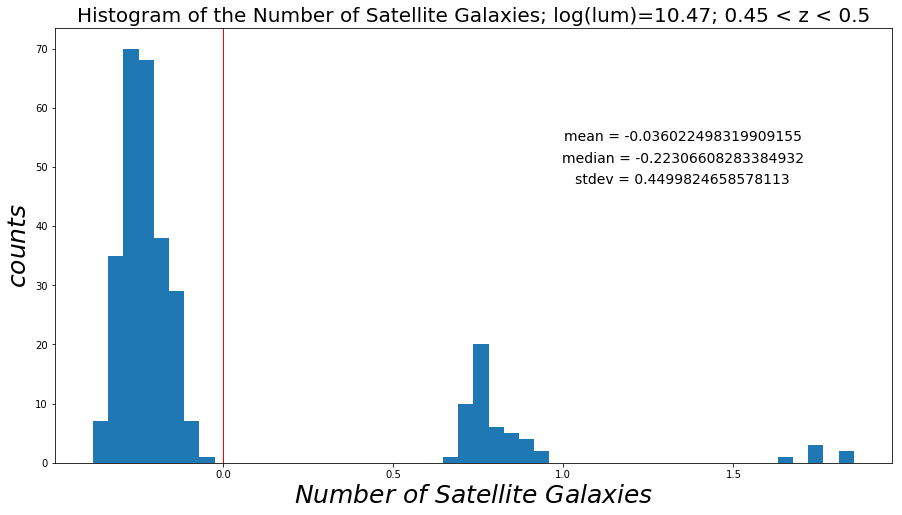

mean number of satellites is 0.040724690229526954
median number of satellites is -0.19581032825009492
standard deviation of satellites is 0.5066394766565104
standard error is 0.0258207386349419


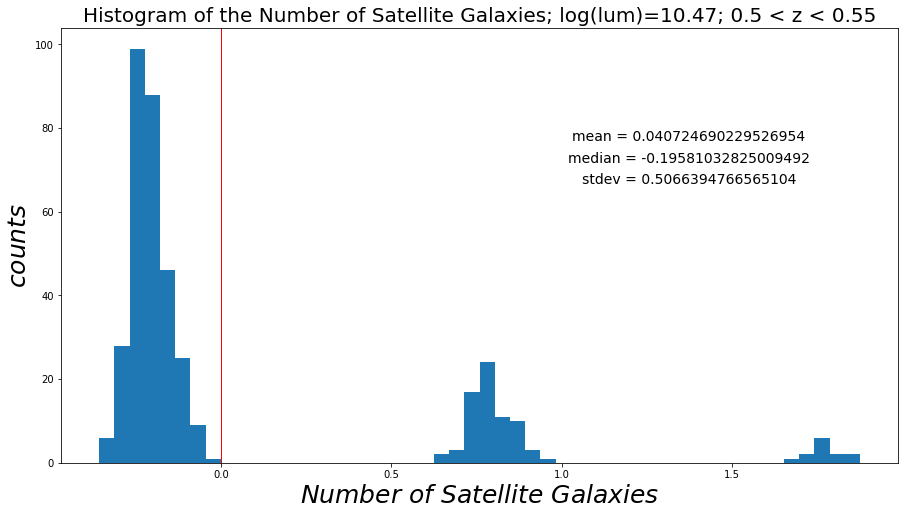

mean number of satellites is 0.046383161770955326
median number of satellites is -0.35945769952783685
standard deviation of satellites is 0.7993496583170282
standard error is 0.04440831435094601


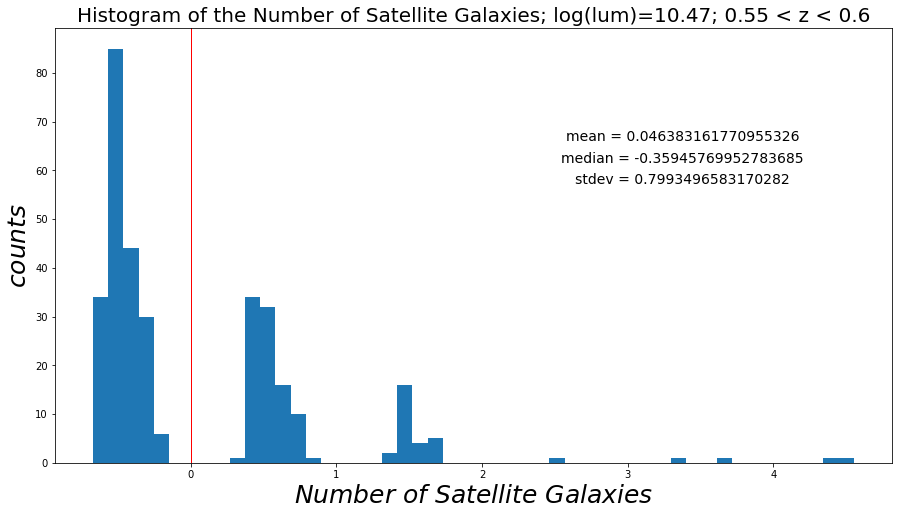

mean number of satellites is 0.010906998147441968
median number of satellites is -0.3135998387729416
standard deviation of satellites is 0.8156365981380785
standard error is 0.059966795326596635


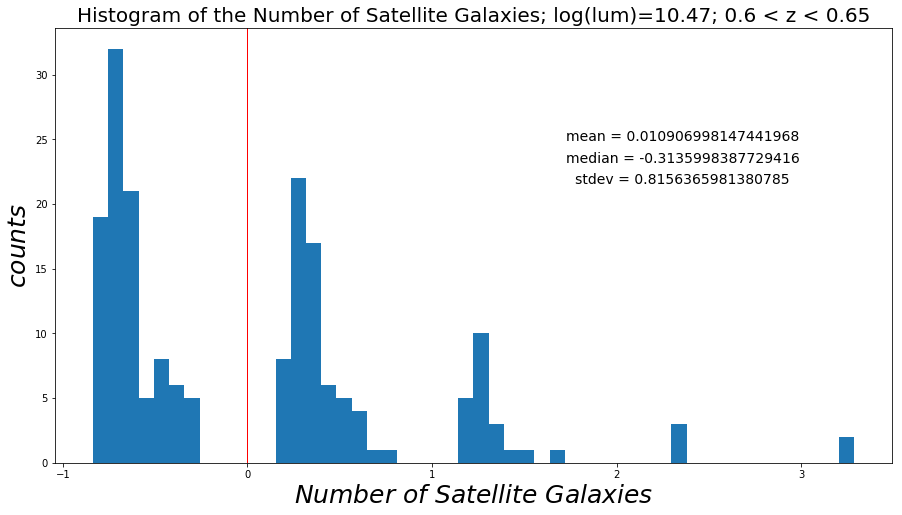

In [25]:
totalNsat(highz_newNsat25, 10.47, round(zrange[0], 2), round(zrange[1], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat25.pdf')
plt.show()

totalNsat(highz_newNsat03, 10.47, round(zrange[1], 2), round(zrange[2], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat03.pdf')
plt.show()

totalNsat(highz_newNsat35, 10.47, round(zrange[2], 2), round(zrange[3], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat35.pdf')
plt.show()

totalNsat(highz_newNsat04, 10.47, round(zrange[3], 2), round(zrange[4], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat04.pdf')
plt.show()

totalNsat(highz_newNsat45, 10.47, round(zrange[4], 2), round(zrange[5], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat45.pdf')
plt.show()

totalNsat(highz_newNsat05, 10.47, round(zrange[5], 2), round(zrange[6], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat05.pdf')
plt.show()

totalNsat(highz_newNsat55, 10.47, round(zrange[6], 2), round(zrange[7], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat55.pdf')
plt.show()

totalNsat(highz_newNsat06, 10.47, round(zrange[7], 2), round(zrange[8], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat06.pdf')
plt.show()

totalNsat(highz_newNsat65, 10.47, round(zrange[8], 2), round(zrange[9], 2))

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/11Sept2020/highz_random_maskedNsat65.pdf')
plt.show()

mean number of satellites is 3.9716210362598714
median number of satellites is 2.79595484839639
standard deviation of satellites is 9.87450221775567
standard error is 0.23133482993103638


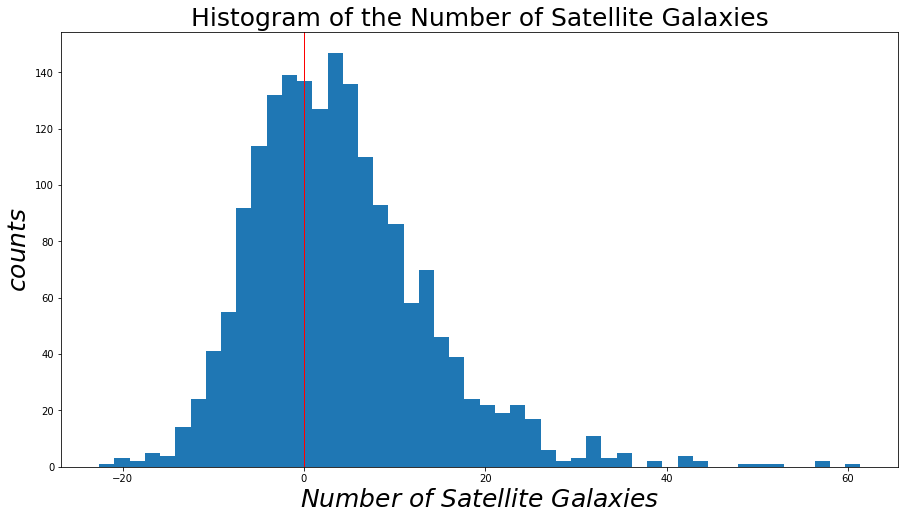

In [20]:
totalNsat(Nsat)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat.jpg')
plt.show()

In [25]:
# read in selection matrices

smatrix_low = np.load('/Users/mtownsend/Desktop/low-z-selection_matrix-v2.npz')
smatrix_mid1 = np.load('/Users/mtownsend/Desktop/middle-z-1-selection_matrix-v2.npz')
smatrix_mid2 = np.load('/Users/mtownsend/Desktop/middle-z-2-selection_matrix-v2.npz')
smatrix_high = np.load('/Users/mtownsend/Desktop/high-z-selection_matrix-v4.npz')

lowz_smatrix = smatrix_low['smatrix0']
midz1_smatrix = smatrix_mid1['smatrix1']
midz2_smatrix = smatrix_mid2['smatrix3']
highz_smatrix = smatrix_high['smatrix4']

print(lowz_smatrix.shape)
print(midz1_smatrix.shape)
print(midz2_smatrix.shape)
print(highz_smatrix.shape)

(49, 49, 49)
(49, 49, 49)
()
(49, 49, 49)


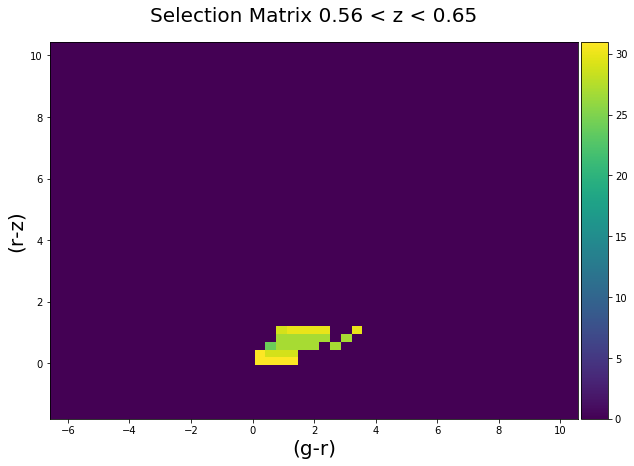

In [20]:
# data_smatrix = np.load('/Users/mtownsend/Desktop/low-z-selection_matrix-v3.npz')

# mask0 = data_smatrix['smatrix0']
# mask1 = data_smatrix['smatrix1']
# mask2 = data_smatrix['smatrix2']
# mask3 = data_smatrix['smatrix3']
# mask4 = data_smatrix['smatrix4']

# mega_mask = mask0 + mask1 + mask2 + mask3 + mask4

# projectionMask0 = mask0[:, :, :].sum(axis=2)
# projectionMask1 = mask1[:, :, :].sum(axis=2)
# projectionMask2 = mask2[:, :, :].sum(axis=2)
# projectionMask3 = mask3[:, :, :].sum(axis=2)
# projectionMask4 = mask4[:, :, :].sum(axis=2)

# projectionMegaMask = mega_mask[:, :, :].sum(axis=2)

lowz = lowz_smatrix[:, :, :].sum(axis=2)
midz1 = midz1_smatrix[:, :, :].sum(axis=2)
# midz2 = midz2_smatrix[:, :, :].sum(axis=2)
highz = highz_smatrix[:, :, :].sum(axis=2)

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(highz, origin='lower', extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Selection Matrix {0:.2f} < z < {1:.2f}".format(zrange[4], zrange[5]), fontsize=20, pad=20)
# ax.set_title("Selection Matrix", fontsize=20, pad=20)
ax.set_xlabel('(g-r)',fontsize=20)
ax.set_ylabel('(r-z)',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/low-z-selection_matrix_{0:.2f}-{1:.2f}.pdf'.format(zrange[4], zrange[5]))   
plt.show()


(1823, 49, 49, 49)
mean number of satellites is 0.3691627977154566
median number of satellites is 0.01391443266735215
standard deviation of satellites is 1.6286522835443922
standard error is 0.038155239699380915


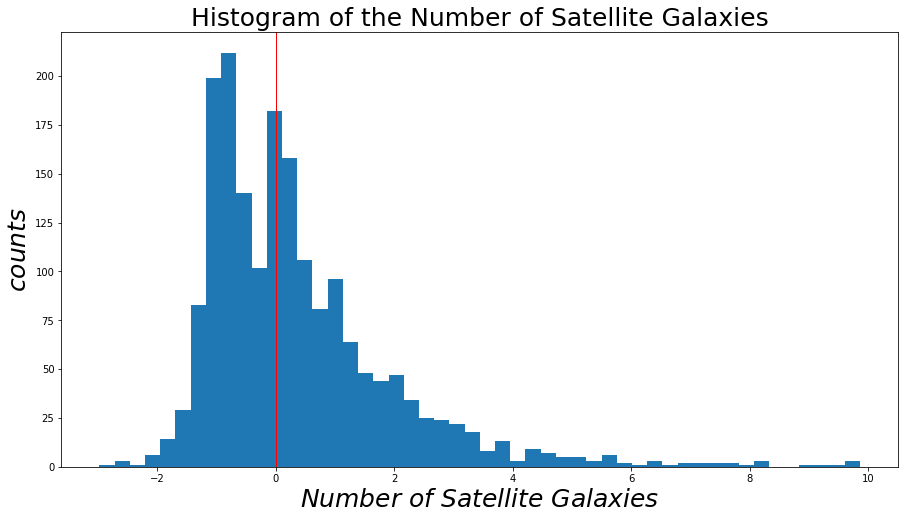

In [67]:
# data_masks = np.load('/Users/mtownsend/Desktop/high-z-selection_matrix-v2.npz')
# # print(len(data_masks))
# smatrix = data_masks['smatrix']
# print(Nsat[0].shape)

# projectionNsat = Nsat[:, :, : , :].sum(axis=0)

lowzNsat = Nsat[np.where((z_LRG > 0.2) & (z_LRG < 0.3))]
midz1Nsat = Nsat[np.where((z_LRG > 0.2) & (z_LRG < 0.4))]
midz2Nsat = Nsat[np.where((z_LRG > 0.2) & (z_LRG < 0.55))]
highzNsat = Nsat

newNsat = []
for i in range(len(highzNsat)):
    newNsat.append(highzNsat[i] * highz_smatrix)

print(np.asarray(newNsat).shape)

totalNsat(newNsat)

plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/06Aug2020/highz_maskedNsat.jpg')
plt.show()

In [22]:
# make a dictionary of Nsat in different redshift slices

# defines redshift slices
zinit = 0.2
zfin = 0.65
interval = 0.075
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

NsatDict = {}
keys = range(len(zrange)-1)
for i in keys:
    NsatDict[i] = Nsat[np.where((z_LRG > zrange[i]) & (z_LRG < zrange[i+1]))]
#     Dict[i] = zrange[i]

# maskDict = {}
# for i in range(len(zrange)-1):
#     maskDict[i] = masks[i]

print(len(NsatDict))
# print(len(maskDict))

# print(len(data_smatrix))
print(len(NsatDict[0]))
print(len(NsatDict[1]))
print(len(NsatDict[2]))
print(len(NsatDict[3]))
print(len(NsatDict[4]))
print(len(Nsat))

print(len(NsatDict[0]) + len(NsatDict[1]) + len(NsatDict[2]) + len(NsatDict[3]) + len(NsatDict[4]))

[0.2  0.29 0.38 0.47 0.56 0.65]
5
165
229
332
680
417
1823
1823


In [24]:
data_smatrix = np.load('/Users/mtownsend/Desktop/selection_matrix-v6.npz')

newNsat = {}
for i in range(len(NsatDict)):
    newNsat[i] = NsatDict[i] * data_smatrix['smatrix']
    
print(len(newNsat[0]))
print(len(newNsat[1]))
print(len(newNsat[2]))
print(len(newNsat[3]))
print(len(newNsat[4]))
# print(len(newNsat[5]))
# print(len(newNsat[6]))
# print(len(newNsat[7]))

    
# maskedNsat = []
# for i in range(len(newNsat)):
#     for j in range(len(NsatDict[i])):
#         maskedNsat.append(newNsat[i][j])
    
# print(len(maskedNsat))

165
229
332
680
417


In [28]:
data_smatrix = np.load('/Users/mtownsend/Desktop/selection_matrix-v3.npz')
print(len(data_smatrix))

newNsat0 = []
for i in range(len(NsatDict[0])):
    newNsat0.append(NsatDict[0][i] * data_smatrix['smatrix0'])
    
print(np.asarray(newNsat0).shape)
print(np.sum(newNsat0))
print(np.sum(NsatDict[0]))
    
newNsat1 = []
for i in range(len(NsatDict[1])):
    newNsat1.append(NsatDict[1][i] * data_smatrix['smatrix1'])
    
print(np.asarray(newNsat1).shape)
print(np.sum(newNsat1))
print(np.sum(NsatDict[1]))
    
newNsat2 = []
for i in range(len(NsatDict[2])):
    newNsat2.append(NsatDict[2][i] * data_smatrix['smatrix2'])
    
print(np.asarray(newNsat2).shape)
print(np.sum(newNsat2))
print(np.sum(NsatDict[2]))
    
newNsat3 = []
for i in range(len(NsatDict[3])):
    newNsat3.append(NsatDict[3][i] * data_smatrix['smatrix3'])
    
print(np.asarray(newNsat3).shape)
print(np.sum(newNsat3))
print(np.sum(NsatDict[3]))
    
newNsat4 = []
for i in range(len(NsatDict[4])):
    newNsat4.append(NsatDict[4][i] * data_smatrix['smatrix4'])
    
print(np.asarray(newNsat4).shape)
print(np.sum(newNsat4))
print(np.sum(NsatDict[4]))

# newNsat0 = NsatDict[0] * data_smatrix['smatrix0']
# newNsat1 = NsatDict[1] * data_smatrix['smatrix1']
# newNsat2 = NsatDict[2] * data_smatrix['smatrix2']
# newNsat3 = NsatDict[3] * data_smatrix['smatrix3']
# newNsat4 = NsatDict[4] * data_smatrix['smatrix4']

# print(len(newNsat0))
# print(len(newNsat1))
# print(len(newNsat2))
# print(len(newNsat3))
# print(len(newNsat4))


5
(165, 49, 49, 64)
-0.17004140895958217
3148.996723116617
(229, 49, 49, 64)
10.398667389853857
3567.84711675378
(332, 49, 49, 64)
-3.5393831348629834
3667.115789566212
(680, 49, 49, 64)
15.185330798117592
5731.716703893515
(417, 49, 49, 64)
70.44743391266906
3743.54659171462


In [ ]:
projectionNsat = Nsat[0][:, :, :].sum(axis=2) 

plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(projectionNsat, origin='lower') #, extent=(min(zmag_edges), max(zmag_edges), min(gr_edges), max(gr_edges)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("MASK AXIS 0")
#     ax.set_ylim([-0.6,5.5])
# ax.set_xlabel('zmag',fontsize=20)
# ax.set_ylabel('r-z',fontsize=20)
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/18June2020/mask2-axis0.pdf')   
plt.show()

In [46]:
totalNsat(maskedNsat)

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat.pdf')
plt.show()

NameError: name 'maskedNsat' is not defined

In [112]:
def totalNsat(Nsat):

	import matplotlib.pylab as plt 	
	import numpy as np
	from scipy import stats
	
	sumsat = []
	
	# Sum up number of satellite galaxies for every LRG
	for i in range(len(Nsat)):
		sumsat.append(np.sum(Nsat[i]))

	meansat = np.mean(sumsat)
	print("mean number of satellites is", meansat)
	
	mediansat = np.median(sumsat)
	print("median number of satellites is", mediansat)

	sdsat = np.std(sumsat)
	print("standard deviation of satellites is", sdsat)

	sterr = stats.sem(sumsat)
	print("standard error is", sterr)

	plt.rcParams["figure.figsize"] = [15, 8]
	plt.title("Histogram of the Number of Satellite Galaxies", fontsize=25)
	plt.hist(sumsat, bins=50)
	plt.axvline(linewidth=1, color='r')
	plt.xlabel(r'$Number$ $of$ $Satellite$ $Galaxies$', fontsize=25)
	plt.ylabel(r'$counts$', fontsize=25)
	# plt.show()
	return(mediansat)

# totalNsat(newNsat4)

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/16July2020/maskedNsat4.pdf')
# plt.show()

# totalNsat(NsatDict[4])

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/16July2020/Nsat4.pdf')

# plt.show()

# [0.2  0.29 0.38 0.47 0.56 0.65]

mean number of satellites is 12.296707362739133
median number of satellites is 9.754307090011256
standard deviation of satellites is 17.580467135393228
standard error is 1.372803844146683


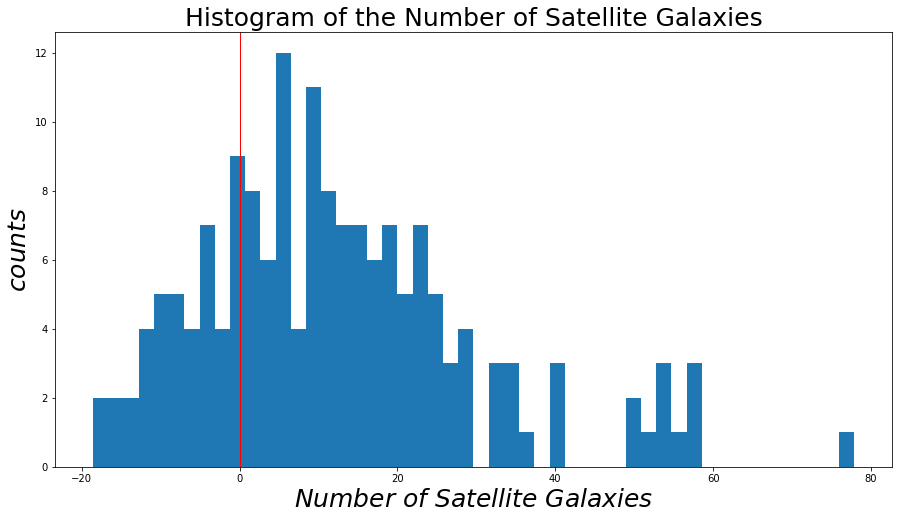

mean number of satellites is 19.084828624949218
median number of satellites is 17.470632471687793
standard deviation of satellites is 26.351336766216487
standard error is 2.057693696786782


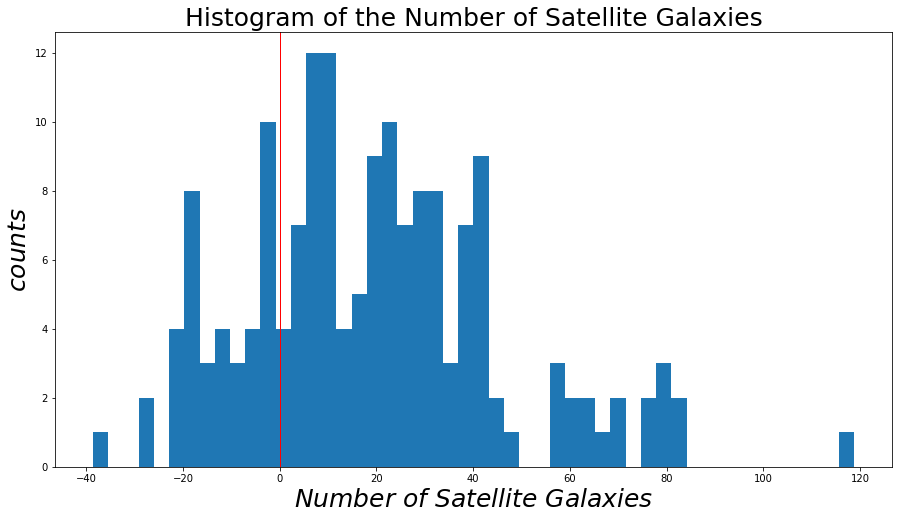

In [25]:
totalNsat(newNsat[0])

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat1.pdf')
plt.show()

totalNsat(NsatDict[0])
plt.show()

mean number of satellites is 9.476708355069977
median number of satellites is 8.110674236727247
standard deviation of satellites is 12.654066862257103
standard error is 0.8380360503762031


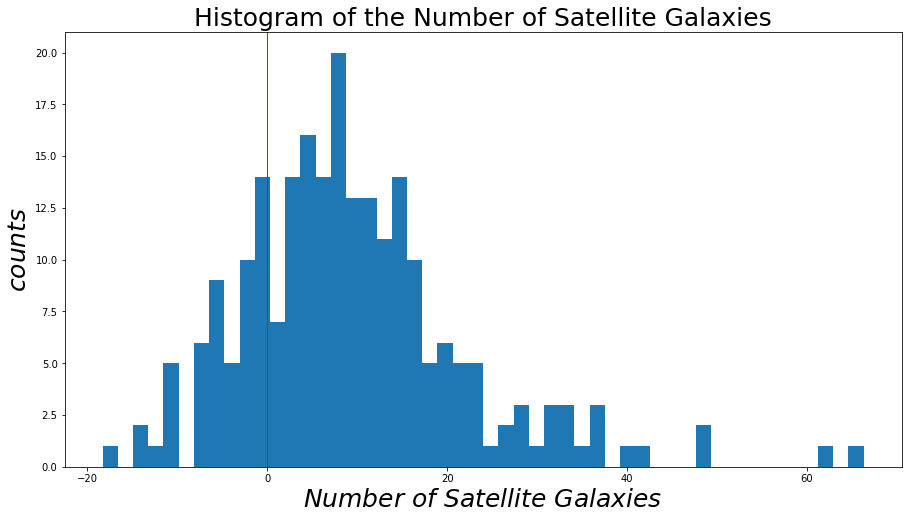

mean number of satellites is 15.580118413771949
median number of satellites is 12.284218536960212
standard deviation of satellites is 20.180059375916258
standard error is 1.3364570805447449


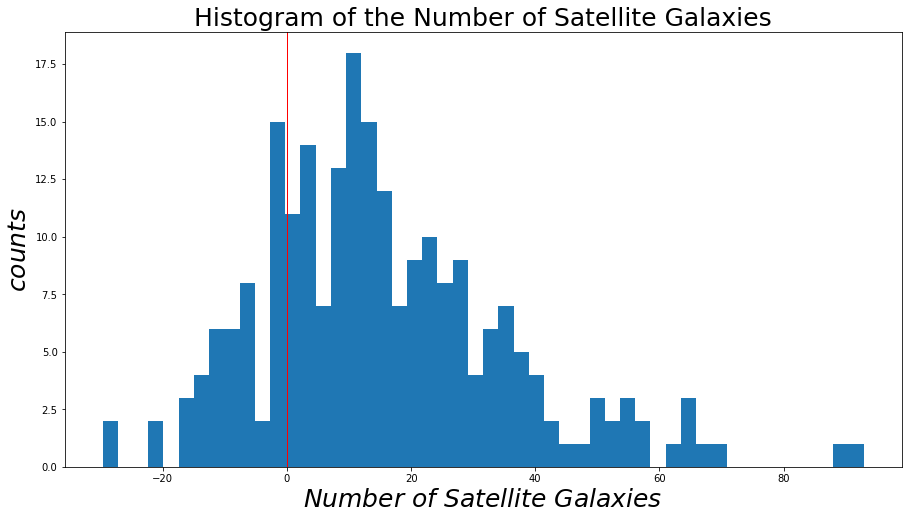

In [26]:
totalNsat(newNsat[1])

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat2.pdf')
plt.show()

totalNsat(NsatDict[1])
plt.show()

mean number of satellites is 6.711892607967446
median number of satellites is 4.6322610577702665
standard deviation of satellites is 10.166453066772837
standard error is 0.558798797916166


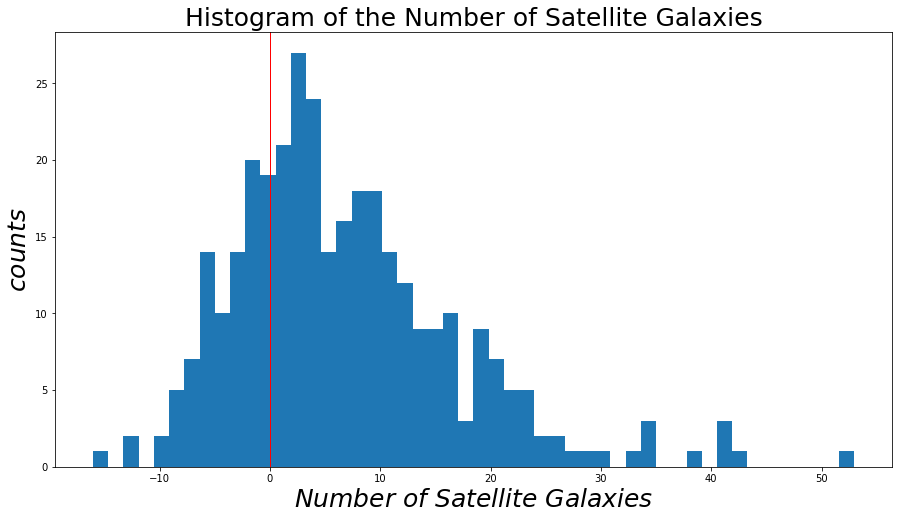

mean number of satellites is 11.045529486645183
median number of satellites is 8.18981529633988
standard deviation of satellites is 15.578056341669763
standard error is 0.8562474149461277


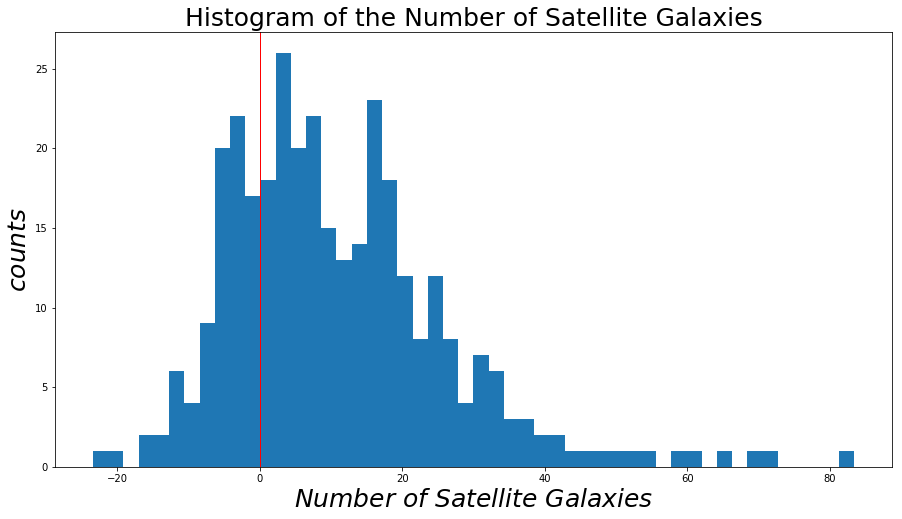

In [27]:
totalNsat(newNsat[2])

# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat3.pdf')
plt.show()

totalNsat(NsatDict[2])
plt.show()

mean number of satellites is 5.079187856298349
median number of satellites is 4.113565553253684
standard deviation of satellites is 8.17221961733981
standard error is 0.31362100490680384


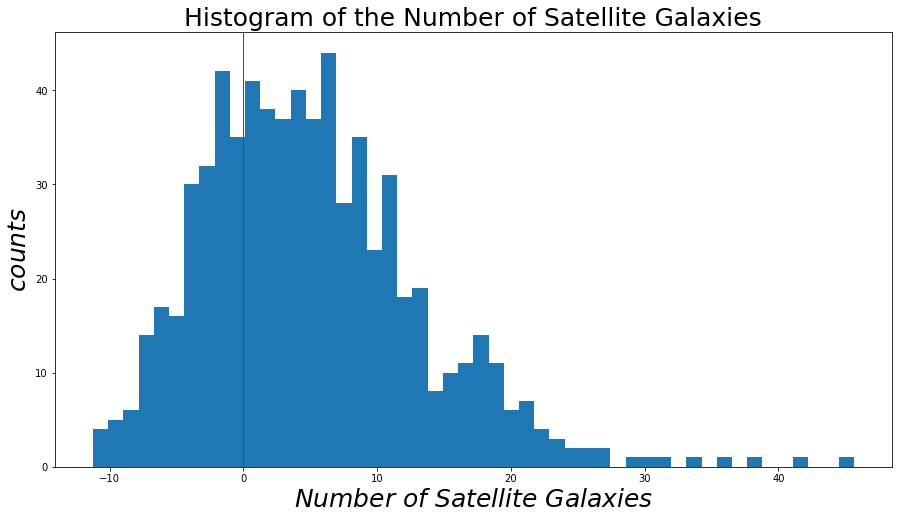

mean number of satellites is 8.428995152784601
median number of satellites is 7.09841291015176
standard deviation of satellites is 12.571445783003456
standard error is 0.48244781029029027


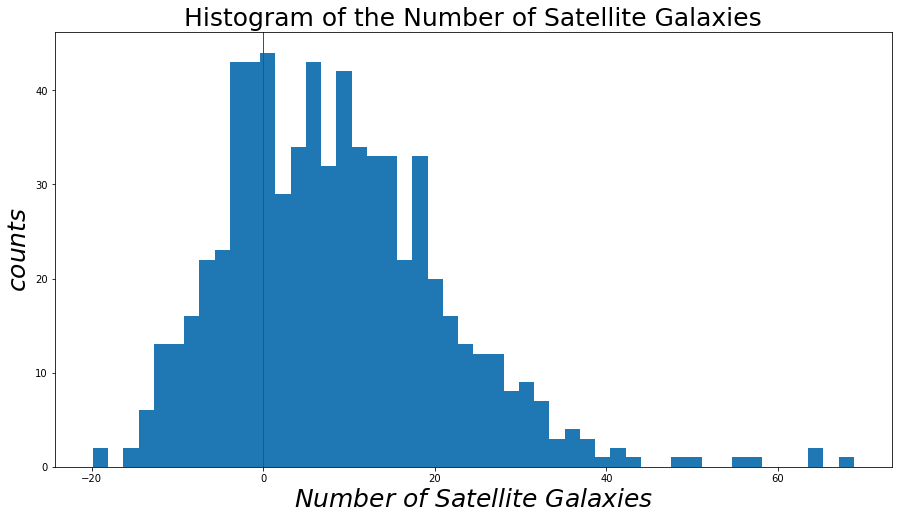

In [28]:
totalNsat(newNsat[3])
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat4.pdf')
plt.show()

totalNsat(NsatDict[3])
plt.show()

mean number of satellites is 5.236806061883095
median number of satellites is 4.00595746131272
standard deviation of satellites is 7.487091483538803
standard error is 0.36708486129441065


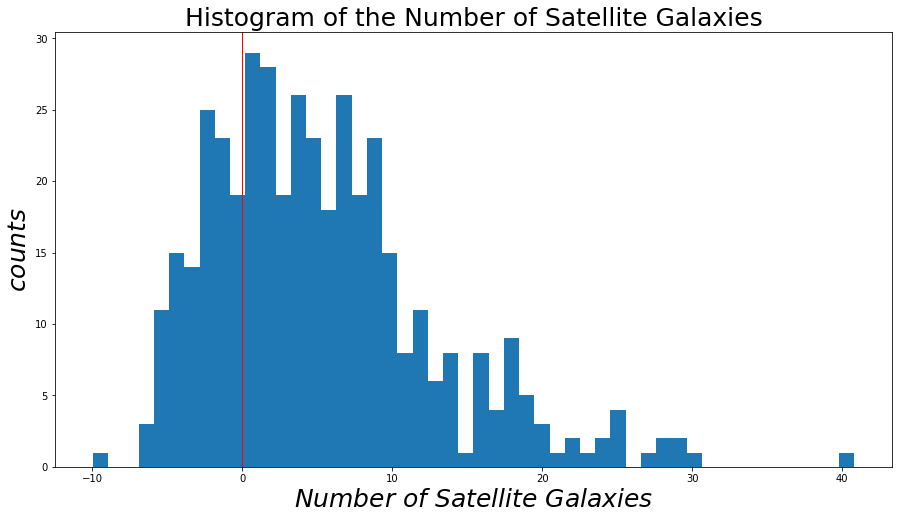

mean number of satellites is 8.977329956150166
median number of satellites is 7.372939694120299
standard deviation of satellites is 11.519975546946831
standard error is 0.5648132702884


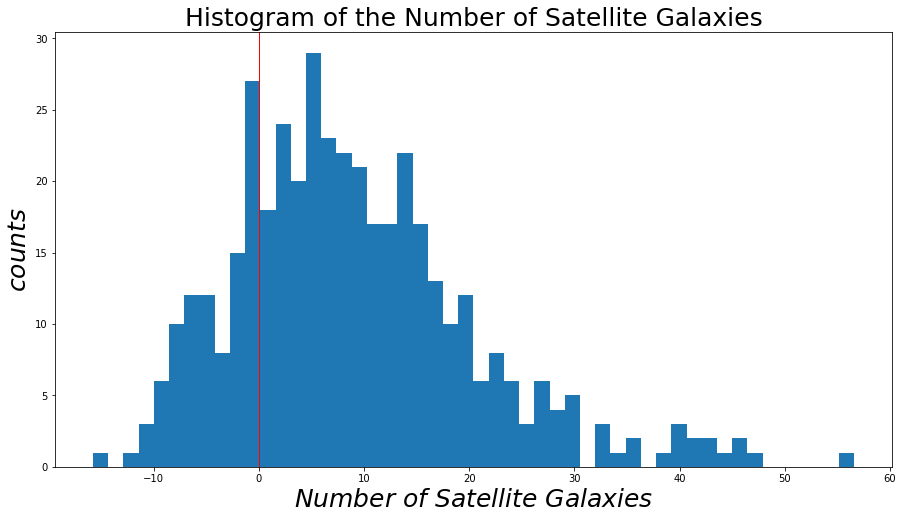

In [29]:
totalNsat(newNsat[4])
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/25June2020/maskedNsat4.pdf')
plt.show()

totalNsat(NsatDict[4])
plt.show()

In [131]:
def cmdHistograms(H, rz_edges, gr_edges, zrange1, zrange2):

    # This function plots a color-magnitude 2D histogram for satellites around LRG; produces a histogram for every LRG

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors

    plt.rcParams.update({'figure.max_open_warning': 0})

    rz_v_gr = list(np.zeros((49,49)))
    for i in range(len(H)):
        # make 2D projections of 3D histogram
        rz_v_gr = H[i][:, :, :].sum(axis=2)

        # plot 2D histograms using matshow; 3 plots per image
#         f, axarr = plt.subplots(111, figsize=(10, 10))
#         f.suptitle("Satellite Density CMD (LRG {})".format(i))

    plt.rcParams["figure.figsize"] = [10, 10]
    im1 = plt.imshow(rz_v_gr, origin='lower', cmap=plt.cm.viridis, norm=colors.Normalize(), extent=(gr_edges.min(), gr_edges.max(), rz_edges.min(), rz_edges.max()))
#     plt.scatter(zmag_LRG[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))], rzcolor_LRG[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))], s=4, color='red', label="LRG")
    plt.title("Color-Color Plot {0:.2f} < z < {1:.2f}".format(zrange1, zrange2), fontsize=20, pad=20)
    plt.colorbar(im1, orientation="vertical", fraction=0.037, pad=0.07)
#         s = 'LRG redshift: {0:.2f}'.format(z_LRG[i])
#         t = 'LRG coords: {:.2f}, {:.2f}'.format(ra_LRG[i], dec_LRG[i])
#         plt.text(16, -2, s, family='sans-serif', fontsize=14)
#         plt.text(16, -2.5, t, family='sans-serif', fontsize=14)
#         axarr[0].title("Satellite Color-Magnitude Diagram (LRG {})".format(i), fontsize=15)
    plt.xlabel(r'$(g-r)$', fontsize=20)
    plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
#     plt.legend(loc='upper right', prop={'size': 20}, markerscale=5.0)

        # save image with incrementing file name
#     plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/satHistCMD-zslice5.1_v4.pdf'.format(i))
#     plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/2July2020/satellite-color-color-{}.pdf'.format(i))    
#     plt.show()
    
# cmdHistograms(Nsat_zcut1, edges)
# cmdHistograms(Nsat_zcut2, edges)
# cmdHistograms(Nsat_zcut3, edges)
# cmdHistograms(Nsat_zcut4, edges)
# cmdHistograms(Nsat_zcut5, edges)


# sns.jointplot(Nsat_zcut5, edges, kind="hex", color="#4CB391")


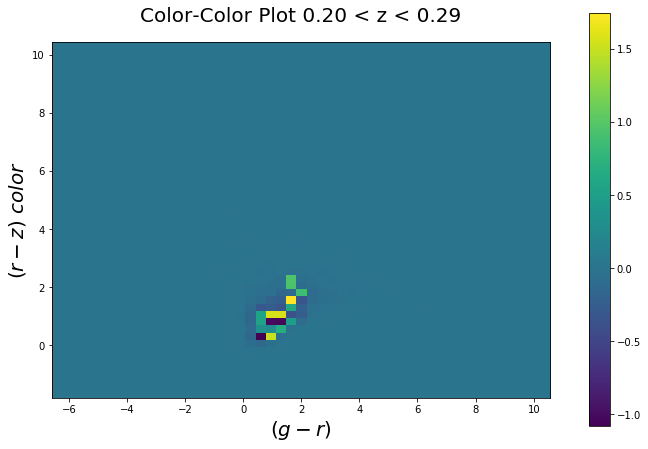

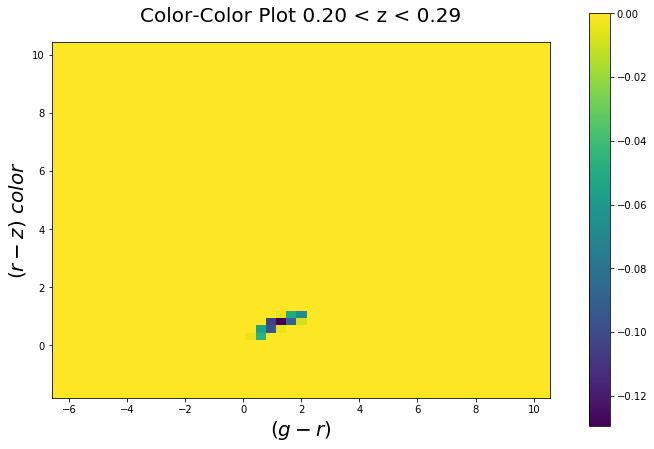

In [139]:

# for i in range(len(zrange)-1):
#     cmdHistograms(Nsat[np.where((z_LRG >= zrange[i]) & (z_LRG < zrange[i+1]))], rz_edges, gr_edges, zrange[i], zrange[i+1])
# #     plt.savefig ('/Users/mtownsend/Desktop/MeetingPlots/2July2020/satellite-color-color-{}.pdf'.format(i))    
#     plt.show()
#     print(i)

cmdHistograms(NsatDict[4], rz_edges, gr_edges, zrange[i], zrange[i+1])
plt.show()

cmdHistograms(newNsat4, rz_edges, gr_edges, zrange[i], zrange[i+1])
plt.show()




# Nsat_zcut1 = Nsat[np.where((z_LRG >= zrange[0]) & (z_LRG < zrange[1]))]
# Nsat_zcut2 = Nsat[np.where((z_LRG >= zrange[1]) & (z_LRG < zrange[2]))]
# Nsat_zcut3 = Nsat[np.where((z_LRG >= 0.4) & (z_LRG < 0.5))]
# Nsat_zcut4 = Nsat[np.where((z_LRG >= 0.5) & (z_LRG < 0.6))]
# Nsat_zcut5 = Nsat[np.where((z_LRG >= 0.5) & (z_LRG < 0.65))]


# print(len(Nsat_zcut1))
# print(len(Nsat_zcut2))
# print(len(Nsat_zcut3))
# print(len(Nsat_zcut4))
# print(len(Nsat_zcut5))

# cmdHistograms(Nsat, rz_edges, gr_edges)
# # cmdHistograms(Nsat_zcut2, edges)
# # cmdHistograms(Nsat_zcut3, edges)
# # cmdHistograms(Nsat_zcut4, edges)
# cmdHistograms(Nsat_zcut5, edges)


# projectionNsat = Nsat[0][:, :, :].sum(axis=2) 

# plt.figure(figsize=(10,10))
# ax = plt.gca()
# im = ax.imshow(projectionNsat, origin='lower') #, extent=(min(zmag_edges), max(zmag_edges), min(gr_edges), max(gr_edges)))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# plt.colorbar(im, cax=cax)
# ax.set_title("MASK AXIS 2")
# #     ax.set_ylim([-0.6,5.5])
# # ax.set_xlabel('zmag',fontsize=20)
# # ax.set_ylabel('r-z',fontsize=20)
# # plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/18June2020/mask2-axis0.pdf')   
# plt.show()
